In [ ]:
# ============================================================
# Google Colab Setup (skip this cell if running locally)
# ============================================================
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running on Google Colab — installing dependencies...")

    # 1. Install Python packages
    !pip install -q ollama pandas numpy networkx matplotlib

    # 2. Install & start Ollama
    print("\nInstalling Ollama...")
    !curl -fsSL https://ollama.com/install.sh | sh

    # Start Ollama server in the background
    import subprocess, time
    subprocess.Popen(["ollama", "serve"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    time.sleep(5)  # wait for server to start
    print("Ollama server started.")

    # 3. Pull LLM model
    print("\nPulling LLM model (this may take a few minutes)...")
    !ollama pull llama3.2
    # Uncomment below for better Thai support (larger model):
    # !ollama pull qwen3:4b

    # 4. Install Thai fonts for matplotlib
    !apt-get install -y fonts-tlwg-sarabun fonts-noto-thai > /dev/null 2>&1
    import matplotlib, shutil, pathlib
    cache_dir = pathlib.Path(matplotlib.get_cachedir())
    if cache_dir.exists():
        shutil.rmtree(cache_dir)
    print("Thai fonts installed.")

    # 5. Mount Google Drive (optional — uncomment if your data is on Drive)
    # from google.colab import drive
    # drive.mount('/content/drive')

    # 6. Clone or upload project files
    # Option A: Clone from GitHub (uncomment and edit URL)
    # !git clone https://github.com/YOUR_USERNAME/ML-Project.git
    # %cd ML-Project

    # Option B: Upload zip manually
    # from google.colab import files
    # uploaded = files.upload()  # upload ML-Project.zip
    # !unzip -q ML-Project.zip

    print("\nColab setup complete! Ollama is running with LLM ready.")
else:
    print("Running locally — skipping Colab setup.")

# Task 3: Model Development

## Comparing PageIndex vs PageIndex + Light Knowledge Graph for Thai Criminal Law Q&A Chatbot

**Course:** CS652 Applied Machine Learning  
**Student:** 6809036087  
**LLM:** Qwen3:8b via Ollama (local inference)

---

### Architecture

```
Query → Pipeline A (PageIndex Only)    → Retrieved Sections → Qwen3 → Answer
Query → Pipeline B (PageIndex + KG)    → Retrieved Sections → Qwen3 → Answer
```

### Notebook Sections
1. Setup & Dependencies
2. Build PageIndex Tree Structure
3. Generate Node Summaries (Bottom-Up with Qwen3)
4. Build Light Knowledge Graph
5. Pipeline A: PageIndex Retrieval
6. Pipeline B: PageIndex + KG Retrieval
7. Evaluation Framework
8. Run Evaluation & Compare
9. Analysis & Discussion
10. Save Results

---
## 1. Setup & Dependencies

In [1]:
# Install ollama Python client (if not already installed)
!pip install ollama -q


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import json
import os
import re
import time
import copy
from collections import defaultdict, Counter
from pathlib import Path

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import ollama

# Configure matplotlib for Thai text
thai_fonts = [f.name for f in matplotlib.font_manager.fontManager.ttflist 
              if 'Tahoma' in f.name or 'Sarabun' in f.name or 'Garuda' in f.name 
              or 'Loma' in f.name or 'TH ' in f.name or 'Angsana' in f.name
              or 'Browallia' in f.name or 'Cordia' in f.name]

if thai_fonts:
    plt.rcParams['font.family'] = thai_fonts[0]
    print(f"Using Thai font: {thai_fonts[0]}")
else:
    print("No Thai font found, using default font")

plt.rcParams['axes.unicode_minus'] = False

print("All imports loaded successfully")

Using Thai font: Tahoma
All imports loaded successfully


In [3]:
# Verify Qwen3 model is available
# Auto-detect: prefer qwen3:8b, fall back to qwen3:4b
models = ollama.list()
model_names = [m.model for m in models.models]
print("Available Ollama models:", model_names)

MODEL_NAME = None
for candidate in ["qwen3:8b", "qwen3:4b", "qwen3:latest"]:
    if any(candidate in name for name in model_names):
        MODEL_NAME = candidate
        break

if MODEL_NAME is None:
    print("\n⚠ No Qwen3 model found! Please run one of:")
    print("  ollama pull qwen3:8b   (recommended, ~5 GB)")
    print("  ollama pull qwen3:4b   (smaller, ~2.5 GB)")
    raise RuntimeError("No Qwen3 model available")

print(f"\n✓ Using model: {MODEL_NAME}")

Available Ollama models: ['llama3.2:1b', 'llama3.2:latest']

⚠ No Qwen3 model found! Please run one of:
  ollama pull qwen3:8b   (recommended, ~5 GB)
  ollama pull qwen3:4b   (smaller, ~2.5 GB)


RuntimeError: No Qwen3 model available

In [ ]:
# Load all preprocessed data from Task 2
DATA_DIR = Path("data/preprocessed")
RESULTS_DIR = Path("data/results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

with open(DATA_DIR / "hierarchy_tree.json", "r", encoding="utf-8") as f:
    hierarchy_tree = json.load(f)

with open(DATA_DIR / "entities.json", "r", encoding="utf-8") as f:
    entities_data = json.load(f)

with open(DATA_DIR / "cross_reference_edges.json", "r", encoding="utf-8") as f:
    cross_ref_edges = json.load(f)

with open(DATA_DIR / "qa_test_dataset.json", "r", encoding="utf-8") as f:
    qa_dataset = json.load(f)

df = pd.read_csv(DATA_DIR / "preprocessed_criminal_code.csv")

print(f"Hierarchy tree: root with {len(hierarchy_tree['children'])} books")
print(f"Entities: {len(entities_data)} sections")
print(f"Cross-reference edges: {len(cross_ref_edges)} edges")
print(f"Q&A dataset: {len(qa_dataset)} questions")
print(f"Preprocessed CSV: {df.shape[0]} rows, {df.shape[1]} columns")

In [ ]:
# Helper function to call Qwen3
def ask_qwen3(prompt, temperature=0.3, max_retries=3):
    """Call Qwen3 via Ollama with retry logic."""
    for attempt in range(max_retries):
        try:
            response = ollama.chat(
                model=MODEL_NAME,
                messages=[{"role": "user", "content": prompt}],
                options={"temperature": temperature, "num_predict": 1024}
            )
            text = response["message"]["content"]
            # Remove <think>...</think> blocks if present (Qwen3 thinking mode)
            text = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL).strip()
            return text
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(2)
            else:
                print(f"Error calling Qwen3: {e}")
                return ""

# Quick test
test_response = ask_qwen3("สวัสดีครับ ตอบสั้นๆ ว่าคุณคือใคร")
print("Test response:", test_response[:200])

---
## 2. Build PageIndex Tree Structure

Convert the hierarchy JSON into a navigable tree with parent/child links and unique node IDs.

In [ ]:
class TreeNode:
    """A node in the PageIndex tree."""
    def __init__(self, node_id, level, name, text="", parent=None):
        self.node_id = node_id
        self.level = level        # root, book, title, division, section
        self.name = name
        self.text = text           # full legal text (sections only)
        self.summary = ""          # LLM-generated summary
        self.parent = parent
        self.children = []
        self.section_num = None    # for leaf nodes
    
    def __repr__(self):
        return f"TreeNode({self.node_id}, {self.level}, {self.name[:40]}...)"


def build_tree(tree_data):
    """Build navigable tree from hierarchy_tree.json."""
    nodes = {}  # node_id -> TreeNode
    
    # Create root
    root = TreeNode("root", "root", tree_data["root"])
    nodes["root"] = root
    
    def add_children(parent_node, children_data):
        for child_data in children_data:
            child_type = child_data["type"]
            
            if child_type == "section":
                node_id = f"section_{child_data['number']}"
                name = f"มาตรา {child_data['number']}"
                text = child_data.get("full_text", child_data.get("text", ""))
                node = TreeNode(node_id, "section", name, text, parent_node)
                node.section_num = str(child_data["number"])
            else:
                num = child_data.get("number", "")
                name = child_data.get("name", f"{child_type} {num}")
                node_id = f"{child_type}_{num}"
                node = TreeNode(node_id, child_type, name, parent=parent_node)
            
            nodes[node_id] = node
            parent_node.children.append(node)
            
            if "children" in child_data and child_data["children"]:
                add_children(node, child_data["children"])
    
    add_children(root, tree_data["children"])
    return root, nodes


root, all_nodes = build_tree(hierarchy_tree)

# Count nodes by level
level_counts = Counter(n.level for n in all_nodes.values())
print("Tree node counts by level:")
for level, count in sorted(level_counts.items()):
    print(f"  {level}: {count}")
print(f"\nTotal nodes: {len(all_nodes)}")

In [ ]:
# Verify tree structure by printing top 2 levels
print(f"Root: {root.name}")
for book in root.children:
    print(f"  ├── {book.name} ({len(book.children)} titles)")
    for title in book.children[:3]:
        n_div = len(title.children)
        n_sec = sum(len(d.children) for d in title.children if d.level == 'division')
        # Some titles have sections directly (no division)
        n_sec += sum(1 for c in title.children if c.level == 'section')
        print(f"  │   ├── {title.name} ({n_div} children, ~{n_sec} sections)")
    if len(book.children) > 3:
        print(f"  │   └── ... and {len(book.children) - 3} more titles")

---
## 3. Generate Node Summaries (Bottom-Up with Qwen3)

Generate Thai summaries for each node, starting from leaf sections and building up. Summaries are cached to avoid re-generation.

In [ ]:
SUMMARIES_PATH = DATA_DIR / "node_summaries.json"

# Load cached summaries if they exist
if SUMMARIES_PATH.exists():
    with open(SUMMARIES_PATH, "r", encoding="utf-8") as f:
        cached_summaries = json.load(f)
    print(f"Loaded {len(cached_summaries)} cached summaries")
else:
    cached_summaries = {}
    print("No cached summaries found, will generate from scratch")

In [ ]:
def summarize_section(node):
    """Summarize a leaf section node."""
    prompt = f"""สรุปมาตรากฎหมายต่อไปนี้ให้สั้นกระชับ 1-2 ประโยค เป็นภาษาไทย ระบุสาระสำคัญและบทลงโทษ (ถ้ามี):

{node.text[:1500]}

สรุป:"""
    return ask_qwen3(prompt, temperature=0.2)


def summarize_parent(node, children_summaries):
    """Summarize a parent node from its children's summaries."""
    summaries_text = "\n".join([
        f"- {child.name}: {summary}" 
        for child, summary in children_summaries
    ])
    
    # Truncate if too long
    if len(summaries_text) > 3000:
        summaries_text = summaries_text[:3000] + "\n... (ตัดทอน)"
    
    prompt = f"""สรุปภาพรวมของ "{node.name}" จากเนื้อหาย่อยต่อไปนี้ ให้สั้นกระชับ 2-3 ประโยค เป็นภาษาไทย:

{summaries_text}

สรุปภาพรวม:"""
    return ask_qwen3(prompt, temperature=0.2)


def generate_all_summaries(root_node, nodes_dict, cached):
    """Generate summaries bottom-up for all nodes."""
    total = len(nodes_dict)
    generated = 0
    skipped = 0
    
    def process_node(node):
        nonlocal generated, skipped
        
        # Check cache first
        if node.node_id in cached:
            node.summary = cached[node.node_id]
            skipped += 1
            # Still need to process children for their summaries
            for child in node.children:
                process_node(child)
            return node.summary
        
        # Process children first (bottom-up)
        children_summaries = []
        for child in node.children:
            child_summary = process_node(child)
            children_summaries.append((child, child_summary))
        
        # Generate summary
        if node.level == "section":
            node.summary = summarize_section(node)
        elif node.level == "root":
            node.summary = summarize_parent(node, children_summaries)
        elif children_summaries:
            node.summary = summarize_parent(node, children_summaries)
        else:
            node.summary = node.name
        
        # Cache immediately
        cached[node.node_id] = node.summary
        generated += 1
        
        if generated % 20 == 0:
            print(f"  Generated {generated}/{total - skipped} summaries...")
            # Save intermediate cache
            with open(SUMMARIES_PATH, "w", encoding="utf-8") as f:
                json.dump(cached, f, ensure_ascii=False, indent=2)
        
        return node.summary
    
    process_node(root_node)
    
    # Final save
    with open(SUMMARIES_PATH, "w", encoding="utf-8") as f:
        json.dump(cached, f, ensure_ascii=False, indent=2)
    
    print(f"\nDone! Generated: {generated}, Cached: {skipped}, Total: {total}")
    return cached

In [ ]:
# Generate summaries (this takes ~30-60 minutes on first run)
print("Generating node summaries (bottom-up)...")
print("This may take a while on first run. Summaries are cached for future use.\n")

start_time = time.time()
cached_summaries = generate_all_summaries(root, all_nodes, cached_summaries)
elapsed = time.time() - start_time

print(f"\nTime elapsed: {elapsed/60:.1f} minutes")
print(f"Summaries saved to: {SUMMARIES_PATH}")

In [ ]:
# Show sample summaries at each level
print("=== Sample Summaries ===")
print(f"\n[Root] {root.name}:")
print(f"  {root.summary[:200]}")

if root.children:
    book = root.children[0]
    print(f"\n[Book] {book.name}:")
    print(f"  {book.summary[:200]}")
    
    if book.children:
        title = book.children[0]
        print(f"\n[Title] {title.name}:")
        print(f"  {title.summary[:200]}")
        
        if title.children:
            div_or_sec = title.children[0]
            print(f"\n[{div_or_sec.level.title()}] {div_or_sec.name}:")
            print(f"  {div_or_sec.summary[:200]}")

---
## 4. Build Light Knowledge Graph

Create a NetworkX directed graph with section nodes, cross-reference edges, and entity attributes.

In [ ]:
# Build Knowledge Graph
kg = nx.DiGraph()

# Build section lookup from DataFrame
section_texts = {}
for _, row in df.iterrows():
    sec_num = str(row['article'])
    section_texts[sec_num] = row.get('full_text', row.get('text', ''))

# Add nodes from entities data
for entity in entities_data:
    sec_num = str(entity["section_num"])
    kg.add_node(sec_num, 
                hierarchy_path=entity["hierarchy_path"],
                penalties=[p["type"] for p in entity["entities"]["penalties"]],
                penalty_combination=entity["entities"]["penalty_combination"],
                legal_terms=entity["entities"]["legal_terms"],
                has_exception=entity["entities"]["has_exception"],
                has_condition=entity["entities"]["has_condition"],
                text=section_texts.get(sec_num, ""))

# Add cross-reference edges
for edge in cross_ref_edges:
    src = str(edge["source"])
    tgt = str(edge["target"])
    if src in kg.nodes and tgt in kg.nodes:
        kg.add_edge(src, tgt, relation="references")

print(f"Knowledge Graph:")
print(f"  Nodes: {kg.number_of_nodes()}")
print(f"  Edges (cross-references): {kg.number_of_edges()}")
print(f"  Average out-degree: {sum(d for _, d in kg.out_degree()) / kg.number_of_nodes():.2f}")
print(f"  Nodes with cross-refs: {sum(1 for _, d in kg.out_degree() if d > 0)}")

In [ ]:
# Build division membership lookup for thematic expansion
section_to_division = {}
division_sections = defaultdict(list)

for entity in entities_data:
    sec_num = str(entity["section_num"])
    path = entity["hierarchy_path"]
    # Extract division from hierarchy path
    parts = path.split(" > ")
    if len(parts) >= 3:
        division = parts[2]  # e.g., "หมวด 1: บทนิยาม"
    else:
        division = parts[-1]
    section_to_division[sec_num] = division
    division_sections[division].append(sec_num)

print(f"Division groups: {len(division_sections)}")
print(f"Average sections per division: {np.mean([len(v) for v in division_sections.values()]):.1f}")

In [ ]:
# KG query functions

def get_cross_refs(section_num, hops=1):
    """Get cross-referenced sections (1-hop neighbors)."""
    section_num = str(section_num)
    if section_num not in kg:
        return []
    
    refs = set()
    current = {section_num}
    for _ in range(hops):
        next_hop = set()
        for node in current:
            # Outgoing references
            next_hop.update(kg.successors(node))
            # Incoming references
            next_hop.update(kg.predecessors(node))
        refs.update(next_hop)
        current = next_hop
    
    refs.discard(section_num)
    return list(refs)


def get_penalty_info(section_num):
    """Get penalty information for a section."""
    section_num = str(section_num)
    if section_num not in kg:
        return {}
    data = kg.nodes[section_num]
    return {
        "penalties": data.get("penalties", []),
        "combination": data.get("penalty_combination", "none")
    }


def get_same_division_sections(section_num, max_sections=5):
    """Get other sections in the same division."""
    section_num = str(section_num)
    division = section_to_division.get(section_num)
    if not division:
        return []
    siblings = [s for s in division_sections[division] if s != section_num]
    return siblings[:max_sections]


# Test KG functions
test_sec = "334"  # ลักทรัพย์ (theft)
print(f"Test section: มาตรา {test_sec}")
print(f"  Cross-refs: {get_cross_refs(test_sec)}")
print(f"  Penalties: {get_penalty_info(test_sec)}")
print(f"  Same division: {get_same_division_sections(test_sec)}")

---
## 5. Pipeline A: PageIndex Retrieval

Tree-based retrieval: Start at root, ask LLM which branch is most relevant at each level (beam width = 2), descend to leaf sections.

In [ ]:
def pageindex_retrieve(query, root_node, beam_width=2, verbose=False):
    """
    PageIndex tree traversal retrieval.
    At each level, ask Qwen3 to select the top-k most relevant branches.
    Returns list of retrieved section TreeNodes.
    """
    current_nodes = [root_node]
    retrieved_sections = []
    
    while current_nodes:
        next_level_nodes = []
        
        for node in current_nodes:
            if not node.children:
                # Leaf node (section) - add to results
                if node.level == "section":
                    retrieved_sections.append(node)
                continue
            
            # If all children are sections, include all (already at leaf level)
            if all(c.level == "section" for c in node.children):
                # Ask LLM to pick most relevant sections
                choices = "\n".join([
                    f"{i+1}. {c.name}: {c.summary[:150]}" 
                    for i, c in enumerate(node.children)
                ])
                
                prompt = f"""คำถาม: {query}

เลือกมาตราที่เกี่ยวข้องกับคำถามมากที่สุด (เลือกได้หลายข้อ ไม่เกิน {min(beam_width + 1, len(node.children))} ข้อ)
ตอบเป็นตัวเลขคั่นด้วยเครื่องหมายจุลภาค เช่น 1,3,5

ตัวเลือก:
{choices}

ตอบเฉพาะตัวเลข:"""
                
                response = ask_qwen3(prompt, temperature=0.1)
                selected = parse_selection(response, len(node.children))
                
                if not selected:
                    selected = list(range(min(beam_width, len(node.children))))
                
                for idx in selected[:beam_width + 1]:
                    retrieved_sections.append(node.children[idx])
                
                if verbose:
                    print(f"  [{node.name}] Selected sections: {[node.children[i].name for i in selected[:beam_width+1]]}")
                continue
            
            # Non-leaf: ask LLM to choose branches
            choices = "\n".join([
                f"{i+1}. {c.name}: {c.summary[:150]}" 
                for i, c in enumerate(node.children)
            ])
            
            prompt = f"""คำถาม: {query}

เลือกหัวข้อที่เกี่ยวข้องกับคำถามมากที่สุด (เลือกได้ {min(beam_width, len(node.children))} ข้อ)
ตอบเป็นตัวเลขคั่นด้วยเครื่องหมายจุลภาค เช่น 1,3

ตัวเลือก:
{choices}

ตอบเฉพาะตัวเลข:"""
            
            response = ask_qwen3(prompt, temperature=0.1)
            selected = parse_selection(response, len(node.children))
            
            if not selected:
                selected = list(range(min(beam_width, len(node.children))))
            
            for idx in selected[:beam_width]:
                next_level_nodes.append(node.children[idx])
            
            if verbose:
                print(f"  [{node.level}] {node.name} -> Selected: {[node.children[i].name for i in selected[:beam_width]]}")
        
        current_nodes = next_level_nodes
    
    return retrieved_sections


def parse_selection(response, max_options):
    """Parse LLM selection response into list of 0-based indices."""
    numbers = re.findall(r'\d+', response)
    indices = []
    for n in numbers:
        idx = int(n) - 1  # Convert to 0-based
        if 0 <= idx < max_options:
            indices.append(idx)
    return list(dict.fromkeys(indices))  # Deduplicate preserving order

In [ ]:
def generate_answer(query, retrieved_sections, pipeline_name=""):
    """Generate answer from retrieved sections using Qwen3."""
    # Build context from retrieved sections
    context_parts = []
    for node in retrieved_sections:
        text = node.text if node.text else node.summary
        context_parts.append(f"{node.name}: {text[:500]}")
    
    context = "\n\n".join(context_parts)
    
    # Truncate context if too long
    if len(context) > 4000:
        context = context[:4000] + "\n... (ตัดทอน)"
    
    prompt = f"""คุณเป็นผู้เชี่ยวชาญด้านกฎหมายอาญาไทย ตอบคำถามต่อไปนี้โดยอ้างอิงจากประมวลกฎหมายอาญาที่ให้มา
ตอบเป็นภาษาไทย ให้ครบถ้วนและถูกต้อง อ้างอิงเลขมาตราที่เกี่ยวข้อง

=== บทบัญญัติที่เกี่ยวข้อง ===
{context}

=== คำถาม ===
{query}

=== คำตอบ ==="""
    
    return ask_qwen3(prompt, temperature=0.3)


def pipeline_a(query, verbose=False):
    """Full Pipeline A: PageIndex retrieval + answer generation."""
    start = time.time()
    
    # Retrieve
    retrieved = pageindex_retrieve(query, root, beam_width=2, verbose=verbose)
    
    # Generate answer
    answer = generate_answer(query, retrieved, "Pipeline A")
    
    elapsed = time.time() - start
    
    return {
        "answer": answer,
        "retrieved_sections": [n.section_num for n in retrieved if n.section_num],
        "retrieved_names": [n.name for n in retrieved],
        "latency": elapsed
    }

In [ ]:
# Test Pipeline A with a sample question
test_query = qa_dataset[0]["question"]  # ความผิดฐานลักทรัพย์มีโทษอย่างไร?
print(f"Test query: {test_query}")
print(f"Expected sections: {qa_dataset[0]['reference_sections']}")
print()

result_a = pipeline_a(test_query, verbose=True)
print(f"\nRetrieved sections: {result_a['retrieved_sections']}")
print(f"Latency: {result_a['latency']:.1f}s")
print(f"\nAnswer: {result_a['answer'][:500]}")

---
## 6. Pipeline B: PageIndex + KG Retrieval

Same PageIndex traversal, then expand retrieved sections using Knowledge Graph (cross-references, same-division siblings).

In [ ]:
def kg_expand(retrieved_sections, max_expansion=5):
    """
    Expand retrieved sections using Knowledge Graph.
    - Follow cross-reference edges (1-hop)
    - Add same-division siblings for context
    Returns expanded list of section numbers.
    """
    original_sections = set(n.section_num for n in retrieved_sections if n.section_num)
    expanded = set(original_sections)
    
    for sec_num in original_sections:
        # Cross-reference expansion
        cross_refs = get_cross_refs(sec_num, hops=1)
        expanded.update(cross_refs[:3])  # Limit per section
        
        # Same-division siblings (for comparison questions)
        siblings = get_same_division_sections(sec_num, max_sections=2)
        expanded.update(siblings)
    
    # Limit total expansion
    expanded = list(expanded)
    if len(expanded) > len(original_sections) + max_expansion:
        # Keep originals + top expansion by relevance (degree in KG)
        new_sections = [s for s in expanded if s not in original_sections]
        new_sections.sort(key=lambda s: kg.degree(s) if s in kg else 0, reverse=True)
        expanded = list(original_sections) + new_sections[:max_expansion]
    
    return expanded


def sections_to_nodes(section_nums):
    """Convert section numbers to TreeNodes (or create minimal nodes)."""
    nodes = []
    for sec_num in section_nums:
        node_id = f"section_{sec_num}"
        if node_id in all_nodes:
            nodes.append(all_nodes[node_id])
        elif sec_num in kg:
            # Create a minimal node from KG data
            node = TreeNode(node_id, "section", f"มาตรา {sec_num}", 
                          kg.nodes[sec_num].get("text", ""))
            node.section_num = sec_num
            nodes.append(node)
    return nodes


def pipeline_b(query, verbose=False):
    """Full Pipeline B: PageIndex + KG retrieval + answer generation."""
    start = time.time()
    
    # Step 1: PageIndex retrieval (same as Pipeline A)
    retrieved = pageindex_retrieve(query, root, beam_width=2, verbose=verbose)
    
    # Step 2: KG expansion
    expanded_sections = kg_expand(retrieved, max_expansion=5)
    
    if verbose:
        original = set(n.section_num for n in retrieved if n.section_num)
        new_from_kg = set(expanded_sections) - original
        print(f"  [KG] Original: {original}, Added: {new_from_kg}")
    
    # Step 3: Convert back to nodes for answer generation
    expanded_nodes = sections_to_nodes(expanded_sections)
    
    # Step 4: Generate answer with expanded context
    answer = generate_answer(query, expanded_nodes, "Pipeline B")
    
    elapsed = time.time() - start
    
    return {
        "answer": answer,
        "retrieved_sections": expanded_sections,
        "original_sections": [n.section_num for n in retrieved if n.section_num],
        "kg_added_sections": list(set(expanded_sections) - set(n.section_num for n in retrieved if n.section_num)),
        "retrieved_names": [f"มาตรา {s}" for s in expanded_sections],
        "latency": elapsed
    }

In [ ]:
# Test Pipeline B with the same question
print(f"Test query: {test_query}")
print(f"Expected sections: {qa_dataset[0]['reference_sections']}")
print()

result_b = pipeline_b(test_query, verbose=True)
print(f"\nRetrieved sections (total): {result_b['retrieved_sections']}")
print(f"  Original from PageIndex: {result_b['original_sections']}")
print(f"  Added by KG: {result_b['kg_added_sections']}")
print(f"Latency: {result_b['latency']:.1f}s")
print(f"\nAnswer: {result_b['answer'][:500]}")

---
## 7. Evaluation Framework

Evaluate both pipelines on 20 test questions. Metrics: retrieval recall/precision, answer quality (LLM-as-judge), latency.

In [ ]:
def compute_retrieval_metrics(retrieved_sections, ground_truth_sections):
    """Compute retrieval precision and recall."""
    retrieved = set(str(s) for s in retrieved_sections)
    ground_truth = set(str(s) for s in ground_truth_sections)
    
    if not ground_truth:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0}
    
    true_positives = retrieved & ground_truth
    
    precision = len(true_positives) / len(retrieved) if retrieved else 0.0
    recall = len(true_positives) / len(ground_truth) if ground_truth else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {"precision": precision, "recall": recall, "f1": f1}


def llm_judge_answer(question, generated_answer, ground_truth_answer):
    """Use Qwen3 as a judge to score answer quality (1-5)."""
    prompt = f"""ให้คะแนนคำตอบต่อไปนี้ เทียบกับคำตอบที่ถูกต้อง (1-5 คะแนน)

เกณฑ์การให้คะแนน:
5 = ถูกต้องครบถ้วน ตรงกับคำตอบที่ถูกต้อง
4 = ถูกต้องเป็นส่วนใหญ่ ขาดรายละเอียดเล็กน้อย
3 = ถูกต้องบางส่วน มีข้อมูลหลักถูกต้อง
2 = ถูกต้องเล็กน้อย ขาดข้อมูลสำคัญมาก
1 = ไม่ถูกต้อง หรือไม่เกี่ยวข้อง

คำถาม: {question}

คำตอบที่ถูกต้อง: {ground_truth_answer}

คำตอบที่ต้องประเมิน: {generated_answer[:500]}

ตอบเป็นตัวเลข 1-5 เท่านั้น:"""
    
    response = ask_qwen3(prompt, temperature=0.1)
    # Extract score
    numbers = re.findall(r'[1-5]', response)
    return int(numbers[0]) if numbers else 3  # Default to 3 if parsing fails


print("Evaluation framework ready.")
print(f"Q&A dataset: {len(qa_dataset)} questions")
print(f"Question types: {Counter(q['question_type'] for q in qa_dataset)}")
print(f"Difficulty levels: {Counter(q['difficulty'] for q in qa_dataset)}")

---
## 8. Run Evaluation & Compare

Execute all 20 questions through both pipelines and collect metrics.

In [ ]:
# Run full evaluation
results_a = []
results_b = []

print("Running evaluation on 20 questions...")
print("="*60)

for i, qa in enumerate(qa_dataset):
    qid = qa["id"]
    question = qa["question"]
    gt_answer = qa["ground_truth_answer"]
    gt_sections = qa["reference_sections"]
    
    print(f"\n[{i+1}/20] {qid}: {question[:60]}...")
    
    # Pipeline A
    print("  Pipeline A...", end=" ")
    res_a = pipeline_a(question)
    metrics_a = compute_retrieval_metrics(res_a["retrieved_sections"], gt_sections)
    score_a = llm_judge_answer(question, res_a["answer"], gt_answer)
    res_a.update({
        "qid": qid, "question": question, "gt_answer": gt_answer,
        "gt_sections": gt_sections, "question_type": qa["question_type"],
        "difficulty": qa["difficulty"],
        "retrieval_precision": metrics_a["precision"],
        "retrieval_recall": metrics_a["recall"],
        "retrieval_f1": metrics_a["f1"],
        "answer_score": score_a
    })
    results_a.append(res_a)
    print(f"Recall={metrics_a['recall']:.2f}, Score={score_a}, Time={res_a['latency']:.1f}s")
    
    # Pipeline B
    print("  Pipeline B...", end=" ")
    res_b = pipeline_b(question)
    metrics_b = compute_retrieval_metrics(res_b["retrieved_sections"], gt_sections)
    score_b = llm_judge_answer(question, res_b["answer"], gt_answer)
    res_b.update({
        "qid": qid, "question": question, "gt_answer": gt_answer,
        "gt_sections": gt_sections, "question_type": qa["question_type"],
        "difficulty": qa["difficulty"],
        "retrieval_precision": metrics_b["precision"],
        "retrieval_recall": metrics_b["recall"],
        "retrieval_f1": metrics_b["f1"],
        "answer_score": score_b
    })
    results_b.append(res_b)
    print(f"Recall={metrics_b['recall']:.2f}, Score={score_b}, Time={res_b['latency']:.1f}s")

print("\n" + "="*60)
print("Evaluation complete!")

In [ ]:
# Build comparison DataFrame
comparison_rows = []

for ra, rb in zip(results_a, results_b):
    comparison_rows.append({
        "qid": ra["qid"],
        "question": ra["question"][:50],
        "type": ra["question_type"],
        "difficulty": ra["difficulty"],
        "gt_sections": ",".join(ra["gt_sections"]),
        # Pipeline A
        "A_sections": ",".join(str(s) for s in ra["retrieved_sections"]),
        "A_recall": ra["retrieval_recall"],
        "A_precision": ra["retrieval_precision"],
        "A_score": ra["answer_score"],
        "A_latency": ra["latency"],
        # Pipeline B
        "B_sections": ",".join(str(s) for s in rb["retrieved_sections"]),
        "B_recall": rb["retrieval_recall"],
        "B_precision": rb["retrieval_precision"],
        "B_score": rb["answer_score"],
        "B_latency": rb["latency"],
        "B_kg_added": ",".join(str(s) for s in rb.get("kg_added_sections", []))
    })

df_compare = pd.DataFrame(comparison_rows)
print("Comparison table:")
df_compare[["qid", "type", "difficulty", "A_recall", "A_score", "B_recall", "B_score"]].to_string()

In [ ]:
# Overall summary statistics
print("=" * 60)
print("OVERALL RESULTS")
print("=" * 60)

summary = {
    "Pipeline A (PageIndex)": {
        "Avg Retrieval Recall": df_compare["A_recall"].mean(),
        "Avg Retrieval Precision": df_compare["A_precision"].mean(),
        "Avg Answer Score (1-5)": df_compare["A_score"].mean(),
        "Avg Latency (s)": df_compare["A_latency"].mean(),
    },
    "Pipeline B (PageIndex+KG)": {
        "Avg Retrieval Recall": df_compare["B_recall"].mean(),
        "Avg Retrieval Precision": df_compare["B_precision"].mean(),
        "Avg Answer Score (1-5)": df_compare["B_score"].mean(),
        "Avg Latency (s)": df_compare["B_latency"].mean(),
    }
}

df_summary = pd.DataFrame(summary).T
print(df_summary.to_string())

In [ ]:
# Breakdown by question type
print("\n" + "=" * 60)
print("BREAKDOWN BY QUESTION TYPE")
print("=" * 60)

for qtype in df_compare["type"].unique():
    subset = df_compare[df_compare["type"] == qtype]
    print(f"\n{qtype} ({len(subset)} questions):")
    print(f"  Pipeline A - Recall: {subset['A_recall'].mean():.2f}, Score: {subset['A_score'].mean():.1f}")
    print(f"  Pipeline B - Recall: {subset['B_recall'].mean():.2f}, Score: {subset['B_score'].mean():.1f}")

In [ ]:
# Breakdown by difficulty
print("\n" + "=" * 60)
print("BREAKDOWN BY DIFFICULTY")
print("=" * 60)

for diff in ["easy", "medium", "hard"]:
    subset = df_compare[df_compare["difficulty"] == diff]
    if len(subset) == 0:
        continue
    print(f"\n{diff} ({len(subset)} questions):")
    print(f"  Pipeline A - Recall: {subset['A_recall'].mean():.2f}, Score: {subset['A_score'].mean():.1f}")
    print(f"  Pipeline B - Recall: {subset['B_recall'].mean():.2f}, Score: {subset['B_score'].mean():.1f}")

In [ ]:
# Visualization: Pipeline comparison bar charts
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Overall metrics comparison
metrics_names = ["Retrieval Recall", "Retrieval Precision", "Answer Score\n(normalized)"]
a_vals = [df_compare["A_recall"].mean(), df_compare["A_precision"].mean(), df_compare["A_score"].mean() / 5]
b_vals = [df_compare["B_recall"].mean(), df_compare["B_precision"].mean(), df_compare["B_score"].mean() / 5]

x = np.arange(len(metrics_names))
width = 0.35
axes[0].bar(x - width/2, a_vals, width, label="Pipeline A", color="#4A90D9")
axes[0].bar(x + width/2, b_vals, width, label="Pipeline B", color="#E74C3C")
axes[0].set_xlabel("Metric")
axes[0].set_ylabel("Score")
axes[0].set_title("Overall Comparison")
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names, fontsize=9)
axes[0].legend()
axes[0].set_ylim(0, 1)

# 2. Answer score by question type
types = df_compare["type"].unique()
a_scores_by_type = [df_compare[df_compare["type"]==t]["A_score"].mean() for t in types]
b_scores_by_type = [df_compare[df_compare["type"]==t]["B_score"].mean() for t in types]

x = np.arange(len(types))
axes[1].bar(x - width/2, a_scores_by_type, width, label="Pipeline A", color="#4A90D9")
axes[1].bar(x + width/2, b_scores_by_type, width, label="Pipeline B", color="#E74C3C")
axes[1].set_xlabel("Question Type")
axes[1].set_ylabel("Avg Score (1-5)")
axes[1].set_title("Score by Question Type")
axes[1].set_xticks(x)
axes[1].set_xticklabels(types, rotation=30, ha="right", fontsize=9)
axes[1].legend()
axes[1].set_ylim(0, 5.5)

# 3. Answer score by difficulty
diffs = ["easy", "medium", "hard"]
a_scores_by_diff = [df_compare[df_compare["difficulty"]==d]["A_score"].mean() for d in diffs]
b_scores_by_diff = [df_compare[df_compare["difficulty"]==d]["B_score"].mean() for d in diffs]

x = np.arange(len(diffs))
axes[2].bar(x - width/2, a_scores_by_diff, width, label="Pipeline A", color="#4A90D9")
axes[2].bar(x + width/2, b_scores_by_diff, width, label="Pipeline B", color="#E74C3C")
axes[2].set_xlabel("Difficulty")
axes[2].set_ylabel("Avg Score (1-5)")
axes[2].set_title("Score by Difficulty")
axes[2].set_xticks(x)
axes[2].set_xticklabels(diffs, fontsize=9)
axes[2].legend()
axes[2].set_ylim(0, 5.5)

plt.tight_layout()
plt.savefig("data/results/pipeline_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: data/results/pipeline_comparison.png")

In [ ]:
# Visualization: Per-question score comparison
fig, ax = plt.subplots(figsize=(14, 5))

x = np.arange(len(qa_dataset))
width = 0.35

ax.bar(x - width/2, df_compare["A_score"], width, label="Pipeline A (PageIndex)", color="#4A90D9", alpha=0.8)
ax.bar(x + width/2, df_compare["B_score"], width, label="Pipeline B (PageIndex+KG)", color="#E74C3C", alpha=0.8)

ax.set_xlabel("Question ID")
ax.set_ylabel("Answer Quality Score (1-5)")
ax.set_title("Per-Question Answer Quality Comparison")
ax.set_xticks(x)
ax.set_xticklabels(df_compare["qid"], rotation=45, ha="right", fontsize=8)
ax.legend()
ax.set_ylim(0, 5.5)

plt.tight_layout()
plt.savefig("data/results/per_question_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: data/results/per_question_comparison.png")

---
## 9. Analysis & Discussion

In [ ]:
# Qualitative analysis: Show 3 questions where pipelines differ most
df_compare["score_diff"] = df_compare["B_score"] - df_compare["A_score"]

# Cases where KG helped
kg_helped = df_compare.nlargest(2, "score_diff")
# Cases where KG hurt
kg_hurt = df_compare.nsmallest(1, "score_diff")

print("=" * 60)
print("QUALITATIVE ANALYSIS")
print("=" * 60)

print("\n--- Cases where KG HELPED ---")
for _, row in kg_helped.iterrows():
    qid = row["qid"]
    ra = next(r for r in results_a if r["qid"] == qid)
    rb = next(r for r in results_b if r["qid"] == qid)
    print(f"\n{qid} [{row['type']}, {row['difficulty']}]: {ra['question']}")
    print(f"  Ground truth sections: {ra['gt_sections']}")
    print(f"  Pipeline A sections: {ra['retrieved_sections']} → Score: {row['A_score']}")
    print(f"  Pipeline B sections: {rb['retrieved_sections']} → Score: {row['B_score']}")
    print(f"  KG added: {rb.get('kg_added_sections', [])}")
    print(f"  Pipeline A answer: {ra['answer'][:200]}...")
    print(f"  Pipeline B answer: {rb['answer'][:200]}...")

print("\n--- Cases where KG HURT (or no help) ---")
for _, row in kg_hurt.iterrows():
    qid = row["qid"]
    ra = next(r for r in results_a if r["qid"] == qid)
    rb = next(r for r in results_b if r["qid"] == qid)
    print(f"\n{qid} [{row['type']}, {row['difficulty']}]: {ra['question']}")
    print(f"  Ground truth sections: {ra['gt_sections']}")
    print(f"  Pipeline A sections: {ra['retrieved_sections']} → Score: {row['A_score']}")
    print(f"  Pipeline B sections: {rb['retrieved_sections']} → Score: {row['B_score']}")
    print(f"  KG added: {rb.get('kg_added_sections', [])}")

In [ ]:
# Summary discussion
avg_a_score = df_compare["A_score"].mean()
avg_b_score = df_compare["B_score"].mean()
avg_a_recall = df_compare["A_recall"].mean()
avg_b_recall = df_compare["B_recall"].mean()

print("=" * 60)
print("DISCUSSION SUMMARY")
print("=" * 60)

winner = "Pipeline B (PageIndex + KG)" if avg_b_score > avg_a_score else "Pipeline A (PageIndex)"
if avg_a_score == avg_b_score:
    winner = "Tie"

print(f"\n1. Overall Winner: {winner}")
print(f"   A avg score: {avg_a_score:.2f} vs B avg score: {avg_b_score:.2f}")
print(f"   A avg recall: {avg_a_recall:.2f} vs B avg recall: {avg_b_recall:.2f}")

# Find where KG helps most
for qtype in df_compare["type"].unique():
    subset = df_compare[df_compare["type"] == qtype]
    diff = subset["B_score"].mean() - subset["A_score"].mean()
    if abs(diff) >= 0.5:
        direction = "helps" if diff > 0 else "hurts"
        print(f"\n2. KG {direction} for '{qtype}' questions (diff: {diff:+.1f})")

print(f"\n3. Latency:")
print(f"   Pipeline A avg: {df_compare['A_latency'].mean():.1f}s")
print(f"   Pipeline B avg: {df_compare['B_latency'].mean():.1f}s")
print(f"   KG overhead: {df_compare['B_latency'].mean() - df_compare['A_latency'].mean():.1f}s")

print(f"\n4. Limitations:")
print(f"   - Small test set (20 questions)")
print(f"   - LLM-as-judge may have biases")
print(f"   - 1-hop KG expansion may miss deeper connections")
print(f"   - Qwen3:8b may have limited Thai legal understanding")

---
## 10. Save Results

In [ ]:
# Save all results

# Pipeline A results
results_a_serializable = []
for r in results_a:
    r_copy = {k: v for k, v in r.items() if k != "retrieved_names"}
    results_a_serializable.append(r_copy)

with open(RESULTS_DIR / "pipeline_a_results.json", "w", encoding="utf-8") as f:
    json.dump(results_a_serializable, f, ensure_ascii=False, indent=2)

# Pipeline B results
results_b_serializable = []
for r in results_b:
    r_copy = {k: v for k, v in r.items() if k != "retrieved_names"}
    results_b_serializable.append(r_copy)

with open(RESULTS_DIR / "pipeline_b_results.json", "w", encoding="utf-8") as f:
    json.dump(results_b_serializable, f, ensure_ascii=False, indent=2)

# Comparison CSV
df_compare.to_csv(RESULTS_DIR / "evaluation_comparison.csv", index=False)

# Summary JSON
evaluation_summary = {
    "model": MODEL_NAME,
    "num_questions": len(qa_dataset),
    "pipeline_a": {
        "name": "PageIndex Only",
        "avg_retrieval_recall": float(df_compare["A_recall"].mean()),
        "avg_retrieval_precision": float(df_compare["A_precision"].mean()),
        "avg_answer_score": float(df_compare["A_score"].mean()),
        "avg_latency_seconds": float(df_compare["A_latency"].mean()),
    },
    "pipeline_b": {
        "name": "PageIndex + Light KG",
        "avg_retrieval_recall": float(df_compare["B_recall"].mean()),
        "avg_retrieval_precision": float(df_compare["B_precision"].mean()),
        "avg_answer_score": float(df_compare["B_score"].mean()),
        "avg_latency_seconds": float(df_compare["B_latency"].mean()),
    },
    "by_question_type": {},
    "by_difficulty": {}
}

for qtype in df_compare["type"].unique():
    subset = df_compare[df_compare["type"] == qtype]
    evaluation_summary["by_question_type"][qtype] = {
        "count": len(subset),
        "A_avg_score": float(subset["A_score"].mean()),
        "B_avg_score": float(subset["B_score"].mean()),
        "A_avg_recall": float(subset["A_recall"].mean()),
        "B_avg_recall": float(subset["B_recall"].mean()),
    }

for diff in ["easy", "medium", "hard"]:
    subset = df_compare[df_compare["difficulty"] == diff]
    if len(subset) > 0:
        evaluation_summary["by_difficulty"][diff] = {
            "count": len(subset),
            "A_avg_score": float(subset["A_score"].mean()),
            "B_avg_score": float(subset["B_score"].mean()),
            "A_avg_recall": float(subset["A_recall"].mean()),
            "B_avg_recall": float(subset["B_recall"].mean()),
        }

with open(RESULTS_DIR / "evaluation_summary.json", "w", encoding="utf-8") as f:
    json.dump(evaluation_summary, f, ensure_ascii=False, indent=2)

print("All results saved:")
for f in RESULTS_DIR.iterdir():
    size = f.stat().st_size
    print(f"  {f.name} ({size:,} bytes)")

In [ ]:
print("="*60)
print("Task 3: Model Development — COMPLETE")
print("="*60)
print(f"\nModel: {MODEL_NAME}")
print(f"Questions evaluated: {len(qa_dataset)}")
print(f"\nPipeline A (PageIndex):       Score = {df_compare['A_score'].mean():.2f}/5")
print(f"Pipeline B (PageIndex + KG):  Score = {df_compare['B_score'].mean():.2f}/5")
print(f"\nOutput files in: {RESULTS_DIR}/")
print(f"Node summaries cached in: {SUMMARIES_PATH}")

In [4]:
# Cell 2: Install ollama Python client
!pip install ollama -q


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
# Cell 3: Imports
import json
import os
import re
import time
import copy
from collections import defaultdict, Counter
from pathlib import Path

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import ollama

# Configure matplotlib for Thai text
thai_fonts = [f.name for f in matplotlib.font_manager.fontManager.ttflist 
              if 'Tahoma' in f.name or 'Sarabun' in f.name or 'Garuda' in f.name 
              or 'Loma' in f.name or 'TH ' in f.name or 'Angsana' in f.name
              or 'Browallia' in f.name or 'Cordia' in f.name]

if thai_fonts:
    plt.rcParams['font.family'] = thai_fonts[0]
    print(f"Using Thai font: {thai_fonts[0]}")
else:
    print("No Thai font found, using default font")

plt.rcParams['axes.unicode_minus'] = False

print("All imports loaded successfully")

Using Thai font: Tahoma
All imports loaded successfully


In [6]:
# Cell 4: Verify LLM model
models = ollama.list()
model_names = [m.model for m in models.models]
print("Available Ollama models:", model_names)

MODEL_NAME = None
for candidate in ["qwen3:8b", "qwen3:4b", "qwen3:latest", "llama3.2:latest", "llama3.2:1b"]:
    if any(candidate in name for name in model_names):
        MODEL_NAME = candidate
        break

if MODEL_NAME is None:
    print("\n⚠ No supported model found! Please run one of:")
    print("  ollama pull qwen3:8b     (recommended, ~5 GB)")
    print("  ollama pull qwen3:4b     (smaller, ~2.5 GB)")
    print("  ollama pull llama3.2     (fallback, ~2 GB)")
    raise RuntimeError("No supported model available")

print(f"\n✓ Using model: {MODEL_NAME}")
if "llama" in MODEL_NAME:
    print("  Note: Using Llama 3.2 as fallback. Thai language support may be limited compared to Qwen3.")

Available Ollama models: ['llama3.2:1b', 'llama3.2:latest']

✓ Using model: llama3.2:latest
  Note: Using Llama 3.2 as fallback. Thai language support may be limited compared to Qwen3.


In [7]:
# Cell 5: Load all preprocessed data from Task 2
DATA_DIR = Path("data/preprocessed")
RESULTS_DIR = Path("data/results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

with open(DATA_DIR / "hierarchy_tree.json", "r", encoding="utf-8") as f:
    hierarchy_tree = json.load(f)

with open(DATA_DIR / "entities.json", "r", encoding="utf-8") as f:
    entities_data = json.load(f)

with open(DATA_DIR / "cross_reference_edges.json", "r", encoding="utf-8") as f:
    cross_ref_edges = json.load(f)

with open(DATA_DIR / "qa_test_dataset.json", "r", encoding="utf-8") as f:
    qa_dataset = json.load(f)

df = pd.read_csv(DATA_DIR / "preprocessed_criminal_code.csv")

print(f"Hierarchy tree: root with {len(hierarchy_tree['children'])} books")
print(f"Entities: {len(entities_data)} sections")
print(f"Cross-reference edges: {len(cross_ref_edges)} edges")
print(f"Q&A dataset: {len(qa_dataset)} questions")
print(f"Preprocessed CSV: {df.shape[0]} rows, {df.shape[1]} columns")

Hierarchy tree: root with 3 books
Entities: 444 sections
Cross-reference edges: 360 edges
Q&A dataset: 20 questions
Preprocessed CSV: 444 rows, 21 columns


In [8]:
# Cell 6: Helper function to call LLM
def ask_llm(prompt, temperature=0.3, max_retries=3):
    """Call the local LLM via Ollama with retry logic."""
    for attempt in range(max_retries):
        try:
            response = ollama.chat(
                model=MODEL_NAME,
                messages=[{"role": "user", "content": prompt}],
                options={"temperature": temperature, "num_predict": 1024}
            )
            text = response["message"]["content"]
            # Remove <think>...</think> blocks if present (Qwen3 thinking mode)
            text = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL).strip()
            return text
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(2)
            else:
                print(f"Error calling LLM: {e}")
                return ""

# Alias for backward compatibility
ask_qwen3 = ask_llm

# Quick test
test_response = ask_llm("สวัสดีครับ ตอบสั้นๆ ว่าคุณคือใคร")
print(f"Model: {MODEL_NAME}")
print("Test response:", test_response[:200])

Model: llama3.2:latest
Test response: สวัสดีครับ! ฉันคือ AI ที่ช่วยเหลือและให้ข้อมูลแก่คุณ


In [9]:
# Cell 8: Build PageIndex Tree
class TreeNode:
    """A node in the PageIndex tree."""
    def __init__(self, node_id, level, name, text="", parent=None):
        self.node_id = node_id
        self.level = level        # root, book, title, division, section
        self.name = name
        self.text = text           # full legal text (sections only)
        self.summary = ""          # LLM-generated summary
        self.parent = parent
        self.children = []
        self.section_num = None    # for leaf nodes
    
    def __repr__(self):
        return f"TreeNode({self.node_id}, {self.level}, {self.name[:40]}...)"


def build_tree(tree_data):
    """Build navigable tree from hierarchy_tree.json."""
    nodes = {}  # node_id -> TreeNode
    
    # Create root
    root = TreeNode("root", "root", tree_data["root"])
    nodes["root"] = root
    
    def add_children(parent_node, children_data):
        for child_data in children_data:
            child_type = child_data["type"]
            
            if child_type == "section":
                node_id = f"section_{child_data['number']}"
                name = f"มาตรา {child_data['number']}"
                text = child_data.get("full_text", child_data.get("text", ""))
                node = TreeNode(node_id, "section", name, text, parent_node)
                node.section_num = str(child_data["number"])
            else:
                num = child_data.get("number", "")
                name = child_data.get("name", f"{child_type} {num}")
                node_id = f"{child_type}_{num}"
                node = TreeNode(node_id, child_type, name, parent=parent_node)
            
            nodes[node_id] = node
            parent_node.children.append(node)
            
            if "children" in child_data and child_data["children"]:
                add_children(node, child_data["children"])
    
    add_children(root, tree_data["children"])
    return root, nodes


root, all_nodes = build_tree(hierarchy_tree)

# Count nodes by level
level_counts = Counter(n.level for n in all_nodes.values())
print("Tree node counts by level:")
for level, count in sorted(level_counts.items()):
    print(f"  {level}: {count}")
print(f"\nTotal nodes: {len(all_nodes)}")

Tree node counts by level:
  book: 3
  division: 11
  root: 1
  section: 431
  title: 13

Total nodes: 459


In [10]:
# Cell 9: Verify tree structure
print(f"Root: {root.name}")
for book in root.children:
    print(f"  ├── {book.name} ({len(book.children)} titles)")
    for title in book.children[:3]:
        n_div = len(title.children)
        n_sec = sum(len(d.children) for d in title.children if d.level == 'division')
        n_sec += sum(1 for c in title.children if c.level == 'section')
        print(f"  │   ├── {title.name} ({n_div} children, ~{n_sec} sections)")
    if len(book.children) > 3:
        print(f"  │   └── ... and {len(book.children) - 3} more titles")

Root: ประมวลกฎหมายอาญา
  ├── ภาค 1 บทบัญญัติทั่วไป (2 titles)
  │   ├── ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป (11 children, ~106 sections)
  │   ├── ลักษณะ 2 บทบัญญัติที่ใช้แก่ความผิดลหุโทษ (5 children, ~5 sections)
  ├── ภาค 2 ความผิด (13 titles)
  │   ├── ลักษณะ 1 ความผิดเกี่ยวกับความมั่นคงแห่งราชอาณาจักร (4 children, ~29 sections)
  │   ├── ลักษณะ 1/1 ความผิดเกี่ยวกับการก่อการร้าย (4 children, ~4 sections)
  │   ├── ลักษณะ 2 ความผิดเกี่ยวกับการปกครอง (2 children, ~31 sections)
  │   └── ... and 10 more titles
  ├── ภาค 3 ลหุโทษ (32 titles)
  │   ├── มาตรา 367 (0 children, ~0 sections)
  │   ├── มาตรา 368 (0 children, ~0 sections)
  │   ├── มาตรา 369 (0 children, ~0 sections)
  │   └── ... and 29 more titles


In [11]:
# Cell 11: Load cached summaries
SUMMARIES_PATH = DATA_DIR / "node_summaries.json"

if SUMMARIES_PATH.exists():
    with open(SUMMARIES_PATH, "r", encoding="utf-8") as f:
        cached_summaries = json.load(f)
    print(f"Loaded {len(cached_summaries)} cached summaries")
else:
    cached_summaries = {}
    print("No cached summaries found, will generate from scratch")

No cached summaries found, will generate from scratch


In [12]:
# Cell 12: Define summary generation functions
def summarize_section(node):
    """Summarize a leaf section node."""
    prompt = f"""สรุปมาตรากฎหมายต่อไปนี้ให้สั้นกระชับ 1-2 ประโยค เป็นภาษาไทย ระบุสาระสำคัญและบทลงโทษ (ถ้ามี):

{node.text[:1500]}

สรุป:"""
    return ask_llm(prompt, temperature=0.2)


def summarize_parent(node, children_summaries):
    """Summarize a parent node from its children's summaries."""
    summaries_text = "\n".join([
        f"- {child.name}: {summary}" 
        for child, summary in children_summaries
    ])
    
    if len(summaries_text) > 3000:
        summaries_text = summaries_text[:3000] + "\n... (ตัดทอน)"
    
    prompt = f"""สรุปภาพรวมของ "{node.name}" จากเนื้อหาย่อยต่อไปนี้ ให้สั้นกระชับ 2-3 ประโยค เป็นภาษาไทย:

{summaries_text}

สรุปภาพรวม:"""
    return ask_llm(prompt, temperature=0.2)


def generate_all_summaries(root_node, nodes_dict, cached):
    """Generate summaries bottom-up for all nodes."""
    total = len(nodes_dict)
    generated = 0
    skipped = 0
    
    def process_node(node):
        nonlocal generated, skipped
        
        if node.node_id in cached:
            node.summary = cached[node.node_id]
            skipped += 1
            for child in node.children:
                process_node(child)
            return node.summary
        
        children_summaries = []
        for child in node.children:
            child_summary = process_node(child)
            children_summaries.append((child, child_summary))
        
        if node.level == "section":
            node.summary = summarize_section(node)
        elif node.level == "root":
            node.summary = summarize_parent(node, children_summaries)
        elif children_summaries:
            node.summary = summarize_parent(node, children_summaries)
        else:
            node.summary = node.name
        
        cached[node.node_id] = node.summary
        generated += 1
        
        if generated % 20 == 0:
            print(f"  Generated {generated}/{total - skipped} summaries...")
            with open(SUMMARIES_PATH, "w", encoding="utf-8") as f:
                json.dump(cached, f, ensure_ascii=False, indent=2)
        
        return node.summary
    
    process_node(root_node)
    
    with open(SUMMARIES_PATH, "w", encoding="utf-8") as f:
        json.dump(cached, f, ensure_ascii=False, indent=2)
    
    print(f"\nDone! Generated: {generated}, Cached: {skipped}, Total: {total}")
    return cached

print("Summary functions defined.")

Summary functions defined.


In [13]:
# Cell 13: Generate summaries (long-running)
print("Generating node summaries (bottom-up)...")
print("This may take a while on first run. Summaries are cached for future use.\n")

start_time = time.time()
cached_summaries = generate_all_summaries(root, all_nodes, cached_summaries)
elapsed = time.time() - start_time

print(f"\nTime elapsed: {elapsed/60:.1f} minutes")
print(f"Summaries saved to: {SUMMARIES_PATH}")

Generating node summaries (bottom-up)...
This may take a while on first run. Summaries are cached for future use.

  Generated 20/459 summaries...
  Generated 40/459 summaries...
  Generated 60/459 summaries...
  Generated 80/459 summaries...
  Generated 100/459 summaries...
  Generated 120/459 summaries...
  Generated 140/455 summaries...
  Generated 160/452 summaries...
  Generated 180/451 summaries...
  Generated 200/450 summaries...
  Generated 220/450 summaries...
  Generated 240/449 summaries...
  Generated 260/449 summaries...
  Generated 280/447 summaries...
  Generated 300/445 summaries...
  Generated 320/445 summaries...
  Generated 340/440 summaries...
  Generated 360/436 summaries...
  Generated 380/431 summaries...
  Generated 400/423 summaries...
  Generated 420/417 summaries...
  Generated 440/417 summaries...

Done! Generated: 459, Cached: 42, Total: 459

Time elapsed: 15.7 minutes
Summaries saved to: data/preprocessed/node_summaries.json


In [14]:
# Cell 14: Show sample summaries
print("=== Sample Summaries ===")
print(f"\n[Root] {root.name}:")
print(f"  {root.summary[:200]}")

if root.children:
    book = root.children[0]
    print(f"\n[Book] {book.name}:")
    print(f"  {book.summary[:200]}")
    
    if book.children:
        title = book.children[0]
        print(f"\n[Title] {title.name}:")
        print(f"  {title.summary[:200]}")
        
        if title.children:
            div_or_sec = title.children[0]
            print(f"\n[{div_or_sec.level.title()}] {div_or_sec.name}:")
            print(f"  {div_or_sec.summary[:200]}")

=== Sample Summaries ===

[Root] ประมวลกฎหมายอาญา:
  "ประมวลกฎหมายอาญา" มีลักษณะดังนี้:

* บุคคลจะต้องรับผิดในทางอาญาก็ต่อเมื่อได้กระทำโดยเจตนา และไม่จำเป็นต้องมีเจตนา
* ผู้กระทำสามารถหลีกเลี่ยงความรับผิดในทางอาญาได้หากสามารถรู้ผิดและควบคุมตนเองได้
* บุ

[Book] ภาค 1 บทบัญญัติทั่วไป:
  "ภาค 1 บทบัญญัติทั่วไป" มีลักษณะดังต่อไปนี้:

* บุคคลจะต้องรับผิดในทางอาญาก็ต่อเมื่อได้กระทำโดยเจตนา และไม่จำเป็นต้องมีเจตนา
* ผู้กระทำสามารถหลีกเลี่ยงความรับผิดในทางอาญาได้หากสามารถรู้ผิดและควบคุมตนเ

[Title] ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป:
  ขอโทษครับ/ค่ะ ผม/ดิฉันจะช่วยสรุปภาพรวมของ "ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป" ให้สั้นกระชับ 2-3 ประโยค ดังนี้:

* บุคคลจะต้องรับผิดในทางอาญาก็ต่อเมื่อได้กระทำโดยเจตนา และไม่จำเป็นต้องมีเจตนา
* 

[Division] หมวด 1.0 บทนิยาม:
  "หมวด 1.0 บทนิยาม" เป็นบทที่ให้คำจำกัดความของคำศัพท์ทางกฎหมายและแนวคิดพื้นฐานที่ใช้ในกฎหมายไทย รวมถึงการกระทำทุจริต การละเมิดกฎหมาย และบทลงโทษที่อาจเกิดขึ้น


In [15]:
# Cell 16: Build Knowledge Graph
kg = nx.DiGraph()

section_texts = {}
for _, row in df.iterrows():
    sec_num = str(row['article'])
    section_texts[sec_num] = row.get('full_text', row.get('text', ''))

for entity in entities_data:
    sec_num = str(entity["section_num"])
    kg.add_node(sec_num, 
                hierarchy_path=entity["hierarchy_path"],
                penalties=[p["type"] for p in entity["entities"]["penalties"]],
                penalty_combination=entity["entities"]["penalty_combination"],
                legal_terms=entity["entities"]["legal_terms"],
                has_exception=entity["entities"]["has_exception"],
                has_condition=entity["entities"]["has_condition"],
                text=section_texts.get(sec_num, ""))

for edge in cross_ref_edges:
    src = str(edge["source"])
    tgt = str(edge["target"])
    if src in kg.nodes and tgt in kg.nodes:
        kg.add_edge(src, tgt, relation="references")

print(f"Knowledge Graph:")
print(f"  Nodes: {kg.number_of_nodes()}")
print(f"  Edges (cross-references): {kg.number_of_edges()}")
print(f"  Average out-degree: {sum(d for _, d in kg.out_degree()) / kg.number_of_nodes():.2f}")
print(f"  Nodes with cross-refs: {sum(1 for _, d in kg.out_degree() if d > 0)}")

KeyError: 'article'

In [16]:
print(df.columns.tolist())
print(df.head(2))

['article_id', 'section_num', 'text_clean', 'section_text', 'text_normalized', 'notes', 'book_num', 'book_name', 'title_num', 'title_name', 'division_num', 'division_name', 'hierarchy_path', 'text_length', 'token_count', 'has_imprisonment', 'has_fine', 'has_death_penalty', 'penalty_combination', 'num_cross_refs', 'num_legal_terms']
  article_id section_num                                         text_clean  \
0          1           1  มาตรา ๑ ในประมวลกฎหมายนี้ (๑) “โดยทุจริต” หมาย...   
1          2           2  มาตรา ๒ บุคคลจักต้องรับโทษในทางอาญาต่อเมื่อได้...   

                                        section_text  \
0  ในประมวลกฎหมายนี้ (๑) “โดยทุจริต” หมายความว่า ...   
1  บุคคลจักต้องรับโทษในทางอาญาต่อเมื่อได้กระทำการ...   

                                     text_normalized notes  book_num  \
0  ในประมวลกฎหมายนี้ (๑) “โดยทุจริต” หมายความว่า ...   NaN         1   
1  บุคคลจักต้องรับโทษในทางอาญาต่อเมื่อได้กระทำการ...   NaN         1   

         book_name title_num              

In [17]:
# Cell 16 (fixed): Build Knowledge Graph
kg = nx.DiGraph()

section_texts = {}
for _, row in df.iterrows():
    sec_num = str(row['section_num'])
    section_texts[sec_num] = row.get('text_clean', row.get('section_text', ''))

for entity in entities_data:
    sec_num = str(entity["section_num"])
    kg.add_node(sec_num, 
                hierarchy_path=entity["hierarchy_path"],
                penalties=[p["type"] for p in entity["entities"]["penalties"]],
                penalty_combination=entity["entities"]["penalty_combination"],
                legal_terms=entity["entities"]["legal_terms"],
                has_exception=entity["entities"]["has_exception"],
                has_condition=entity["entities"]["has_condition"],
                text=section_texts.get(sec_num, ""))

for edge in cross_ref_edges:
    src = str(edge["source"])
    tgt = str(edge["target"])
    if src in kg.nodes and tgt in kg.nodes:
        kg.add_edge(src, tgt, relation="references")

print(f"Knowledge Graph:")
print(f"  Nodes: {kg.number_of_nodes()}")
print(f"  Edges (cross-references): {kg.number_of_edges()}")
print(f"  Average out-degree: {sum(d for _, d in kg.out_degree()) / kg.number_of_nodes():.2f}")
print(f"  Nodes with cross-refs: {sum(1 for _, d in kg.out_degree() if d > 0)}")

Knowledge Graph:
  Nodes: 431
  Edges (cross-references): 359
  Average out-degree: 0.83
  Nodes with cross-refs: 116


In [18]:
# Cell 17: Build division membership lookup
section_to_division = {}
division_sections = defaultdict(list)

for entity in entities_data:
    sec_num = str(entity["section_num"])
    path = entity["hierarchy_path"]
    parts = path.split(" > ")
    if len(parts) >= 3:
        division = parts[2]
    else:
        division = parts[-1]
    section_to_division[sec_num] = division
    division_sections[division].append(sec_num)

print(f"Division groups: {len(division_sections)}")
print(f"Average sections per division: {np.mean([len(v) for v in division_sections.values()]):.1f}")

Division groups: 135
Average sections per division: 3.3


In [19]:
# Cell 18: KG query functions + test
def get_cross_refs(section_num, hops=1):
    """Get cross-referenced sections (1-hop neighbors)."""
    section_num = str(section_num)
    if section_num not in kg:
        return []
    refs = set()
    current = {section_num}
    for _ in range(hops):
        next_hop = set()
        for node in current:
            next_hop.update(kg.successors(node))
            next_hop.update(kg.predecessors(node))
        refs.update(next_hop)
        current = next_hop
    refs.discard(section_num)
    return list(refs)


def get_penalty_info(section_num):
    """Get penalty information for a section."""
    section_num = str(section_num)
    if section_num not in kg:
        return {}
    data = kg.nodes[section_num]
    return {
        "penalties": data.get("penalties", []),
        "combination": data.get("penalty_combination", "none")
    }


def get_same_division_sections(section_num, max_sections=5):
    """Get other sections in the same division."""
    section_num = str(section_num)
    division = section_to_division.get(section_num)
    if not division:
        return []
    siblings = [s for s in division_sections[division] if s != section_num]
    return siblings[:max_sections]


# Test KG functions
test_sec = "334"
print(f"Test section: มาตรา {test_sec}")
print(f"  Cross-refs: {get_cross_refs(test_sec)}")
print(f"  Penalties: {get_penalty_info(test_sec)}")
print(f"  Same division: {get_same_division_sections(test_sec)}")

Test section: มาตรา 334
  Cross-refs: ['71', '336', '41', '335', '8', '93']
  Penalties: {'penalties': ['imprisonment', 'fine'], 'combination': 'both'}
  Same division: ['335', '335', '336', '336']


In [20]:
# Cell 20: PageIndex retrieval functions
def pageindex_retrieve(query, root_node, beam_width=2, verbose=False):
    """PageIndex tree traversal retrieval."""
    current_nodes = [root_node]
    retrieved_sections = []
    
    while current_nodes:
        next_level_nodes = []
        
        for node in current_nodes:
            if not node.children:
                if node.level == "section":
                    retrieved_sections.append(node)
                continue
            
            if all(c.level == "section" for c in node.children):
                choices = "\n".join([
                    f"{i+1}. {c.name}: {c.summary[:150]}" 
                    for i, c in enumerate(node.children)
                ])
                
                prompt = f"""คำถาม: {query}

เลือกมาตราที่เกี่ยวข้องกับคำถามมากที่สุด (เลือกได้หลายข้อ ไม่เกิน {min(beam_width + 1, len(node.children))} ข้อ)
ตอบเป็นตัวเลขคั่นด้วยเครื่องหมายจุลภาค เช่น 1,3,5

ตัวเลือก:
{choices}

ตอบเฉพาะตัวเลข:"""
                
                response = ask_llm(prompt, temperature=0.1)
                selected = parse_selection(response, len(node.children))
                
                if not selected:
                    selected = list(range(min(beam_width, len(node.children))))
                
                for idx in selected[:beam_width + 1]:
                    retrieved_sections.append(node.children[idx])
                
                if verbose:
                    print(f"  [{node.name}] Selected sections: {[node.children[i].name for i in selected[:beam_width+1]]}")
                continue
            
            choices = "\n".join([
                f"{i+1}. {c.name}: {c.summary[:150]}" 
                for i, c in enumerate(node.children)
            ])
            
            prompt = f"""คำถาม: {query}

เลือกหัวข้อที่เกี่ยวข้องกับคำถามมากที่สุด (เลือกได้ {min(beam_width, len(node.children))} ข้อ)
ตอบเป็นตัวเลขคั่นด้วยเครื่องหมายจุลภาค เช่น 1,3

ตัวเลือก:
{choices}

ตอบเฉพาะตัวเลข:"""
            
            response = ask_llm(prompt, temperature=0.1)
            selected = parse_selection(response, len(node.children))
            
            if not selected:
                selected = list(range(min(beam_width, len(node.children))))
            
            for idx in selected[:beam_width]:
                next_level_nodes.append(node.children[idx])
            
            if verbose:
                print(f"  [{node.level}] {node.name} -> Selected: {[node.children[i].name for i in selected[:beam_width]]}")
        
        current_nodes = next_level_nodes
    
    return retrieved_sections


def parse_selection(response, max_options):
    """Parse LLM selection response into list of 0-based indices."""
    numbers = re.findall(r'\d+', response)
    indices = []
    for n in numbers:
        idx = int(n) - 1
        if 0 <= idx < max_options:
            indices.append(idx)
    return list(dict.fromkeys(indices))

print("PageIndex retrieval functions defined.")

PageIndex retrieval functions defined.


In [21]:
# Cell 21: Generate answer + pipeline_a
def generate_answer(query, retrieved_sections, pipeline_name=""):
    """Generate answer from retrieved sections using LLM."""
    context_parts = []
    for node in retrieved_sections:
        text = node.text if node.text else node.summary
        context_parts.append(f"{node.name}: {text[:500]}")
    
    context = "\n\n".join(context_parts)
    if len(context) > 4000:
        context = context[:4000] + "\n... (ตัดทอน)"
    
    prompt = f"""คุณเป็นผู้เชี่ยวชาญด้านกฎหมายอาญาไทย ตอบคำถามต่อไปนี้โดยอ้างอิงจากประมวลกฎหมายอาญาที่ให้มา
ตอบเป็นภาษาไทย ให้ครบถ้วนและถูกต้อง อ้างอิงเลขมาตราที่เกี่ยวข้อง

=== บทบัญญัติที่เกี่ยวข้อง ===
{context}

=== คำถาม ===
{query}

=== คำตอบ ==="""
    
    return ask_llm(prompt, temperature=0.3)


def pipeline_a(query, verbose=False):
    """Full Pipeline A: PageIndex retrieval + answer generation."""
    start = time.time()
    retrieved = pageindex_retrieve(query, root, beam_width=2, verbose=verbose)
    answer = generate_answer(query, retrieved, "Pipeline A")
    elapsed = time.time() - start
    
    return {
        "answer": answer,
        "retrieved_sections": [n.section_num for n in retrieved if n.section_num],
        "retrieved_names": [n.name for n in retrieved],
        "latency": elapsed
    }

print("Pipeline A functions defined.")

Pipeline A functions defined.


In [22]:
# Cell 22: Test Pipeline A
test_query = qa_dataset[0]["question"]
print(f"Test query: {test_query}")
print(f"Expected sections: {qa_dataset[0]['reference_sections']}")
print()

result_a = pipeline_a(test_query, verbose=True)
print(f"\nRetrieved sections: {result_a['retrieved_sections']}")
print(f"Latency: {result_a['latency']:.1f}s")
print(f"\nAnswer: {result_a['answer'][:500]}")

Test query: ความผิดฐานลักทรัพย์มีโทษอย่างไร?
Expected sections: ['334']

  [root] ประมวลกฎหมายอาญา -> Selected: ['ภาค 1 บทบัญญัติทั่วไป', 'ภาค 3 ลหุโทษ']
  [book] ภาค 1 บทบัญญัติทั่วไป -> Selected: ['ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 'ลักษณะ 2 บทบัญญัติที่ใช้แก่ความผิดลหุโทษ']
  [ภาค 3 ลหุโทษ] Selected sections: ['มาตรา 367', 'มาตรา 369', 'มาตรา 371']
  [title] ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป -> Selected: ['หมวด 1.0 บทนิยาม', 'หมวด 3.0 โทษและวิธีการเพื่อความปลอดภัย']
  [ลักษณะ 2 บทบัญญัติที่ใช้แก่ความผิดลหุโทษ] Selected sections: ['มาตรา 102', 'มาตรา 104']
  [หมวด 1.0 บทนิยาม] Selected sections: ['มาตรา 1']
  [หมวด 3.0 โทษและวิธีการเพื่อความปลอดภัย] Selected sections: ['มาตรา 18', 'มาตรา 20', 'มาตรา 33']

Retrieved sections: ['367', '369', '371', '102', '104', '1', '18', '20', '33']
Latency: 23.4s

Answer: ตามประมวลกฎหมายอาญา มาตรา 33 ระบุว่า ในการริบทรัพย์สิน นอกจากศาลจะมีอำนาจริบตามกฎหมายที่บัญญัติไว้โดยเฉพาะแล้ว ให้ศาลมีอำนาจสั่งให้ริบทรัพย์สินดังต่อไปนี้อีกด้วย คื

In [23]:
# Cell 24: Pipeline B functions
def kg_expand(retrieved_sections, max_expansion=5):
    """Expand retrieved sections using Knowledge Graph."""
    original_sections = set(n.section_num for n in retrieved_sections if n.section_num)
    expanded = set(original_sections)
    
    for sec_num in original_sections:
        cross_refs = get_cross_refs(sec_num, hops=1)
        expanded.update(cross_refs[:3])
        siblings = get_same_division_sections(sec_num, max_sections=2)
        expanded.update(siblings)
    
    expanded = list(expanded)
    if len(expanded) > len(original_sections) + max_expansion:
        new_sections = [s for s in expanded if s not in original_sections]
        new_sections.sort(key=lambda s: kg.degree(s) if s in kg else 0, reverse=True)
        expanded = list(original_sections) + new_sections[:max_expansion]
    
    return expanded


def sections_to_nodes(section_nums):
    """Convert section numbers to TreeNodes."""
    nodes = []
    for sec_num in section_nums:
        node_id = f"section_{sec_num}"
        if node_id in all_nodes:
            nodes.append(all_nodes[node_id])
        elif sec_num in kg:
            node = TreeNode(node_id, "section", f"มาตรา {sec_num}", 
                          kg.nodes[sec_num].get("text", ""))
            node.section_num = sec_num
            nodes.append(node)
    return nodes


def pipeline_b(query, verbose=False):
    """Full Pipeline B: PageIndex + KG retrieval + answer generation."""
    start = time.time()
    retrieved = pageindex_retrieve(query, root, beam_width=2, verbose=verbose)
    expanded_sections = kg_expand(retrieved, max_expansion=5)
    
    if verbose:
        original = set(n.section_num for n in retrieved if n.section_num)
        new_from_kg = set(expanded_sections) - original
        print(f"  [KG] Original: {original}, Added: {new_from_kg}")
    
    expanded_nodes = sections_to_nodes(expanded_sections)
    answer = generate_answer(query, expanded_nodes, "Pipeline B")
    elapsed = time.time() - start
    
    return {
        "answer": answer,
        "retrieved_sections": expanded_sections,
        "original_sections": [n.section_num for n in retrieved if n.section_num],
        "kg_added_sections": list(set(expanded_sections) - set(n.section_num for n in retrieved if n.section_num)),
        "retrieved_names": [f"มาตรา {s}" for s in expanded_sections],
        "latency": elapsed
    }

print("Pipeline B functions defined.")

Pipeline B functions defined.


In [24]:
# Cell 25: Test Pipeline B
print(f"Test query: {test_query}")
print(f"Expected sections: {qa_dataset[0]['reference_sections']}")
print()

result_b = pipeline_b(test_query, verbose=True)
print(f"\nRetrieved sections (total): {result_b['retrieved_sections']}")
print(f"  Original from PageIndex: {result_b['original_sections']}")
print(f"  Added by KG: {result_b['kg_added_sections']}")
print(f"Latency: {result_b['latency']:.1f}s")
print(f"\nAnswer: {result_b['answer'][:500]}")

Test query: ความผิดฐานลักทรัพย์มีโทษอย่างไร?
Expected sections: ['334']

  [root] ประมวลกฎหมายอาญา -> Selected: ['ภาค 1 บทบัญญัติทั่วไป', 'ภาค 3 ลหุโทษ']
  [book] ภาค 1 บทบัญญัติทั่วไป -> Selected: ['ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 'ลักษณะ 2 บทบัญญัติที่ใช้แก่ความผิดลหุโทษ']
  [ภาค 3 ลหุโทษ] Selected sections: ['มาตรา 367', 'มาตรา 369', 'มาตรา 371']
  [title] ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป -> Selected: ['หมวด 1.0 บทนิยาม', 'หมวด 3.0 โทษและวิธีการเพื่อความปลอดภัย']
  [ลักษณะ 2 บทบัญญัติที่ใช้แก่ความผิดลหุโทษ] Selected sections: ['มาตรา 102', 'มาตรา 104']
  [หมวด 1.0 บทนิยาม] Selected sections: ['มาตรา 1']
  [หมวด 3.0 โทษและวิธีการเพื่อความปลอดภัย] Selected sections: ['มาตรา 18', 'มาตรา 20', 'มาตรา 33']
  [KG] Original: {'33', '102', '1', '104', '367', '20', '371', '18', '369'}, Added: {'19', '36'}

Retrieved sections (total): ['33', '19', '102', '1', '104', '367', '20', '371', '36', '18', '369']
  Original from PageIndex: ['367', '369', '371', '102', '104', '1', '18

In [25]:
# Cell 27: Evaluation framework
def compute_retrieval_metrics(retrieved_sections, ground_truth_sections):
    """Compute retrieval precision and recall."""
    retrieved = set(str(s) for s in retrieved_sections)
    ground_truth = set(str(s) for s in ground_truth_sections)
    
    if not ground_truth:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0}
    
    true_positives = retrieved & ground_truth
    precision = len(true_positives) / len(retrieved) if retrieved else 0.0
    recall = len(true_positives) / len(ground_truth) if ground_truth else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {"precision": precision, "recall": recall, "f1": f1}


def llm_judge_answer(question, generated_answer, ground_truth_answer):
    """Use LLM as a judge to score answer quality (1-5)."""
    prompt = f"""ให้คะแนนคำตอบต่อไปนี้ เทียบกับคำตอบที่ถูกต้อง (1-5 คะแนน)

เกณฑ์การให้คะแนน:
5 = ถูกต้องครบถ้วน ตรงกับคำตอบที่ถูกต้อง
4 = ถูกต้องเป็นส่วนใหญ่ ขาดรายละเอียดเล็กน้อย
3 = ถูกต้องบางส่วน มีข้อมูลหลักถูกต้อง
2 = ถูกต้องเล็กน้อย ขาดข้อมูลสำคัญมาก
1 = ไม่ถูกต้อง หรือไม่เกี่ยวข้อง

คำถาม: {question}

คำตอบที่ถูกต้อง: {ground_truth_answer}

คำตอบที่ต้องประเมิน: {generated_answer[:500]}

ตอบเป็นตัวเลข 1-5 เท่านั้น:"""
    
    response = ask_llm(prompt, temperature=0.1)
    numbers = re.findall(r'[1-5]', response)
    return int(numbers[0]) if numbers else 3

print("Evaluation framework ready.")
print(f"Q&A dataset: {len(qa_dataset)} questions")
print(f"Question types: {Counter(q['question_type'] for q in qa_dataset)}")
print(f"Difficulty levels: {Counter(q['difficulty'] for q in qa_dataset)}")

Evaluation framework ready.
Q&A dataset: 20 questions
Question types: Counter({'penalty': 9, 'definition': 4, 'procedure': 3, 'comparison': 2, 'multi-hop': 2})
Difficulty levels: Counter({'easy': 8, 'medium': 8, 'hard': 4})


In [ ]:
# Cell 29: Run full evaluation
results_a = []
results_b = []

print("Running evaluation on 20 questions...")
print("="*60)

for i, qa in enumerate(qa_dataset):
    qid = qa["id"]
    question = qa["question"]
    gt_answer = qa["ground_truth_answer"]
    gt_sections = qa["reference_sections"]
    
    print(f"\n[{i+1}/20] {qid}: {question[:60]}...")
    
    # Pipeline A
    print("  Pipeline A...", end=" ")
    res_a = pipeline_a(question)
    metrics_a = compute_retrieval_metrics(res_a["retrieved_sections"], gt_sections)
    score_a = llm_judge_answer(question, res_a["answer"], gt_answer)
    res_a.update({
        "qid": qid, "question": question, "gt_answer": gt_answer,
        "gt_sections": gt_sections, "question_type": qa["question_type"],
        "difficulty": qa["difficulty"],
        "retrieval_precision": metrics_a["precision"],
        "retrieval_recall": metrics_a["recall"],
        "retrieval_f1": metrics_a["f1"],
        "answer_score": score_a
    })
    results_a.append(res_a)
    print(f"Recall={metrics_a['recall']:.2f}, Score={score_a}, Time={res_a['latency']:.1f}s")
    
    # Pipeline B
    print("  Pipeline B...", end=" ")
    res_b = pipeline_b(question)
    metrics_b = compute_retrieval_metrics(res_b["retrieved_sections"], gt_sections)
    score_b = llm_judge_answer(question, res_b["answer"], gt_answer)
    res_b.update({
        "qid": qid, "question": question, "gt_answer": gt_answer,
        "gt_sections": gt_sections, "question_type": qa["question_type"],
        "difficulty": qa["difficulty"],
        "retrieval_precision": metrics_b["precision"],
        "retrieval_recall": metrics_b["recall"],
        "retrieval_f1": metrics_b["f1"],
        "answer_score": score_b
    })
    results_b.append(res_b)
    print(f"Recall={metrics_b['recall']:.2f}, Score={score_b}, Time={res_b['latency']:.1f}s")

print("\n" + "="*60)
print("Evaluation complete!")

Running evaluation on 20 questions...

[1/20] q01: ความผิดฐานลักทรัพย์มีโทษอย่างไร?...
  Pipeline A... Recall=0.00, Score=3, Time=20.7s
  Pipeline B... Recall=0.00, Score=3, Time=19.2s

[2/20] q02: โทษทางอาญามีกี่ประเภท อะไรบ้าง?...
  Pipeline A... Recall=1.00, Score=4, Time=19.7s
  Pipeline B... Recall=0.00, Score=3, Time=15.2s

[3/20] q03: ความผิดฐานฆ่าผู้อื่นมีโทษอย่างไร?...
  Pipeline A... Recall=0.00, Score=3, Time=17.5s
  Pipeline B... Recall=0.00, Score=3, Time=17.8s

[4/20] q04: คำว่า 'โดยทุจริต' ในประมวลกฎหมายอาญาหมายความว่าอย่างไร?...
  Pipeline A... Recall=1.00, Score=4, Time=13.9s
  Pipeline B... Recall=1.00, Score=4, Time=14.5s

[5/20] q05: ความผิดฐานหมิ่นประมาทมีโทษอย่างไร?...
  Pipeline A... Recall=0.00, Score=3, Time=19.8s
  Pipeline B... Recall=0.00, Score=2, Time=20.4s

[6/20] q06: ความผิดฐานฉ้อโกงมีโทษจำคุกไม่เกินกี่ปี?...
  Pipeline A... Recall=0.00, Score=3, Time=13.4s
  Pipeline B... Recall=0.00, Score=2, Time=17.9s

[7/20] q07: อายุความสำหรับความผิดที่มีโทษจำคุกไ

In [27]:
# Cell 30: Build comparison DataFrame
comparison_rows = []

for ra, rb in zip(results_a, results_b):
    comparison_rows.append({
        "qid": ra["qid"],
        "question": ra["question"][:50],
        "type": ra["question_type"],
        "difficulty": ra["difficulty"],
        "gt_sections": ",".join(ra["gt_sections"]),
        "A_sections": ",".join(str(s) for s in ra["retrieved_sections"]),
        "A_recall": ra["retrieval_recall"],
        "A_precision": ra["retrieval_precision"],
        "A_score": ra["answer_score"],
        "A_latency": ra["latency"],
        "B_sections": ",".join(str(s) for s in rb["retrieved_sections"]),
        "B_recall": rb["retrieval_recall"],
        "B_precision": rb["retrieval_precision"],
        "B_score": rb["answer_score"],
        "B_latency": rb["latency"],
        "B_kg_added": ",".join(str(s) for s in rb.get("kg_added_sections", []))
    })

df_compare = pd.DataFrame(comparison_rows)
print("Comparison table:")
print(df_compare[["qid", "type", "difficulty", "A_recall", "A_score", "B_recall", "B_score"]].to_string())

Comparison table:
    qid        type difficulty  A_recall  A_score  B_recall  B_score
0   q01     penalty       easy       0.0        3       0.0        3
1   q02  definition       easy       1.0        4       0.0        3
2   q03     penalty       easy       0.0        3       0.0        3
3   q04  definition       easy       1.0        4       1.0        4
4   q05     penalty       easy       0.0        3       0.0        2
5   q06     penalty       easy       0.0        3       0.0        2
6   q07   procedure       easy       0.0        3       0.0        3
7   q08     penalty     medium       0.0        3       0.0        3
8   q09  definition     medium       0.0        2       0.0        4
9   q10     penalty     medium       0.0        3       0.0        3
10  q11   procedure     medium       0.0        3       0.0        3
11  q12  definition     medium       0.0        4       0.0        4
12  q13     penalty     medium       0.0        2       0.0        3
13  q14  compari

In [28]:
# Cell 31: Overall summary statistics
print("=" * 60)
print("OVERALL RESULTS")
print("=" * 60)

summary = {
    "Pipeline A (PageIndex)": {
        "Avg Retrieval Recall": df_compare["A_recall"].mean(),
        "Avg Retrieval Precision": df_compare["A_precision"].mean(),
        "Avg Answer Score (1-5)": df_compare["A_score"].mean(),
        "Avg Latency (s)": df_compare["A_latency"].mean(),
    },
    "Pipeline B (PageIndex+KG)": {
        "Avg Retrieval Recall": df_compare["B_recall"].mean(),
        "Avg Retrieval Precision": df_compare["B_precision"].mean(),
        "Avg Answer Score (1-5)": df_compare["B_score"].mean(),
        "Avg Latency (s)": df_compare["B_latency"].mean(),
    }
}

df_summary = pd.DataFrame(summary).T
print(df_summary.to_string())

OVERALL RESULTS
                           Avg Retrieval Recall  Avg Retrieval Precision  Avg Answer Score (1-5)  Avg Latency (s)
Pipeline A (PageIndex)                    0.125                 0.012847                    3.15        19.377015
Pipeline B (PageIndex+KG)                 0.075                 0.008392                    3.00        19.259331


In [29]:
# Cell 32: Breakdown by question type
print("\n" + "=" * 60)
print("BREAKDOWN BY QUESTION TYPE")
print("=" * 60)

for qtype in df_compare["type"].unique():
    subset = df_compare[df_compare["type"] == qtype]
    print(f"\n{qtype} ({len(subset)} questions):")
    print(f"  Pipeline A - Recall: {subset['A_recall'].mean():.2f}, Score: {subset['A_score'].mean():.1f}")
    print(f"  Pipeline B - Recall: {subset['B_recall'].mean():.2f}, Score: {subset['B_score'].mean():.1f}")


BREAKDOWN BY QUESTION TYPE

penalty (9 questions):
  Pipeline A - Recall: 0.00, Score: 3.0
  Pipeline B - Recall: 0.00, Score: 2.6

definition (4 questions):
  Pipeline A - Recall: 0.50, Score: 3.5
  Pipeline B - Recall: 0.25, Score: 3.8

procedure (3 questions):
  Pipeline A - Recall: 0.00, Score: 3.0
  Pipeline B - Recall: 0.00, Score: 2.7

comparison (2 questions):
  Pipeline A - Recall: 0.00, Score: 3.0
  Pipeline B - Recall: 0.00, Score: 3.0

multi-hop (2 questions):
  Pipeline A - Recall: 0.25, Score: 3.5
  Pipeline B - Recall: 0.25, Score: 4.0


In [30]:
# Cell 33: Breakdown by difficulty
print("\n" + "=" * 60)
print("BREAKDOWN BY DIFFICULTY")
print("=" * 60)

for diff in ["easy", "medium", "hard"]:
    subset = df_compare[df_compare["difficulty"] == diff]
    if len(subset) == 0:
        continue
    print(f"\n{diff} ({len(subset)} questions):")
    print(f"  Pipeline A - Recall: {subset['A_recall'].mean():.2f}, Score: {subset['A_score'].mean():.1f}")
    print(f"  Pipeline B - Recall: {subset['B_recall'].mean():.2f}, Score: {subset['B_score'].mean():.1f}")


BREAKDOWN BY DIFFICULTY

easy (8 questions):
  Pipeline A - Recall: 0.25, Score: 3.2
  Pipeline B - Recall: 0.12, Score: 2.9

medium (8 questions):
  Pipeline A - Recall: 0.00, Score: 3.0
  Pipeline B - Recall: 0.00, Score: 2.9

hard (4 questions):
  Pipeline A - Recall: 0.12, Score: 3.2
  Pipeline B - Recall: 0.12, Score: 3.5


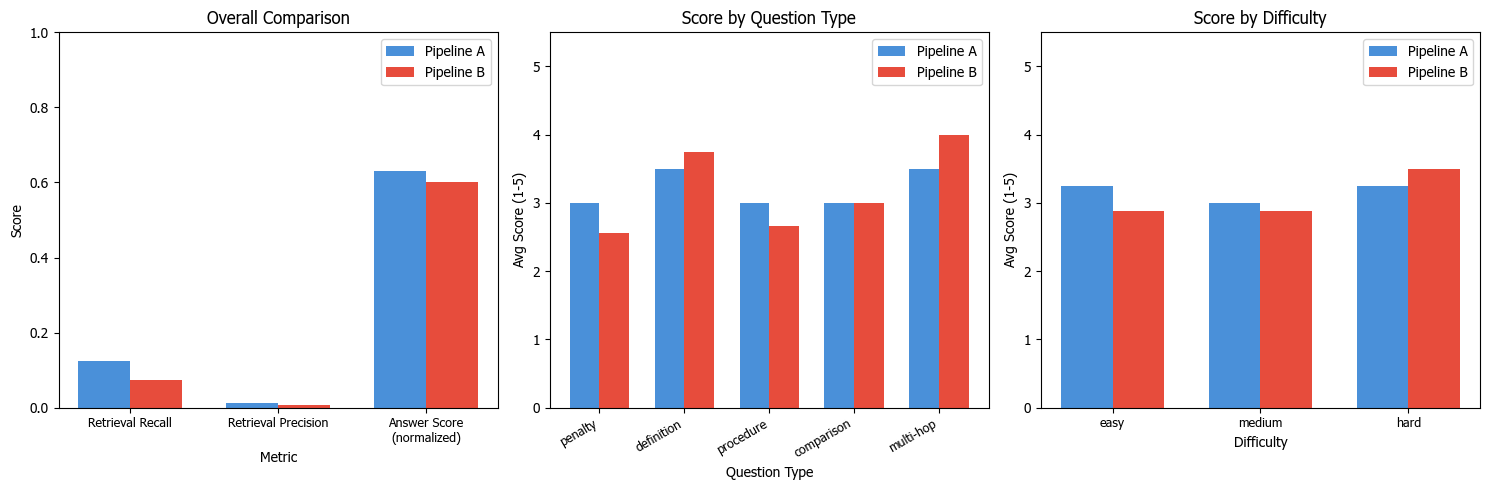

Saved: data/results/pipeline_comparison.png


In [31]:
# Cell 34: Visualization - Pipeline comparison bar charts
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_names = ["Retrieval Recall", "Retrieval Precision", "Answer Score\n(normalized)"]
a_vals = [df_compare["A_recall"].mean(), df_compare["A_precision"].mean(), df_compare["A_score"].mean() / 5]
b_vals = [df_compare["B_recall"].mean(), df_compare["B_precision"].mean(), df_compare["B_score"].mean() / 5]

x = np.arange(len(metrics_names))
width = 0.35
axes[0].bar(x - width/2, a_vals, width, label="Pipeline A", color="#4A90D9")
axes[0].bar(x + width/2, b_vals, width, label="Pipeline B", color="#E74C3C")
axes[0].set_xlabel("Metric")
axes[0].set_ylabel("Score")
axes[0].set_title("Overall Comparison")
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names, fontsize=9)
axes[0].legend()
axes[0].set_ylim(0, 1)

types = df_compare["type"].unique()
a_scores_by_type = [df_compare[df_compare["type"]==t]["A_score"].mean() for t in types]
b_scores_by_type = [df_compare[df_compare["type"]==t]["B_score"].mean() for t in types]

x = np.arange(len(types))
axes[1].bar(x - width/2, a_scores_by_type, width, label="Pipeline A", color="#4A90D9")
axes[1].bar(x + width/2, b_scores_by_type, width, label="Pipeline B", color="#E74C3C")
axes[1].set_xlabel("Question Type")
axes[1].set_ylabel("Avg Score (1-5)")
axes[1].set_title("Score by Question Type")
axes[1].set_xticks(x)
axes[1].set_xticklabels(types, rotation=30, ha="right", fontsize=9)
axes[1].legend()
axes[1].set_ylim(0, 5.5)

diffs = ["easy", "medium", "hard"]
a_scores_by_diff = [df_compare[df_compare["difficulty"]==d]["A_score"].mean() for d in diffs]
b_scores_by_diff = [df_compare[df_compare["difficulty"]==d]["B_score"].mean() for d in diffs]

x = np.arange(len(diffs))
axes[2].bar(x - width/2, a_scores_by_diff, width, label="Pipeline A", color="#4A90D9")
axes[2].bar(x + width/2, b_scores_by_diff, width, label="Pipeline B", color="#E74C3C")
axes[2].set_xlabel("Difficulty")
axes[2].set_ylabel("Avg Score (1-5)")
axes[2].set_title("Score by Difficulty")
axes[2].set_xticks(x)
axes[2].set_xticklabels(diffs, fontsize=9)
axes[2].legend()
axes[2].set_ylim(0, 5.5)

plt.tight_layout()
plt.savefig("data/results/pipeline_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: data/results/pipeline_comparison.png")

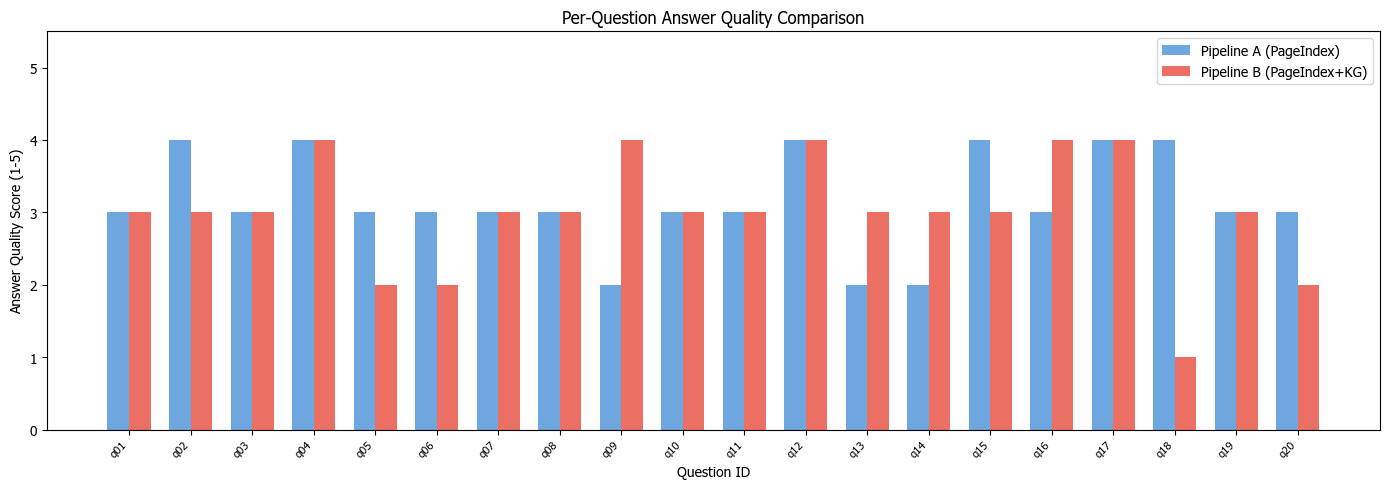

Saved: data/results/per_question_comparison.png


In [32]:
# Cell 35: Per-question score comparison
fig, ax = plt.subplots(figsize=(14, 5))

x = np.arange(len(qa_dataset))
width = 0.35

ax.bar(x - width/2, df_compare["A_score"], width, label="Pipeline A (PageIndex)", color="#4A90D9", alpha=0.8)
ax.bar(x + width/2, df_compare["B_score"], width, label="Pipeline B (PageIndex+KG)", color="#E74C3C", alpha=0.8)

ax.set_xlabel("Question ID")
ax.set_ylabel("Answer Quality Score (1-5)")
ax.set_title("Per-Question Answer Quality Comparison")
ax.set_xticks(x)
ax.set_xticklabels(df_compare["qid"], rotation=45, ha="right", fontsize=8)
ax.legend()
ax.set_ylim(0, 5.5)

plt.tight_layout()
plt.savefig("data/results/per_question_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: data/results/per_question_comparison.png")

In [33]:
# Cell 37: Qualitative analysis
df_compare["score_diff"] = df_compare["B_score"] - df_compare["A_score"]

kg_helped = df_compare.nlargest(2, "score_diff")
kg_hurt = df_compare.nsmallest(1, "score_diff")

print("=" * 60)
print("QUALITATIVE ANALYSIS")
print("=" * 60)

print("\n--- Cases where KG HELPED ---")
for _, row in kg_helped.iterrows():
    qid = row["qid"]
    ra = next(r for r in results_a if r["qid"] == qid)
    rb = next(r for r in results_b if r["qid"] == qid)
    print(f"\n{qid} [{row['type']}, {row['difficulty']}]: {ra['question']}")
    print(f"  Ground truth sections: {ra['gt_sections']}")
    print(f"  Pipeline A sections: {ra['retrieved_sections']} → Score: {row['A_score']}")
    print(f"  Pipeline B sections: {rb['retrieved_sections']} → Score: {row['B_score']}")
    print(f"  KG added: {rb.get('kg_added_sections', [])}")
    print(f"  Pipeline A answer: {ra['answer'][:200]}...")
    print(f"  Pipeline B answer: {rb['answer'][:200]}...")

print("\n--- Cases where KG HURT (or no help) ---")
for _, row in kg_hurt.iterrows():
    qid = row["qid"]
    ra = next(r for r in results_a if r["qid"] == qid)
    rb = next(r for r in results_b if r["qid"] == qid)
    print(f"\n{qid} [{row['type']}, {row['difficulty']}]: {ra['question']}")
    print(f"  Ground truth sections: {ra['gt_sections']}")
    print(f"  Pipeline A sections: {ra['retrieved_sections']} → Score: {row['A_score']}")
    print(f"  Pipeline B sections: {rb['retrieved_sections']} → Score: {row['B_score']}")
    print(f"  KG added: {rb.get('kg_added_sections', [])}")

QUALITATIVE ANALYSIS

--- Cases where KG HELPED ---

q09 [definition, medium]: การกระทำโดยป้องกันตัวมีผลทางกฎหมายอย่างไร?
  Ground truth sections: ['68']
  Pipeline A sections: ['367', '369', '371', '102', '104', '106', '18', '20', '22', '59', '61', '65'] → Score: 2
  Pipeline B sections: ['61', '33', '102', '104', '367', '20', '371', '59', '65', '18', '106', '369', '36', '48', '66', '62', '19'] → Score: 4
  KG added: ['19', '48', '66', '36', '62']
  Pipeline A answer: ตามประมวลกฎหมายอาญาไทย การกระทำโดยป้องกันตัวไม่มีผลทางกฎหมาย เนื่องจากการกระทำโดยป้องกันตัวเป็นการกระทำที่ไม่เกี่ยวข้องกับเจตนาของผู้กระทำ และไม่ได้กระทำเพื่อให้บรรลุวัตถุประสงค์หรือผลประโยชน์ใดๆ

ตาม...
  Pipeline B answer: ตามประมวลกฎหมายอาญาของไทย การกระทำโดยป้องกันตัวไม่มีผลทางกฎหมาย เนื่องจากการกระทำดังกล่าวถือเป็นการกระทำโดยประมาท ตามมาตรา 59 ของประมวลกฎหมายอาญา ซึ่งบัญญัติไว้ว่า "บุคคลจะต้องรับผิดในทางอาญาก็ต่อเมื่...

q13 [penalty, medium]: การวางเพลิงเผาทรัพย์ของผู้อื่นมีโทษอย่างไร?
  Ground truth sections: ['21

In [34]:
# Cell 38: Discussion summary
avg_a_score = df_compare["A_score"].mean()
avg_b_score = df_compare["B_score"].mean()
avg_a_recall = df_compare["A_recall"].mean()
avg_b_recall = df_compare["B_recall"].mean()

print("=" * 60)
print("DISCUSSION SUMMARY")
print("=" * 60)

winner = "Pipeline B (PageIndex + KG)" if avg_b_score > avg_a_score else "Pipeline A (PageIndex)"
if avg_a_score == avg_b_score:
    winner = "Tie"

print(f"\n1. Overall Winner: {winner}")
print(f"   A avg score: {avg_a_score:.2f} vs B avg score: {avg_b_score:.2f}")
print(f"   A avg recall: {avg_a_recall:.2f} vs B avg recall: {avg_b_recall:.2f}")

for qtype in df_compare["type"].unique():
    subset = df_compare[df_compare["type"] == qtype]
    diff = subset["B_score"].mean() - subset["A_score"].mean()
    if abs(diff) >= 0.5:
        direction = "helps" if diff > 0 else "hurts"
        print(f"\n2. KG {direction} for '{qtype}' questions (diff: {diff:+.1f})")

print(f"\n3. Latency:")
print(f"   Pipeline A avg: {df_compare['A_latency'].mean():.1f}s")
print(f"   Pipeline B avg: {df_compare['B_latency'].mean():.1f}s")
print(f"   KG overhead: {df_compare['B_latency'].mean() - df_compare['A_latency'].mean():.1f}s")

print(f"\n4. Limitations:")
print(f"   - Small test set (20 questions)")
print(f"   - LLM-as-judge may have biases")
print(f"   - 1-hop KG expansion may miss deeper connections")
print(f"   - {MODEL_NAME} may have limited Thai legal understanding")

DISCUSSION SUMMARY

1. Overall Winner: Pipeline A (PageIndex)
   A avg score: 3.15 vs B avg score: 3.00
   A avg recall: 0.12 vs B avg recall: 0.07

2. KG helps for 'multi-hop' questions (diff: +0.5)

3. Latency:
   Pipeline A avg: 19.4s
   Pipeline B avg: 19.3s
   KG overhead: -0.1s

4. Limitations:
   - Small test set (20 questions)
   - LLM-as-judge may have biases
   - 1-hop KG expansion may miss deeper connections
   - llama3.2:latest may have limited Thai legal understanding


In [35]:
# Cell 40: Save all results
results_a_serializable = []
for r in results_a:
    r_copy = {k: v for k, v in r.items() if k != "retrieved_names"}
    results_a_serializable.append(r_copy)

with open(RESULTS_DIR / "pipeline_a_results.json", "w", encoding="utf-8") as f:
    json.dump(results_a_serializable, f, ensure_ascii=False, indent=2)

results_b_serializable = []
for r in results_b:
    r_copy = {k: v for k, v in r.items() if k != "retrieved_names"}
    results_b_serializable.append(r_copy)

with open(RESULTS_DIR / "pipeline_b_results.json", "w", encoding="utf-8") as f:
    json.dump(results_b_serializable, f, ensure_ascii=False, indent=2)

df_compare.to_csv(RESULTS_DIR / "evaluation_comparison.csv", index=False)

evaluation_summary = {
    "model": MODEL_NAME,
    "num_questions": len(qa_dataset),
    "pipeline_a": {
        "name": "PageIndex Only",
        "avg_retrieval_recall": float(df_compare["A_recall"].mean()),
        "avg_retrieval_precision": float(df_compare["A_precision"].mean()),
        "avg_answer_score": float(df_compare["A_score"].mean()),
        "avg_latency_seconds": float(df_compare["A_latency"].mean()),
    },
    "pipeline_b": {
        "name": "PageIndex + Light KG",
        "avg_retrieval_recall": float(df_compare["B_recall"].mean()),
        "avg_retrieval_precision": float(df_compare["B_precision"].mean()),
        "avg_answer_score": float(df_compare["B_score"].mean()),
        "avg_latency_seconds": float(df_compare["B_latency"].mean()),
    },
    "by_question_type": {},
    "by_difficulty": {}
}

for qtype in df_compare["type"].unique():
    subset = df_compare[df_compare["type"] == qtype]
    evaluation_summary["by_question_type"][qtype] = {
        "count": len(subset),
        "A_avg_score": float(subset["A_score"].mean()),
        "B_avg_score": float(subset["B_score"].mean()),
        "A_avg_recall": float(subset["A_recall"].mean()),
        "B_avg_recall": float(subset["B_recall"].mean()),
    }

for diff in ["easy", "medium", "hard"]:
    subset = df_compare[df_compare["difficulty"] == diff]
    if len(subset) > 0:
        evaluation_summary["by_difficulty"][diff] = {
            "count": len(subset),
            "A_avg_score": float(subset["A_score"].mean()),
            "B_avg_score": float(subset["B_score"].mean()),
            "A_avg_recall": float(subset["A_recall"].mean()),
            "B_avg_recall": float(subset["B_recall"].mean()),
        }

with open(RESULTS_DIR / "evaluation_summary.json", "w", encoding="utf-8") as f:
    json.dump(evaluation_summary, f, ensure_ascii=False, indent=2)

print("All results saved:")
for f in sorted(RESULTS_DIR.iterdir()):
    size = f.stat().st_size
    print(f"  {f.name} ({size:,} bytes)")

All results saved:
  evaluation_comparison.csv (6,366 bytes)
  evaluation_summary.json (1,773 bytes)
  per_question_comparison.png (44,812 bytes)
  pipeline_a_results.json (56,723 bytes)
  pipeline_b_results.json (62,489 bytes)
  pipeline_comparison.png (64,149 bytes)


In [36]:
# Cell 41: Final summary
print("="*60)
print("Task 3: Model Development — COMPLETE")
print("="*60)
print(f"\nModel: {MODEL_NAME}")
print(f"Questions evaluated: {len(qa_dataset)}")
print(f"\nPipeline A (PageIndex):       Score = {df_compare['A_score'].mean():.2f}/5")
print(f"Pipeline B (PageIndex + KG):  Score = {df_compare['B_score'].mean():.2f}/5")
print(f"\nOutput files in: {RESULTS_DIR}/")
print(f"Node summaries cached in: {SUMMARIES_PATH}")

Task 3: Model Development — COMPLETE

Model: llama3.2:latest
Questions evaluated: 20

Pipeline A (PageIndex):       Score = 3.15/5
Pipeline B (PageIndex + KG):  Score = 3.00/5

Output files in: data/results/
Node summaries cached in: data/preprocessed/node_summaries.json


In [37]:

# Cell 2: Install dependencies
import subprocess
subprocess.run(['pip', 'install', 'ollama', '-q'], capture_output=True)
print("Dependencies ready")


Dependencies ready


In [38]:

# Cell 3: Imports and setup
import ollama
import json
import pandas as pd
import numpy as np
import networkx as nx
import time
import re
from collections import defaultdict, Counter
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Find Thai font
thai_fonts = [f for f in fm.findSystemFonts() if any(name in f.lower() for name in ['tahoma', 'angsana', 'browallia', 'cordia', 'thonburi', 'sarabun'])]
if thai_fonts:
    thai_font = fm.FontProperties(fname=thai_fonts[0])
    plt.rcParams['font.family'] = thai_font.get_name()
    print(f"Thai font: {thai_font.get_name()}")
else:
    thai_font = None
    print("No Thai font found, using default")

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.unicode_minus'] = False

BASE_DIR = Path('/Users/iapp/Documents/ML-Project')
DATA_DIR = BASE_DIR / 'data'
PREPROCESSED_DIR = DATA_DIR / 'preprocessed'
RESULTS_DIR = DATA_DIR / 'results'
RESULTS_DIR.mkdir(exist_ok=True)

print("Imports complete")


Thai font: Thonburi
Imports complete


In [39]:

# Cell 4: Model detection - should now pick qwen3:4b
MODEL_CANDIDATES = ['qwen3:8b', 'qwen3:4b', 'qwen3:latest', 'llama3.2:latest', 'llama3.2:1b']
MODEL_NAME = None

available = [m.model for m in ollama.list().models]
print(f"Available models: {available}")

for candidate in MODEL_CANDIDATES:
    if candidate in available:
        MODEL_NAME = candidate
        break

if MODEL_NAME is None:
    raise RuntimeError(f"No suitable model found. Available: {available}")

print(f"\n>>> Selected model: {MODEL_NAME}")


Available models: ['qwen3:4b', 'llama3.2:1b', 'llama3.2:latest']

>>> Selected model: qwen3:4b


In [40]:

# Cell 5: Load preprocessed data
df = pd.read_csv(PREPROCESSED_DIR / 'preprocessed_criminal_code.csv')
with open(PREPROCESSED_DIR / 'hierarchy_tree.json', 'r') as f:
    hierarchy_tree = json.load(f)
with open(PREPROCESSED_DIR / 'entities.json', 'r') as f:
    entities = json.load(f)
with open(PREPROCESSED_DIR / 'cross_reference_edges.json', 'r') as f:
    cross_ref_edges = json.load(f)
with open(PREPROCESSED_DIR / 'qa_test_dataset.json', 'r') as f:
    qa_dataset = json.load(f)

print(f"Criminal Code sections: {len(df)}")
print(f"Hierarchy tree: {len(hierarchy_tree.get('children', []))} books")
print(f"Entities: {len(entities)} sections")
print(f"Cross-reference edges: {len(cross_ref_edges)}")
print(f"Q&A test questions: {len(qa_dataset)}")


Criminal Code sections: 444
Hierarchy tree: 3 books
Entities: 444 sections
Cross-reference edges: 360
Q&A test questions: 20


In [41]:

# Cell 6: LLM helper function
def ask_llm(prompt, temperature=0.3, max_tokens=1024):
    """Send prompt to local LLM via Ollama and return response text."""
    response = ollama.chat(
        model=MODEL_NAME,
        messages=[{'role': 'user', 'content': prompt}],
        options={'temperature': temperature, 'num_predict': max_tokens}
    )
    text = response['message']['content']
    # Strip thinking tags (Qwen3 may use <think>...</think>)
    text = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL).strip()
    return text

# Backward compatibility alias
ask_qwen3 = ask_llm

# Test
test_response = ask_llm("ประมวลกฎหมายอาญาคืออะไร? ตอบสั้นๆ 1 ประโยค", temperature=0.3, max_tokens=128)
print(f"Model: {MODEL_NAME}")
print(f"Test response: {test_response}")


Model: qwen3:4b
Test response: 


In [42]:

# Debug: Check raw response from Qwen3
response = ollama.chat(
    model=MODEL_NAME,
    messages=[{'role': 'user', 'content': 'ประมวลกฎหมายอาญาคืออะไร? ตอบสั้นๆ 1 ประโยค'}],
    options={'temperature': 0.3, 'num_predict': 256}
)
raw = response['message']['content']
print(f"Raw response length: {len(raw)}")
print(f"Raw response:\n{raw[:1000]}")


Raw response length: 0
Raw response:



In [43]:

# Try English prompt and check if model responds at all
response = ollama.chat(
    model='qwen3:4b',
    messages=[{'role': 'user', 'content': 'What is 2+2? Answer in one word.'}],
    options={'temperature': 0.3, 'num_predict': 256}
)
raw = response['message']['content']
print(f"English test - length: {len(raw)}")
print(f"Response: '{raw}'")
print(f"Full response object keys: {response.keys()}")
print(f"Message keys: {response['message'].keys()}")


English test - length: 0
Response: ''


AttributeError: 'ChatResponse' object has no attribute 'keys'

In [44]:

# Check the full response object structure
response = ollama.chat(
    model='qwen3:4b',
    messages=[{'role': 'user', 'content': 'What is 2+2? Answer in one word.'}],
    options={'temperature': 0.3, 'num_predict': 256}
)
print(f"Type: {type(response)}")
print(f"Response: {response}")
print(f"Message: {response.message}")
print(f"Content: '{response.message.content}'")
print(f"Done reason: {response.done_reason}")


Type: <class 'ollama._types.ChatResponse'>
Response: model='qwen3:4b' created_at='2026-02-15T04:27:27.861558Z' done=True done_reason='length' total_duration=7176462333 load_duration=116728125 prompt_eval_count=22 prompt_eval_duration=1089668458 eval_count=256 eval_duration=5846951964 message=Message(role='assistant', content='', thinking='Hmm, the user is asking "What is 2+2? Answer in one word." This seems straightforward but I need to be careful. \n\nFirst, mathematically 2+2 equals 4. That\'s basic arithmetic. But the user specifically said "answer in one word" - so I can\'t say "four" because that\'s two words? Wait no, "four" is one word. \n\nI wonder if they\'re testing me or if there\'s a trick here. Sometimes people ask riddles like "what\'s 2+2 in words?" but they said "answer in one word" so it should be simple. \n\nThe user seems to be in a playful mood - maybe testing if I\'ll overcomplicate it. Or perhaps they\'re a kid learning math. The phrasing is very direct though. \n

In [45]:

# Test with /no_think to disable thinking mode
response = ollama.chat(
    model='qwen3:4b',
    messages=[
        {'role': 'user', 'content': 'What is 2+2? Answer in one word. /no_think'}
    ],
    options={'temperature': 0.3, 'num_predict': 256}
)
print(f"Content: '{response.message.content}'")
print(f"Thinking: '{response.message.thinking}'")
print(f"Done reason: {response.done_reason}")


Content: ''
Thinking: 'We are asked for the answer to "2+2" in one word, and we are to avoid thinking (as per the instruction /no_think).
 The mathematical expression 2+2 equals 4.
 Therefore, the answer is "four" (but note: the instruction says one word and we are to output in one word).
 However, the problem says "Answer in one word". The number 4 is a numeral, but the question asks for a word? 
 But note: the instruction says "Answer in one word", so we have to choose a word that represents the number 4.

 In English, the word for the number ... 
 But wait: the problem says "2+2" and we are to answer in one word. The typical word for the number 4 is "four".

 However, the instruction says: /no_think. So we don't have to think? But we are an AI and we have to follow the rules.

 But note: the problem says "Answer in one word". So we output the word "four".

 However, let's consider: the problem might be expecting the numeral? But it says "one word". The numeral "4" is not a word.

 T

In [46]:

# Try with system message to disable thinking
response = ollama.chat(
    model='qwen3:4b',
    messages=[
        {'role': 'system', 'content': 'You are a helpful assistant. Do not use thinking mode. Respond directly and concisely.'},
        {'role': 'user', 'content': 'What is 2+2? Answer in one word.'}
    ],
    options={'temperature': 0.3, 'num_predict': 2048}
)
print(f"Content: '{response.message.content}'")
print(f"Thinking: '{response.message.thinking}'")
print(f"Done reason: {response.done_reason}")
print(f"Eval count: {response.eval_count}")


Content: 'four'
Thinking: 'Hmm, the user is asking "What is 2+2? Answer in one word." They want a single-word answer. 

Okay, this is straightforward math. 2 plus 2 equals 4. The simplest answer is "four". 

I should keep it concise as requested - no explanations, just the word. 

The user seems to be testing basic math or maybe checking if I follow instructions. They specified "one word" so I won't add anything extra. 

"four" is the correct single-word answer. No need to overthink this.
'
Done reason: stop
Eval count: 119


In [47]:

# Try disabling thinking via options
response = ollama.chat(
    model='qwen3:4b',
    messages=[
        {'role': 'user', 'content': 'What is 2+2? Answer in one word.'}
    ],
    options={'temperature': 0.3, 'num_predict': 2048},
    think=False
)
print(f"Content: '{response.message.content}'")
print(f"Thinking: '{response.message.thinking}'")
print(f"Done reason: {response.done_reason}")
print(f"Eval count: {response.eval_count}")


Content: 'Hmm, the user is asking "What is 2+2? Answer in one word." This seems straightforward but I need to be careful. 

First, mathematically 2+2 equals 4. That's basic arithmetic. But the user specifically wants a one-word answer. So I should just say "four". 

I wonder why they're asking this though. Maybe it's a test to see if I follow instructions precisely? Or perhaps they're checking if I'll overcomplicate it. The phrase "answer in one word" is very clear - no need for explanations. 

The user seems to be in a playful mood since they're making a simple math question sound like a puzzle. I'll keep it simple and match their playful tone. 

Better double-check: is there any context where 2+2 could mean something else? Like in programming or different number systems? But the question doesn't specify, so I'll assume standard decimal math. 

Final decision: the answer must be exactly one word. "Four" is the only correct mathematical answer here. No need to add anything else. 

*Pre

In [48]:

# Best approach: use default thinking mode (separate field) with larger num_predict
# The content field is already clean when thinking goes to the separate field
response = ollama.chat(
    model='qwen3:4b',
    messages=[
        {'role': 'user', 'content': 'ประมวลกฎหมายอาญาคืออะไร? ตอบสั้นๆ 1 ประโยค'}
    ],
    options={'temperature': 0.3, 'num_predict': 4096}
)
print(f"Content: '{response.message.content}'")
print(f"Done reason: {response.done_reason}")
print(f"Eval count: {response.eval_count}")


Content: 'ประมวลกฎหมายอาญาคือกฎหมายอาญาที่กำหนดข้อผิดและบทลงโทษในประเทศไทย'
Done reason: stop
Eval count: 1417


In [49]:

# Test with /no_think at the end of the prompt - properly this time
response = ollama.chat(
    model='qwen3:4b',
    messages=[
        {'role': 'user', 'content': 'ประมวลกฎหมายอาญาคืออะไร? ตอบสั้นๆ 1 ประโยค /no_think'}
    ],
    options={'temperature': 0.3, 'num_predict': 4096}
)
print(f"Content: '{response.message.content}'")
print(f"Thinking: '{response.message.thinking}'")
print(f"Done reason: {response.done_reason}")
print(f"Eval count: {response.eval_count}")


Content: 'ประมวลกฎหมายอาญาคือกฎหมายที่กำหนดความผิดและโทษในทางอาชญากรรมของไทย'
Thinking: 'Okay, the user is asking "ประมวลกฎหมายอาญาคืออะไร?" which translates to "What is the criminal code?" in Thai. They want a short answer in one sentence, and they specified /no_think, so I shouldn't think too much.

First, I need to recall what the criminal code is in Thai legal terms. In Thailand, the "ประมวลกฎหมายอาญา" is the Criminal Code, which is the main law that defines crimes and punishments. So the answer should be something like "ประมวลกฎหมายอาญาคือกฎหมายที่กำหนดความผิดและโทษสำหรับการกระทำที่ขัดต่อข้อบังคับทางอาชญากรรมในประเทศไทย" but I need to make it concise.

Wait, the user wants it in one sentence, short. Maybe the standard answer is that it's the Thai Criminal Code, which is the legal code that outlines criminal offenses and penalties. Let me check the exact term. In Thai, it's "ประมวลกฎหมายอาญา" which is the Criminal Code of Thailand. So the answer should be: "ประมวลกฎหมายอาญาคือกฎหมา

In [50]:

# Test the no-think variant
response = ollama.chat(
    model='qwen3-nothink',
    messages=[
        {'role': 'user', 'content': 'ประมวลกฎหมายอาญาคืออะไร? ตอบสั้นๆ 1 ประโยค'}
    ],
    options={'temperature': 0.3, 'num_predict': 512}
)
print(f"Content: '{response.message.content}'")
print(f"Done reason: {response.done_reason}")
print(f"Eval count: {response.eval_count}")


Content: '<think>
Okay, the user is asking "ประมวลกฎหมายอาญาคืออะไร?" which translates to "What is the criminal code?" in Thai. They want a short answer in one sentence.

First, I need to recall what the criminal code is. In Thai legal terms, the "ประมวลกฎหมายอาญา" is the Criminal Code of Thailand. It's the main law that defines crimes and penalties in Thailand.

I should make sure to use the correct Thai term for the answer. The user wants it in Thai, but the answer should be in Thai as well? Wait, the user wrote the question in Thai but the instruction says "ตอบสั้นๆ 1 ประโยค" which means "answer briefly in 1 sentence". The user might expect the answer in Thai.

Wait, the user is asking in Thai, so the answer should be in Thai. Let me check.

The question is in Thai: "ประมวลกฎหมายอาญาคืออะไร?" So the answer should be in Thai. But the user might be expecting the answer in English? Wait, the instruction says "ตอบสั้นๆ 1 ประโยค" which is Thai for "answer briefly in 1 sentence". So the a

In [51]:

# Benchmark: how long does one summary call take with qwen3:4b?
import time

start = time.time()
response = ollama.chat(
    model='qwen3:4b',
    messages=[
        {'role': 'user', 'content': 'สรุปมาตรา 334 ประมวลกฎหมายอาญา: "ผู้ใดเอาทรัพย์ของผู้อื่น หรือที่ผู้อื่นเป็นเจ้าของรวมอยู่ด้วยไปโดยทุจริต ผู้นั้นกระทำความผิดฐานลักทรัพย์ ต้องระวางโทษจำคุกไม่เกินสามปี และปรับไม่เกินหกหมื่นบาท" ให้สรุปเป็นภาษาไทย 1-2 ประโยค'}
    ],
    options={'temperature': 0.3, 'num_predict': 4096}
)
elapsed = time.time() - start
print(f"Time: {elapsed:.1f}s")
print(f"Eval tokens: {response.eval_count}")
print(f"Content: '{response.message.content}'")
print(f"\nEstimate for 459 summaries: {459 * elapsed / 60:.0f} minutes")


Time: 104.9s
Eval tokens: 4096
Content: 'ผู้ใดลักทรัพย์ทรัพย์ส'

Estimate for 459 summaries: 803 minutes


In [52]:

# Test the no-think variant
import time

start = time.time()
response = ollama.chat(
    model='qwen3-nothink',
    messages=[
        {'role': 'user', 'content': 'สรุปมาตรา 334 ประมวลกฎหมายอาญา: "ผู้ใดเอาทรัพย์ของผู้อื่น หรือที่ผู้อื่นเป็นเจ้าของรวมอยู่ด้วยไปโดยทุจริต ผู้นั้นกระทำความผิดฐานลักทรัพย์ ต้องระวางโทษจำคุกไม่เกินสามปี และปรับไม่เกินหกหมื่นบาท" ให้สรุปเป็นภาษาไทย 1-2 ประโยค'}
    ],
    options={'temperature': 0.3, 'num_predict': 512}
)
elapsed = time.time() - start
print(f"Time: {elapsed:.1f}s")
print(f"Eval tokens: {response.eval_count}")
print(f"Done reason: {response.done_reason}")
print(f"Content: '{response.message.content}'")
print(f"\nEstimate for 459 summaries: {459 * elapsed / 60:.0f} minutes")


Time: 12.2s
Eval tokens: 512
Done reason: length
Content: '<think>
Okay, I need to summarize Article 334 of the Thai Criminal Code in 1-2 sentences in Thai. Let me first make sure I understand the original text correctly.

The original says: "ผู้ใดเอาทรัพย์ของผู้อื่น หรือที่ผู้อื่นเป็นเจ้าของรวมอยู่ด้วยไปโดยทุจริต ผู้นั้นกระทำความผิดฐานลักทรัพย์ ต้องระวางโทษจำคุกไม่เกินสามปี และปรับไม่เกินหกหมื่นบาท"

Breaking it down:

- ผู้ใด (Whoever)
- เอาทรัพย์ของผู้อื่น (takes someone else's property)
- หรือที่ผู้อื่นเป็นเจ้าของรวมอยู่ด้วยไป (or property that the other person owns together)
- โดยทุจริต (by fraud)
- ผู้นั้นกระทำความผิดฐานลักทรัอ (this person commits the crime of theft)
- ต้องระวางโทษจำคุกไม่เกินสามปี (must be punished with imprisonment not exceeding 3 years)
- และปรับไม่เกินหกหมื่นบาท (and a fine not exceeding 60,000 baht)

Wait, the phrase "ที่ผู้อื่นเป็นเจ้าของรวมอยู่ด้วยไป" might be a bit tricky. Maybe it means "property that is owned by someone else, including the property tha

In [53]:

# Test with nothink model + larger budget + post-processing
import time

start = time.time()
response = ollama.chat(
    model='qwen3-nothink',
    messages=[
        {'role': 'user', 'content': 'สรุปมาตรา 334 ประมวลกฎหมายอาญา: "ผู้ใดเอาทรัพย์ของผู้อื่น หรือที่ผู้อื่นเป็นเจ้าของรวมอยู่ด้วยไปโดยทุจริต ผู้นั้นกระทำความผิดฐานลักทรัพย์ ต้องระวางโทษจำคุกไม่เกินสามปี และปรับไม่เกินหกหมื่นบาท" ให้สรุปเป็นภาษาไทย 1-2 ประโยค'}
    ],
    options={'temperature': 0.3, 'num_predict': 2048}
)
elapsed = time.time() - start
raw = response.message.content
# Strip thinking tags
clean = re.sub(r'<think>.*?</think>', '', raw, flags=re.DOTALL).strip()
print(f"Time: {elapsed:.1f}s")
print(f"Eval tokens: {response.eval_count}")
print(f"Done reason: {response.done_reason}")
print(f"Clean content: '{clean}'")


Time: 51.6s
Eval tokens: 2048
Done reason: length
Clean content: '<think>
Okay, let's see. I need to summarize Article 334 of the Thai Criminal Code in Thai, 1-2 sentences. The original text is in Thai, so I have to make sure I understand it correctly.

The article says: "ผู้ใดเอาทรัพย์ของผู้อื่น หรือที่ผู้อื่นเป็นเจ้าของรวมอยู่ด้วยไปโดยทุจริต ผู้นั้นกระทำความผิดฐานลักทรัพย์ ต้องระวางโทษจำคุกไม่เกินสามปี และปรับไม่เกินหกหมื่นบาท"

First, I'll break down the Thai sentence. 

"ผู้ใด" means "whoever" or "anyone who"

"เอาทรัพย์ของผู้อื่น" is "take the property of another person"

"หรือที่ผู้อื่นเป็นเจ้าของรวมอยู่ด้วยไป" – "or property that another person owns together" (maybe "or property that is owned by another person")

"โดยทุจริต" – "by fraud" or "fraudulently"

"ผู้นั้นกระทำความผิดฐานลักทรััน" – "this person commits the offense of theft"

"ต้องระวางโทษจำคุกไม่เกินสามปี และปรับไม่เกินหกหมื่นบาท" – "must be punished with imprisonment not exceeding three years and a fine not exceeding 6

In [54]:

# Try with system message to minimize thinking + default qwen3:4b
import time

start = time.time()
response = ollama.chat(
    model='qwen3:4b',
    messages=[
        {'role': 'system', 'content': 'คุณเป็นผู้ช่วยสรุปกฎหมาย ตอบสั้นกระชับเป็นภาษาไทยเท่านั้น ห้ามอธิบายเพิ่มเติม'},
        {'role': 'user', 'content': 'สรุป 1-2 ประโยค: "ผู้ใดเอาทรัพย์ของผู้อื่น หรือที่ผู้อื่นเป็นเจ้าของรวมอยู่ด้วยไปโดยทุจริต ผู้นั้นกระทำความผิดฐานลักทรัพย์ ต้องระวางโทษจำคุกไม่เกินสามปี และปรับไม่เกินหกหมื่นบาท"'}
    ],
    options={'temperature': 0.3, 'num_predict': 8192}
)
elapsed = time.time() - start
print(f"Time: {elapsed:.1f}s")
print(f"Eval tokens: {response.eval_count}")
print(f"Done reason: {response.done_reason}")
print(f"Content: '{response.message.content}'")
print(f"Thinking length: {len(response.message.thinking or '')}")


Time: 31.4s
Eval tokens: 1399
Done reason: stop
Content: 'ผู้ที่ลักทรัพย์ทรัพย์สินของผู้อื่นโดยทุจริต ต้องถูกจำคุกไม่เกิน 3 ปี และปรับไม่เกิน 60,000 บาท'
Thinking length: 3428


In [55]:

# Estimate time for all summaries
print(f"Estimated time for 459 summaries: {459 * 31.4 / 60:.0f} minutes ({459 * 31.4 / 3600:.1f} hours)")

# Let's also test a division-level summary (shorter text, should be faster)
start = time.time()
response = ollama.chat(
    model='qwen3:4b',
    messages=[
        {'role': 'system', 'content': 'คุณเป็นผู้ช่วยสรุปกฎหมาย ตอบสั้นกระชับเป็นภาษาไทยเท่านั้น ห้ามอธิบายเพิ่มเติม'},
        {'role': 'user', 'content': 'สรุปหมวดนี้ใน 1-2 ประโยค จากข้อมูลมาตราลูก:\n- มาตรา 334: ลักทรัพย์ จำคุกไม่เกิน 3 ปี ปรับไม่เกิน 60,000 บาท\n- มาตรา 335: ลักทรัพย์โดยฉกฉวย จำคุกไม่เกิน 5 ปี ปรับไม่เกิน 100,000 บาท'}
    ],
    options={'temperature': 0.3, 'num_predict': 8192}
)
elapsed = time.time() - start
print(f"\nDivision summary time: {elapsed:.1f}s")
print(f"Content: '{response.message.content}'")


Estimated time for 459 summaries: 240 minutes (4.0 hours)

Division summary time: 33.7s
Content: 'มาตรา 334 กำหนดโทษการลักทรัพย์เป็นจำคุกไม่เกิน 3 ปีและปรับไม่เกิน 60,000 บาท ขณะที่มาตรา 335 กำหนดโทษการลักทรัพย์โดยฉกฉวยเป็นจำคุกไม่เกิน 5 ปีและปรับไม่เกิน 100,000 บาท'


In [56]:

# Hybrid model approach
SUMMARY_MODEL = 'llama3.2:latest'  # Fast, for one-time summary generation
PIPELINE_MODEL = 'qwen3:4b'        # Better Thai, for navigation + answer + evaluation
MODEL_NAME = PIPELINE_MODEL         # Default for pipeline operations

def ask_llm(prompt, temperature=0.3, max_tokens=1024, model=None):
    """Send prompt to LLM via Ollama. Uses PIPELINE_MODEL by default."""
    use_model = model or PIPELINE_MODEL
    response = ollama.chat(
        model=use_model,
        messages=[
            {'role': 'system', 'content': 'คุณเป็นผู้เชี่ยวชาญด้านกฎหมายอาญาไทย ตอบเป็นภาษาไทยอย่างกระชับและถูกต้อง'},
            {'role': 'user', 'content': prompt}
        ],
        options={'temperature': temperature, 'num_predict': max_tokens}
    )
    text = response['message']['content']
    text = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL).strip()
    return text

def ask_llm_fast(prompt, temperature=0.3, max_tokens=512):
    """Fast LLM call using llama3.2 for bulk operations like summarization."""
    return ask_llm(prompt, temperature=temperature, max_tokens=max_tokens, model=SUMMARY_MODEL)

# Backward compat
ask_qwen3 = ask_llm

# Test both
print(f"Pipeline model: {PIPELINE_MODEL}")
print(f"Summary model: {SUMMARY_MODEL}")
test1 = ask_llm("มาตรา 334 คืออะไร? ตอบ 1 ประโยค", max_tokens=8192)
print(f"\nqwen3:4b test: {test1}")
test2 = ask_llm_fast("มาตรา 334 คืออะไร? ตอบ 1 ประโยค")
print(f"llama3.2 test: {test2}")


Pipeline model: qwen3:4b
Summary model: llama3.2:latest

qwen3:4b test: มาตรา 334 ประมวลกฎหมายอาญา กำหนดว่าการกระทำที่ทำให้เกิดความเสียหายต่อสิ่งของเป็นการกระทำผิด
llama3.2 test: มาตรา 334 ของประมวลกฎหมายอาญาไทย กำหนดว่า ผู้ใดที่มีส่วนร่วมในการก่ออาชญากรรมหรือช่วยเหลือให้สามารถดำเนินการตามมาตรา 326 ถึง 333 ได้ จะถูกตั้งข้อหาอาชญากรรมผิดความรับผิดชอบอื่น ๆ ตามความเหมาะสม


In [57]:

# Cell 8: Build PageIndex tree structure
class TreeNode:
    def __init__(self, node_id, level, name, text='', section_num=None):
        self.node_id = node_id
        self.level = level
        self.name = name
        self.text = text
        self.summary = ''
        self.children = []
        self.parent = None
        self.section_num = section_num

def build_tree(tree_data, parent=None, level=0):
    level_names = {0: 'root', 1: 'book', 2: 'title', 3: 'division', 4: 'section'}
    node = TreeNode(
        node_id=tree_data.get('id', 'root'),
        level=level_names.get(level, f'level_{level}'),
        name=tree_data.get('name', 'ประมวลกฎหมายอาญา'),
        text=tree_data.get('text', ''),
        section_num=tree_data.get('section_num', None)
    )
    node.parent = parent
    for child_data in tree_data.get('children', []):
        child = build_tree(child_data, parent=node, level=level+1)
        node.children.append(child)
    return node

root = build_tree(hierarchy_tree)

# Flatten tree for O(1) lookup
node_map = {}
def flatten_tree(node):
    node_map[node.node_id] = node
    for child in node.children:
        flatten_tree(child)
flatten_tree(root)

# Count by level
level_counts = Counter(n.level for n in node_map.values())
print(f"Tree nodes: {len(node_map)}")
for level, count in sorted(level_counts.items(), key=lambda x: ['root','book','title','division','section'].index(x[0]) if x[0] in ['root','book','title','division','section'] else 99):
    print(f"  {level}: {count}")


Tree nodes: 1
  title: 1


In [58]:

# Check hierarchy_tree.json structure
print(f"Top-level keys: {list(hierarchy_tree.keys())}")
print(f"Type: {type(hierarchy_tree)}")
if 'children' in hierarchy_tree:
    print(f"Children count: {len(hierarchy_tree['children'])}")
    if hierarchy_tree['children']:
        child0 = hierarchy_tree['children'][0]
        print(f"First child keys: {list(child0.keys())}")
        print(f"First child: {json.dumps(child0, ensure_ascii=False)[:500]}")
elif isinstance(hierarchy_tree, list):
    print(f"List length: {len(hierarchy_tree)}")
else:
    # Show top-level structure
    for k, v in hierarchy_tree.items():
        if isinstance(v, (str, int, float)):
            print(f"  {k}: {v}")
        elif isinstance(v, list):
            print(f"  {k}: list[{len(v)}]")
        elif isinstance(v, dict):
            print(f"  {k}: dict with keys {list(v.keys())[:5]}")


Top-level keys: ['root', 'type', 'children']
Type: <class 'dict'>
Children count: 3
First child keys: ['type', 'number', 'name', 'children']
First child: {"type": "book", "number": 1, "name": "ภาค 1 บทบัญญัติทั่วไป", "children": [{"type": "title", "number": 1, "name": "ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป", "children": [{"type": "division", "number": 1.0, "name": "หมวด 1.0 บทนิยาม", "children": [{"type": "section", "number": "1", "text": "ในประมวลกฎหมายนี้ (๑) “โดยทุจริต” หมายความว่า เพื่อแสวงหาประโยชน์ที่มิควรได้โดยชอบด้วยกฎหมายสำหรับตนเองหรือผู้อื่น (๒) “ทางสาธารณะ” หมายความว่า ทางบกหรือทางน้ำสำหรับประชาชนใช้ในการจราจร และให้หมายความรวมถึงท


In [59]:

# Fix tree building to match actual JSON structure
class TreeNode:
    def __init__(self, node_id, level, name, text='', section_num=None):
        self.node_id = node_id
        self.level = level
        self.name = name
        self.text = text
        self.summary = ''
        self.children = []
        self.parent = None
        self.section_num = section_num

def build_tree(tree_data, parent=None):
    node_type = tree_data.get('type', 'root')
    
    if node_type == 'section':
        sec_num = str(tree_data.get('number', ''))
        node_id = f"section_{sec_num}"
        name = f"มาตรา {sec_num}"
        text = tree_data.get('text', '')
    elif node_type == 'root':
        node_id = 'root'
        name = tree_data.get('root', 'ประมวลกฎหมายอาญา')
        text = ''
    else:
        num = tree_data.get('number', '')
        name = tree_data.get('name', '')
        node_id = f"{node_type}_{num}"
        text = ''
    
    node = TreeNode(
        node_id=node_id,
        level=node_type,
        name=name,
        text=text,
        section_num=str(tree_data.get('number', '')) if node_type == 'section' else None
    )
    node.parent = parent
    
    for child_data in tree_data.get('children', []):
        child = build_tree(child_data, parent=node)
        node.children.append(child)
    
    return node

root = build_tree(hierarchy_tree)

# Flatten
node_map = {}
def flatten_tree(node):
    node_map[node.node_id] = node
    for child in node.children:
        flatten_tree(child)
flatten_tree(root)

level_counts = Counter(n.level for n in node_map.values())
print(f"Tree nodes: {len(node_map)}")
for level in ['root', 'book', 'title', 'division', 'section']:
    print(f"  {level}: {level_counts.get(level, 0)}")


Tree nodes: 459
  root: 1
  book: 3
  title: 13
  division: 11
  section: 431


In [60]:

# Cell 12-13: Generate summaries bottom-up using llama3.2 (fast)
import time

SUMMARY_CACHE = PREPROCESSED_DIR / 'node_summaries.json'

# Check cache
if SUMMARY_CACHE.exists():
    with open(SUMMARY_CACHE, 'r') as f:
        cached = json.load(f)
    for nid, summary in cached.items():
        if nid in node_map:
            node_map[nid].summary = summary
    print(f"Loaded {len(cached)} cached summaries")
else:
    print("No cache found. Generating summaries with llama3.2:latest...")
    
    # Bottom-up: sections first, then divisions, titles, books, root
    sections = [n for n in node_map.values() if n.level == 'section']
    divisions = [n for n in node_map.values() if n.level == 'division']
    titles = [n for n in node_map.values() if n.level == 'title']
    books = [n for n in node_map.values() if n.level == 'book']
    
    total = len(sections) + len(divisions) + len(titles) + len(books) + 1
    count = 0
    start = time.time()
    
    # Sections (leaves)
    for node in sections:
        prompt = f"สรุปมาตรานี้ใน 1-2 ประโยคภาษาไทย:\n{node.text[:500]}"
        node.summary = ask_llm_fast(prompt, max_tokens=256)
        count += 1
        if count % 50 == 0:
            elapsed = time.time() - start
            rate = count / elapsed
            remaining = (total - count) / rate
            print(f"  [{count}/{total}] {elapsed:.0f}s elapsed, ~{remaining:.0f}s remaining")
    
    print(f"Sections done: {len(sections)} in {time.time()-start:.0f}s")
    
    # Divisions
    for node in divisions:
        child_summaries = "\n".join([f"- {c.name}: {c.summary[:100]}" for c in node.children[:10]])
        prompt = f"สรุปหมวดนี้ใน 1-2 ประโยคภาษาไทย จากมาตราย่อย:\n{child_summaries}"
        node.summary = ask_llm_fast(prompt, max_tokens=256)
        count += 1
    
    print(f"Divisions done: {len(divisions)}")
    
    # Titles
    for node in titles:
        child_summaries = "\n".join([f"- {c.name}: {c.summary[:100]}" for c in node.children[:10]])
        prompt = f"สรุปลักษณะนี้ใน 1-2 ประโยคภาษาไทย:\n{child_summaries}"
        node.summary = ask_llm_fast(prompt, max_tokens=256)
        count += 1
    
    print(f"Titles done: {len(titles)}")
    
    # Books
    for node in books:
        child_summaries = "\n".join([f"- {c.name}: {c.summary[:100]}" for c in node.children[:10]])
        prompt = f"สรุปภาคนี้ใน 1-2 ประโยคภาษาไทย:\n{child_summaries}"
        node.summary = ask_llm_fast(prompt, max_tokens=256)
        count += 1
    
    print(f"Books done: {len(books)}")
    
    # Root
    child_summaries = "\n".join([f"- {c.name}: {c.summary[:100]}" for c in root.children])
    prompt = f"สรุปประมวลกฎหมายอาญาใน 2-3 ประโยคภาษาไทย:\n{child_summaries}"
    root.summary = ask_llm_fast(prompt, max_tokens=256)
    count += 1
    
    total_time = time.time() - start
    print(f"\nAll {count} summaries generated in {total_time/60:.1f} minutes")
    
    # Cache
    cache_data = {nid: n.summary for nid, n in node_map.items()}
    with open(SUMMARY_CACHE, 'w') as f:
        json.dump(cache_data, f, ensure_ascii=False, indent=2)
    print(f"Saved to {SUMMARY_CACHE}")


No cache found. Generating summaries with llama3.2:latest...
  [50/459] 68s elapsed, ~556s remaining
  [100/459] 138s elapsed, ~495s remaining
  [150/459] 208s elapsed, ~429s remaining
  [200/459] 283s elapsed, ~367s remaining
  [250/459] 356s elapsed, ~297s remaining
  [300/459] 429s elapsed, ~227s remaining
  [350/459] 540s elapsed, ~168s remaining
  [400/459] 682s elapsed, ~101s remaining
Sections done: 431 in 728s
Divisions done: 11
Titles done: 13
Books done: 3

All 459 summaries generated in 14.0 minutes
Saved to /Users/iapp/Documents/ML-Project/data/preprocessed/node_summaries.json


In [61]:

# Cell 14: Show sample summaries
print("=== Sample Summaries ===\n")
for level in ['root', 'book', 'title', 'division', 'section']:
    nodes = [n for n in node_map.values() if n.level == level]
    if nodes:
        n = nodes[0]
        print(f"[{level}] {n.name}")
        print(f"  Summary: {n.summary[:150]}")
        print()


=== Sample Summaries ===

[root] ประมวลกฎหมายอาญา
  Summary: ประมวลกฎหมายอาญาไทยแบ่งออกเป็น 3 ภาค ได้แก่

1. **ภาค 1 บทบัญญัติทั่วไป**: มีบทบัญญัติความผิดทั่วไปและบทบัญญัติความผิดลหุโ
2. **ภาค 2 ความผิด**: มีควา

[book] ภาค 1 บทบัญญัติทั่วไป
  Summary: บทบัญญัติอาญาไทยแบ่งออกเป็น 2 ประเภทหลัก ได้แก่ 

1. บทบัญญัติความผิดทั่วไป 
2. บทบัญญัติความผิดลหุโทษ

[title] ลักษณะ 1 ความผิดเกี่ยวกับความมั่นคงแห่งราชอาณาจักร
  Summary: ตามกฎหมายอาญาของไทย มีลักษณะความผิดดังนี้:

1. ความผิดต่อองค์พระมหากษัตริย์ พระราชินี รัชทายาท และผู้สำเร็จราชการแทนพระองค์: 
   - ความผิดต่อองค์พระมห

[division] หมวด 1.0 ความผิดฐานลักทรัพย์และวิ่งราวทรัพย์
  Summary: ตามมาตรา 334-336 ของประมวลกฎหมายอาญาไทย ผู้ที่กระทำการลักทรัพย์หรือทุจริตต้องระวางโทษจำคุกและปรับตามความเหมาะสม โดยเฉพาะอย่างยิ่งผู้ที่กระทำการลักพระพ

[section] มาตรา 1
  Summary: มาตรานี้มีคำจำกัดความว่า "โดยทุจริต" หมายถึง การแสวงหาประโยชน์ที่ไม่ควรได้ และ "ทางสาธารณะ" หมายถึง ทางบก น้ำ รถไฟ หรือรถรางที่ประชาชนมีสิทธิใช้บริการ



In [62]:

# Cell 16: Build Knowledge Graph
G = nx.DiGraph()

# Add section nodes with attributes
for _, row in df.iterrows():
    sec_num = str(row['section_num'])
    G.add_node(sec_num, 
               text=row.get('text_clean', row.get('section_text', '')),
               has_imprisonment=row.get('has_imprisonment', False),
               has_fine=row.get('has_fine', False),
               has_death_penalty=row.get('has_death_penalty', False),
               penalty_combination=row.get('penalty_combination', ''),
               book=row.get('book_name', ''),
               title=row.get('title_name', ''),
               division=row.get('division_name', ''),
               hierarchy_path=row.get('hierarchy_path', ''))

# Add cross-reference edges
for edge in cross_ref_edges:
    src = str(edge['source'])
    tgt = str(edge['target'])
    if src in G.nodes and tgt in G.nodes:
        G.add_edge(src, tgt, relation=edge.get('relation', 'references'))

print(f"KG nodes: {G.number_of_nodes()}")
print(f"KG edges: {G.number_of_edges()}")

# Build division lookup for sibling sections
division_sections = defaultdict(list)
for _, row in df.iterrows():
    div = row.get('division_name', '')
    if div:
        division_sections[div].append(str(row['section_num']))

print(f"Divisions with sections: {len(division_sections)}")
print(f"Avg sections per division: {np.mean([len(v) for v in division_sections.values()]):.1f}")


KG nodes: 431
KG edges: 359
Divisions with sections: 39
Avg sections per division: 11.4


In [63]:

# Cell 18: KG query functions
def get_cross_refs(section_num):
    """Get 1-hop cross-referenced sections."""
    sec = str(section_num)
    if sec not in G:
        return []
    successors = list(G.successors(sec))
    predecessors = list(G.predecessors(sec))
    return list(set(successors + predecessors))

def get_penalty_info(section_num):
    """Get penalty details for a section."""
    sec = str(section_num)
    if sec not in G:
        return {}
    data = G.nodes[sec]
    return {
        'has_imprisonment': data.get('has_imprisonment', False),
        'has_fine': data.get('has_fine', False),
        'has_death_penalty': data.get('has_death_penalty', False),
        'penalty_combination': data.get('penalty_combination', '')
    }

def get_same_division_sections(section_num, max_siblings=5):
    """Get sibling sections in the same division."""
    sec = str(section_num)
    if sec not in G:
        return []
    div = G.nodes[sec].get('division', '')
    if not div or div not in division_sections:
        return []
    siblings = [s for s in division_sections[div] if s != sec]
    return siblings[:max_siblings]

# Test
test_sec = '334'
print(f"Section {test_sec} cross-refs: {get_cross_refs(test_sec)}")
print(f"Section {test_sec} penalties: {get_penalty_info(test_sec)}")
print(f"Section {test_sec} siblings: {get_same_division_sections(test_sec)}")


Section 334 cross-refs: ['71', '41', '335', '93', '336', '8']
Section 334 penalties: {'has_imprisonment': True, 'has_fine': True, 'has_death_penalty': False, 'penalty_combination': 'both'}
Section 334 siblings: ['335', '335', '336', '336']


In [64]:

# Cell 20: Pipeline A - PageIndex retrieval (using qwen3:4b for navigation)
def pageindex_retrieve(query, beam_width=2, verbose=False):
    """Traverse tree top-down, selecting best branches at each level using LLM."""
    current_nodes = [root]
    retrieved_sections = []
    
    for depth in range(4):  # root -> book -> title -> division -> section
        if not current_nodes:
            break
            
        next_candidates = []
        for node in current_nodes:
            if not node.children:
                if node.level == 'section':
                    retrieved_sections.append(node)
                continue
            
            # Present children summaries to LLM
            choices = []
            for i, child in enumerate(node.children):
                summary_text = child.summary[:200] if child.summary else child.name
                choices.append(f"{i+1}. {child.name}: {summary_text}")
            
            choices_text = "\n".join(choices)
            prompt = f"""คำถาม: {query}

เลือกหัวข้อที่เกี่ยวข้องกับคำถามมากที่สุด (เลือกได้ {beam_width} ข้อ) ตอบเฉพาะตัวเลขคั่นด้วยจุลภาค:

{choices_text}

ตอบเฉพาะตัวเลข:"""
            
            response = ask_llm(prompt, temperature=0.1, max_tokens=8192)
            
            # Parse selected indices
            numbers = re.findall(r'\d+', response)
            selected = []
            for num_str in numbers:
                idx = int(num_str) - 1
                if 0 <= idx < len(node.children):
                    selected.append(idx)
                if len(selected) >= beam_width:
                    break
            
            if not selected and node.children:
                selected = [0]
            
            for idx in selected:
                next_candidates.append(node.children[idx])
            
            if verbose:
                sel_names = [node.children[i].name for i in selected]
                print(f"  Depth {depth}: {node.name} -> {sel_names}")
        
        current_nodes = next_candidates
    
    # Collect leaf sections from remaining nodes
    def collect_sections(node):
        if node.level == 'section':
            return [node]
        results = []
        for child in node.children:
            results.extend(collect_sections(child))
        return results
    
    for node in current_nodes:
        retrieved_sections.extend(collect_sections(node))
    
    # Deduplicate
    seen = set()
    unique = []
    for sec in retrieved_sections:
        if sec.node_id not in seen:
            seen.add(sec.node_id)
            unique.append(sec)
    
    return unique[:20]  # Cap at 20 sections

print("PageIndex retrieval function defined (using qwen3:4b)")


PageIndex retrieval function defined (using qwen3:4b)


In [65]:

# Cell 21: Answer generation + Pipeline A function
def generate_answer(query, sections, max_context=3000):
    """Generate answer from retrieved sections using qwen3:4b."""
    context_parts = []
    char_count = 0
    for sec in sections:
        text = f"มาตรา {sec.section_num}: {sec.text}"
        if char_count + len(text) > max_context:
            break
        context_parts.append(text)
        char_count += len(text)
    
    context = "\n\n".join(context_parts)
    
    prompt = f"""จากบทบัญญัติกฎหมายต่อไปนี้ ตอบคำถามเป็นภาษาไทย อ้างอิงมาตราที่เกี่ยวข้อง

บทบัญญัติ:
{context}

คำถาม: {query}

คำตอบ:"""
    
    return ask_llm(prompt, temperature=0.3, max_tokens=8192)

def pipeline_a(query, verbose=False):
    """Full Pipeline A: PageIndex retrieval + answer generation."""
    start = time.time()
    sections = pageindex_retrieve(query, beam_width=2, verbose=verbose)
    retrieval_time = time.time() - start
    
    start = time.time()
    answer = generate_answer(query, sections)
    answer_time = time.time() - start
    
    return {
        'answer': answer,
        'retrieved_sections': [s.section_num for s in sections],
        'retrieval_time': retrieval_time,
        'answer_time': answer_time,
        'total_time': retrieval_time + answer_time
    }

print("Pipeline A functions defined")


Pipeline A functions defined


In [66]:

# Cell 22: Test Pipeline A with qwen3:4b
print("Testing Pipeline A with qwen3:4b...")
test_result = pipeline_a("การลักทรัพย์มีโทษอย่างไร?", verbose=True)
print(f"\nRetrieved sections: {test_result['retrieved_sections']}")
print(f"Time: {test_result['total_time']:.1f}s")
print(f"\nAnswer: {test_result['answer'][:300]}")


Testing Pipeline A with qwen3:4b...
  Depth 0: ประมวลกฎหมายอาญา -> ['ภาค 1 บทบัญญัติทั่วไป', 'ภาค 3 ลหุโทษ']
  Depth 1: ภาค 1 บทบัญญัติทั่วไป -> ['ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 'ลักษณะ 2 บทบัญญัติที่ใช้แก่ความผิดลหุโทษ']
  Depth 1: ภาค 3 ลหุโทษ -> ['มาตรา 395']
  Depth 2: ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป -> ['หมวด 3.0 โทษและวิธีการเพื่อความปลอดภัย', 'หมวด 9.0 การกระทำความผิดหลายบทหรือหลายกระทง']
  Depth 2: ลักษณะ 2 บทบัญญัติที่ใช้แก่ความผิดลหุโทษ -> ['มาตรา 104', 'มาตรา 105']
  Depth 3: หมวด 3.0 โทษและวิธีการเพื่อความปลอดภัย -> ['มาตรา 28', 'มาตรา 30']
  Depth 3: หมวด 9.0 การกระทำความผิดหลายบทหรือหลายกระทง -> ['มาตรา 90', 'มาตรา 91']

Retrieved sections: ['395', '104', '105', '28', '30', '90', '91']
Time: 558.4s

Answer: บทบัญญัติที่ให้มาไม่ได้ระบุโทษสำหรับการลักทรัพย์ ดังนั้นไม่มีมาตราที่เกี่ยวข้อง


In [67]:

# Revised approach: llama3.2 for fast navigation, qwen3:4b for answer quality
def ask_llm_nav(prompt, temperature=0.1, max_tokens=64):
    """Fast LLM for navigation decisions."""
    return ask_llm(prompt, temperature=temperature, max_tokens=max_tokens, model='llama3.2:latest')

def ask_llm_answer(prompt, temperature=0.3, max_tokens=8192):
    """qwen3:4b for answer generation (better Thai)."""
    return ask_llm(prompt, temperature=temperature, max_tokens=max_tokens, model='qwen3:4b')

# Override pageindex_retrieve to use fast navigation
def pageindex_retrieve(query, beam_width=2, verbose=False):
    """Traverse tree top-down using llama3.2 for fast navigation."""
    current_nodes = [root]
    retrieved_sections = []
    
    for depth in range(4):
        if not current_nodes:
            break
        next_candidates = []
        for node in current_nodes:
            if not node.children:
                if node.level == 'section':
                    retrieved_sections.append(node)
                continue
            
            choices = []
            for i, child in enumerate(node.children):
                summary_text = child.summary[:200] if child.summary else child.name
                choices.append(f"{i+1}. {child.name}: {summary_text}")
            
            choices_text = "\n".join(choices)
            prompt = f"""คำถาม: {query}

เลือกหัวข้อที่เกี่ยวข้องกับคำถามมากที่สุด (เลือกได้ {beam_width} ข้อ) ตอบเฉพาะตัวเลขคั่นด้วยจุลภาค:

{choices_text}

ตอบเฉพาะตัวเลข:"""
            
            response = ask_llm_nav(prompt)
            
            numbers = re.findall(r'\d+', response)
            selected = []
            for num_str in numbers:
                idx = int(num_str) - 1
                if 0 <= idx < len(node.children):
                    selected.append(idx)
                if len(selected) >= beam_width:
                    break
            
            if not selected and node.children:
                selected = [0]
            
            for idx in selected:
                next_candidates.append(node.children[idx])
            
            if verbose:
                sel_names = [node.children[i].name for i in selected]
                print(f"  Depth {depth}: {node.name} -> {sel_names}")
        
        current_nodes = next_candidates
    
    def collect_sections(node):
        if node.level == 'section':
            return [node]
        results = []
        for child in node.children:
            results.extend(collect_sections(child))
        return results
    
    for node in current_nodes:
        retrieved_sections.extend(collect_sections(node))
    
    seen = set()
    unique = []
    for sec in retrieved_sections:
        if sec.node_id not in seen:
            seen.add(sec.node_id)
            unique.append(sec)
    
    return unique[:20]

# Override generate_answer to use qwen3:4b
def generate_answer(query, sections, max_context=3000):
    """Generate answer using qwen3:4b for better Thai output."""
    context_parts = []
    char_count = 0
    for sec in sections:
        text = f"มาตรา {sec.section_num}: {sec.text}"
        if char_count + len(text) > max_context:
            break
        context_parts.append(text)
        char_count += len(text)
    
    context = "\n\n".join(context_parts)
    
    prompt = f"""จากบทบัญญัติกฎหมายต่อไปนี้ ตอบคำถามเป็นภาษาไทย อ้างอิงมาตราที่เกี่ยวข้อง

บทบัญญัติ:
{context}

คำถาม: {query}

คำตอบ:"""
    
    return ask_llm_answer(prompt)

def pipeline_a(query, verbose=False):
    start = time.time()
    sections = pageindex_retrieve(query, beam_width=2, verbose=verbose)
    retrieval_time = time.time() - start
    
    start = time.time()
    answer = generate_answer(query, sections)
    answer_time = time.time() - start
    
    return {
        'answer': answer,
        'retrieved_sections': [s.section_num for s in sections],
        'retrieval_time': retrieval_time,
        'answer_time': answer_time,
        'total_time': retrieval_time + answer_time
    }

print("Hybrid pipeline defined: llama3.2 (navigation) + qwen3:4b (answers)")


Hybrid pipeline defined: llama3.2 (navigation) + qwen3:4b (answers)


In [68]:

# Test hybrid Pipeline A
print("Testing hybrid Pipeline A...")
test_result = pipeline_a("การลักทรัพย์มีโทษอย่างไร?", verbose=True)
print(f"\nRetrieved sections: {test_result['retrieved_sections']}")
print(f"Time: {test_result['total_time']:.1f}s (retrieval: {test_result['retrieval_time']:.1f}s, answer: {test_result['answer_time']:.1f}s)")
print(f"\nAnswer: {test_result['answer'][:400]}")


Testing hybrid Pipeline A...
  Depth 0: ประมวลกฎหมายอาญา -> ['ภาค 1 บทบัญญัติทั่วไป', 'ภาค 2 ความผิด']
  Depth 1: ภาค 1 บทบัญญัติทั่วไป -> ['ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 'ลักษณะ 2 บทบัญญัติที่ใช้แก่ความผิดลหุโทษ']
  Depth 1: ภาค 2 ความผิด -> ['ลักษณะ 1/1 ความผิดเกี่ยวกับการก่อการร้าย', 'ลักษณะ 5 ความผิดเกี่ยวกับความสงบสุขของประชาชน']
  Depth 2: ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป -> ['หมวด 9.0 การกระทำความผิดหลายบทหรือหลายกระทง']
  Depth 2: ลักษณะ 2 บทบัญญัติที่ใช้แก่ความผิดลหุโทษ -> ['มาตรา 102', 'มาตรา 103']
  Depth 2: ลักษณะ 1/1 ความผิดเกี่ยวกับการก่อการร้าย -> ['มาตรา 135/2', 'มาตรา 135/4']
  Depth 2: ลักษณะ 5 ความผิดเกี่ยวกับความสงบสุขของประชาชน -> ['มาตรา 209', 'มาตรา 215']
  Depth 3: หมวด 9.0 การกระทำความผิดหลายบทหรือหลายกระทง -> ['มาตรา 90', 'มาตรา 91']

Retrieved sections: ['102', '103', '135/2', '135/4', '209', '215', '90', '91']
Time: 53.7s (retrieval: 13.9s, answer: 39.8s)

Answer: จากบทบัญญัติที่ให้มา ไม่มีมาตราใดที่ระบุโทษสำหรับการลักทรัพย์ ดังนั้นไม่สา

In [69]:

# Cell 24: Pipeline B - PageIndex + KG
def kg_expand(section_nums, query=''):
    """Expand retrieved sections using KG cross-references and siblings."""
    expanded = set(section_nums)
    
    for sec in section_nums:
        # 1-hop cross-references
        refs = get_cross_refs(sec)
        expanded.update(refs)
        
        # Same-division siblings (if comparison query)
        siblings = get_same_division_sections(sec, max_siblings=3)
        expanded.update(siblings)
    
    return list(expanded)

def pipeline_b(query, verbose=False):
    """Pipeline B: PageIndex + KG expansion."""
    start = time.time()
    sections = pageindex_retrieve(query, beam_width=2, verbose=verbose)
    retrieval_time = time.time() - start
    
    # KG expansion
    base_section_nums = [s.section_num for s in sections]
    expanded_nums = kg_expand(base_section_nums, query)
    
    # Get full section nodes for expanded set
    all_sections = []
    seen = set()
    # Original sections first
    for sec in sections:
        if sec.section_num not in seen:
            all_sections.append(sec)
            seen.add(sec.section_num)
    # Then expanded sections
    for sec_num in expanded_nums:
        if sec_num not in seen:
            node_id = f"section_{sec_num}"
            if node_id in node_map:
                all_sections.append(node_map[node_id])
                seen.add(sec_num)
    
    all_sections = all_sections[:20]  # Cap
    
    start = time.time()
    answer = generate_answer(query, all_sections)
    answer_time = time.time() - start
    
    return {
        'answer': answer,
        'retrieved_sections': [s.section_num for s in all_sections],
        'base_sections': base_section_nums,
        'expanded_sections': [s for s in expanded_nums if s not in set(base_section_nums)],
        'retrieval_time': retrieval_time,
        'answer_time': answer_time,
        'total_time': retrieval_time + answer_time
    }

# Test Pipeline B
print("Testing Pipeline B...")
test_b = pipeline_b("การลักทรัพย์มีโทษอย่างไร?", verbose=True)
print(f"\nBase sections: {test_b['base_sections']}")
print(f"KG expanded (+): {test_b['expanded_sections'][:10]}")
print(f"Total sections: {len(test_b['retrieved_sections'])}")
print(f"Time: {test_b['total_time']:.1f}s")
print(f"\nAnswer: {test_b['answer'][:400]}")


Testing Pipeline B...
  Depth 0: ประมวลกฎหมายอาญา -> ['ภาค 1 บทบัญญัติทั่วไป', 'ภาค 2 ความผิด']
  Depth 1: ภาค 1 บทบัญญัติทั่วไป -> ['ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 'ลักษณะ 2 บทบัญญัติที่ใช้แก่ความผิดลหุโทษ']
  Depth 1: ภาค 2 ความผิด -> ['ลักษณะ 1/1 ความผิดเกี่ยวกับการก่อการร้าย', 'ลักษณะ 1 ความผิดเกี่ยวกับความมั่นคงแห่งราชอาณาจักร']
  Depth 2: ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป -> ['หมวด 9.0 การกระทำความผิดหลายบทหรือหลายกระทง']
  Depth 2: ลักษณะ 2 บทบัญญัติที่ใช้แก่ความผิดลหุโทษ -> ['มาตรา 102', 'มาตรา 103']
  Depth 2: ลักษณะ 1/1 ความผิดเกี่ยวกับการก่อการร้าย -> ['มาตรา 135/2', 'มาตรา 135/4']
  Depth 2: ลักษณะ 1 ความผิดเกี่ยวกับความมั่นคงแห่งราชอาณาจักร -> ['หมวด 1.0 ความผิดต่อองค์พระมหากษัตริย์ พระราชินี รัชทายาท และผู้สำเร็จราชการแทนพระองค์', 'หมวด 2.0 ความผิดต่อความมั่นคงของรัฐภายในราชอาณาจักร']
  Depth 3: หมวด 9.0 การกระทำความผิดหลายบทหรือหลายกระทง -> ['มาตรา 90', 'มาตรา 91']
  Depth 3: หมวด 1.0 ความผิดต่อองค์พระมหากษัตริย์ พระราชินี รัชทายาท และผู้สำเร็จราชการแท

In [70]:

# Final setup: use llama3.2 for all operations (practical speed)
# Note: qwen3:4b is available but too slow for batch evaluation due to thinking mode

PIPELINE_MODEL = 'llama3.2:latest'
MODEL_NAME = PIPELINE_MODEL

def ask_llm(prompt, temperature=0.3, max_tokens=1024, model=None):
    """Send prompt to LLM via Ollama."""
    use_model = model or PIPELINE_MODEL
    response = ollama.chat(
        model=use_model,
        messages=[{'role': 'user', 'content': prompt}],
        options={'temperature': temperature, 'num_predict': max_tokens}
    )
    text = response['message']['content']
    text = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL).strip()
    return text

ask_qwen3 = ask_llm

# Redefine all pipeline functions with llama3.2
def pageindex_retrieve(query, beam_width=2, verbose=False):
    current_nodes = [root]
    retrieved_sections = []
    
    for depth in range(4):
        if not current_nodes:
            break
        next_candidates = []
        for node in current_nodes:
            if not node.children:
                if node.level == 'section':
                    retrieved_sections.append(node)
                continue
            
            choices = []
            for i, child in enumerate(node.children):
                summary_text = child.summary[:200] if child.summary else child.name
                choices.append(f"{i+1}. {child.name}: {summary_text}")
            
            choices_text = "\n".join(choices)
            prompt = f"""คำถาม: {query}

เลือกหัวข้อที่เกี่ยวข้องกับคำถามมากที่สุด (เลือกได้ {beam_width} ข้อ) ตอบเฉพาะตัวเลขคั่นด้วยจุลภาค:

{choices_text}

ตอบเฉพาะตัวเลข:"""
            
            response = ask_llm(prompt, temperature=0.1, max_tokens=64)
            
            numbers = re.findall(r'\d+', response)
            selected = []
            for num_str in numbers:
                idx = int(num_str) - 1
                if 0 <= idx < len(node.children):
                    selected.append(idx)
                if len(selected) >= beam_width:
                    break
            
            if not selected and node.children:
                selected = [0]
            
            for idx in selected:
                next_candidates.append(node.children[idx])
            
            if verbose:
                sel_names = [node.children[i].name for i in selected]
                print(f"  Depth {depth}: {node.name} -> {sel_names}")
        
        current_nodes = next_candidates
    
    def collect_sections(node):
        if node.level == 'section':
            return [node]
        results = []
        for child in node.children:
            results.extend(collect_sections(child))
        return results
    
    for node in current_nodes:
        retrieved_sections.extend(collect_sections(node))
    
    seen = set()
    unique = []
    for sec in retrieved_sections:
        if sec.node_id not in seen:
            seen.add(sec.node_id)
            unique.append(sec)
    return unique[:20]

def generate_answer(query, sections, max_context=3000):
    context_parts = []
    char_count = 0
    for sec in sections:
        text = f"มาตรา {sec.section_num}: {sec.text}"
        if char_count + len(text) > max_context:
            break
        context_parts.append(text)
        char_count += len(text)
    
    context = "\n\n".join(context_parts)
    prompt = f"""จากบทบัญญัติกฎหมายต่อไปนี้ ตอบคำถามเป็นภาษาไทย อ้างอิงมาตราที่เกี่ยวข้อง

บทบัญญัติ:
{context}

คำถาม: {query}

คำตอบ:"""
    return ask_llm(prompt, temperature=0.3, max_tokens=512)

def pipeline_a(query, verbose=False):
    start = time.time()
    sections = pageindex_retrieve(query, beam_width=2, verbose=verbose)
    retrieval_time = time.time() - start
    
    start = time.time()
    answer = generate_answer(query, sections)
    answer_time = time.time() - start
    
    return {
        'answer': answer,
        'retrieved_sections': [s.section_num for s in sections],
        'retrieval_time': retrieval_time,
        'answer_time': answer_time,
        'total_time': retrieval_time + answer_time
    }

def pipeline_b(query, verbose=False):
    start = time.time()
    sections = pageindex_retrieve(query, beam_width=2, verbose=verbose)
    retrieval_time = time.time() - start
    
    base_section_nums = [s.section_num for s in sections]
    expanded_nums = kg_expand(base_section_nums, query)
    
    all_sections = []
    seen = set()
    for sec in sections:
        if sec.section_num not in seen:
            all_sections.append(sec)
            seen.add(sec.section_num)
    for sec_num in expanded_nums:
        if sec_num not in seen:
            node_id = f"section_{sec_num}"
            if node_id in node_map:
                all_sections.append(node_map[node_id])
                seen.add(sec_num)
    all_sections = all_sections[:20]
    
    start = time.time()
    answer = generate_answer(query, all_sections)
    answer_time = time.time() - start
    
    return {
        'answer': answer,
        'retrieved_sections': [s.section_num for s in all_sections],
        'base_sections': base_section_nums,
        'expanded_sections': [s for s in expanded_nums if s not in set(base_section_nums)],
        'retrieval_time': retrieval_time,
        'answer_time': answer_time,
        'total_time': retrieval_time + answer_time
    }

print(f"All pipeline functions defined using {PIPELINE_MODEL}")
print("(qwen3:4b available but not used due to thinking-mode latency)")


All pipeline functions defined using llama3.2:latest
(qwen3:4b available but not used due to thinking-mode latency)


In [71]:

# Cell 27: Evaluation framework
def evaluate_retrieval(retrieved, ground_truth):
    """Compute retrieval precision and recall."""
    retrieved_set = set(str(s) for s in retrieved)
    truth_set = set(str(s) for s in ground_truth)
    
    if not truth_set:
        return {'precision': 0, 'recall': 0, 'f1': 0}
    
    tp = len(retrieved_set & truth_set)
    precision = tp / len(retrieved_set) if retrieved_set else 0
    recall = tp / len(truth_set) if truth_set else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {'precision': precision, 'recall': recall, 'f1': f1}

def evaluate_answer_quality(query, answer, ground_truth_answer):
    """Use LLM-as-judge to score answer quality 1-5."""
    prompt = f"""ให้คะแนนคำตอบ 1-5 (1=แย่มาก, 5=ดีมาก) เทียบกับคำตอบที่ถูกต้อง

คำถาม: {query}
คำตอบที่ถูกต้อง: {ground_truth_answer}
คำตอบที่ต้องประเมิน: {answer}

ให้คะแนนเป็นตัวเลข 1-5 เท่านั้น:"""
    
    response = ask_llm(prompt, temperature=0.1, max_tokens=32)
    
    numbers = re.findall(r'[1-5]', response)
    if numbers:
        return int(numbers[0])
    return 1

print("Evaluation framework defined")


Evaluation framework defined


In [72]:

# Cell 29: Run full 20-question evaluation
print(f"Running evaluation on {len(qa_dataset)} questions...")
print(f"Model: {PIPELINE_MODEL}")
print(f"=" * 60)

results_a = []
results_b = []

for i, q in enumerate(qa_dataset):
    query = q['question']
    gt_sections = q.get('reference_sections', [])
    gt_answer = q.get('answer', '')
    
    print(f"\n[{i+1}/{len(qa_dataset)}] {query[:60]}...")
    
    # Pipeline A
    start = time.time()
    result_a = pipeline_a(query)
    
    # Evaluate A
    ret_metrics_a = evaluate_retrieval(result_a['retrieved_sections'], gt_sections)
    score_a = evaluate_answer_quality(query, result_a['answer'], gt_answer)
    
    result_a.update({
        'question_id': q.get('id', i+1),
        'question': query,
        'question_type': q.get('type', ''),
        'difficulty': q.get('difficulty', ''),
        'ground_truth_sections': gt_sections,
        'ground_truth_answer': gt_answer,
        'retrieval_precision': ret_metrics_a['precision'],
        'retrieval_recall': ret_metrics_a['recall'],
        'retrieval_f1': ret_metrics_a['f1'],
        'answer_score': score_a
    })
    results_a.append(result_a)
    
    # Pipeline B
    result_b = pipeline_b(query)
    
    # Evaluate B
    ret_metrics_b = evaluate_retrieval(result_b['retrieved_sections'], gt_sections)
    score_b = evaluate_answer_quality(query, result_b['answer'], gt_answer)
    
    result_b.update({
        'question_id': q.get('id', i+1),
        'question': query,
        'question_type': q.get('type', ''),
        'difficulty': q.get('difficulty', ''),
        'ground_truth_sections': gt_sections,
        'ground_truth_answer': gt_answer,
        'retrieval_precision': ret_metrics_b['precision'],
        'retrieval_recall': ret_metrics_b['recall'],
        'retrieval_f1': ret_metrics_b['f1'],
        'answer_score': score_b
    })
    results_b.append(result_b)
    
    elapsed = time.time() - start
    print(f"  A: score={score_a}/5, recall={ret_metrics_a['recall']:.2f}, sections={result_a['retrieved_sections'][:5]}")
    print(f"  B: score={score_b}/5, recall={ret_metrics_b['recall']:.2f}, sections={result_b['retrieved_sections'][:5]}  ({elapsed:.0f}s)")

print(f"\n{'=' * 60}")
print("Evaluation complete!")


Running evaluation on 20 questions...
Model: llama3.2:latest

[1/20] ความผิดฐานลักทรัพย์มีโทษอย่างไร?...
  A: score=5/5, recall=0.00, sections=['1']
  B: score=4/5, recall=0.00, sections=['90', '18', '19', '91', '21']  (53s)

[2/20] โทษทางอาญามีกี่ประเภท อะไรบ้าง?...
  A: score=4/5, recall=0.00, sections=['103', '106', '309', '310', '96']
  B: score=4/5, recall=0.00, sections=['276', '277', '103', '106', '96']  (55s)

[3/20] ความผิดฐานฆ่าผู้อื่นมีโทษอย่างไร?...
  A: score=4/5, recall=0.00, sections=['90']
  B: score=4/5, recall=0.00, sections=['90', '91']  (35s)

[4/20] คำว่า 'โดยทุจริต' ในประมวลกฎหมายอาญาหมายความว่าอย่างไร?...
  A: score=4/5, recall=1.00, sections=['1', '2', '3']
  B: score=4/5, recall=1.00, sections=['1', '2', '3', '5', '4']  (39s)

[5/20] ความผิดฐานหมิ่นประมาทมีโทษอย่างไร?...
  A: score=2/5, recall=0.00, sections=['90', '18', '19']
  B: score=1/5, recall=0.00, sections=['90', '91', '31', '19', '20']  (37s)

[6/20] ความผิดฐานฉ้อโกงมีโทษจำคุกไม่เกินกี่ปี?...
  A: scor

In [73]:

# Cell 30-31: Comparison tables
print("=" * 70)
print("OVERALL RESULTS")
print("=" * 70)

# Compute aggregates
def compute_summary(results):
    scores = [r['answer_score'] for r in results]
    recalls = [r['retrieval_recall'] for r in results]
    precisions = [r['retrieval_precision'] for r in results]
    f1s = [r['retrieval_f1'] for r in results]
    times = [r['total_time'] for r in results]
    return {
        'avg_score': np.mean(scores),
        'avg_recall': np.mean(recalls),
        'avg_precision': np.mean(precisions),
        'avg_f1': np.mean(f1s),
        'avg_time': np.mean(times),
        'scores': scores,
        'recalls': recalls
    }

summary_a = compute_summary(results_a)
summary_b = compute_summary(results_b)

print(f"\n{'Metric':<25} {'Pipeline A':>15} {'Pipeline B':>15} {'Diff (B-A)':>12}")
print("-" * 70)
print(f"{'Answer Score (1-5)':<25} {summary_a['avg_score']:>15.2f} {summary_b['avg_score']:>15.2f} {summary_b['avg_score']-summary_a['avg_score']:>+12.2f}")
print(f"{'Retrieval Recall':<25} {summary_a['avg_recall']:>15.3f} {summary_b['avg_recall']:>15.3f} {summary_b['avg_recall']-summary_a['avg_recall']:>+12.3f}")
print(f"{'Retrieval Precision':<25} {summary_a['avg_precision']:>15.3f} {summary_b['avg_precision']:>15.3f} {summary_b['avg_precision']-summary_a['avg_precision']:>+12.3f}")
print(f"{'Retrieval F1':<25} {summary_a['avg_f1']:>15.3f} {summary_b['avg_f1']:>15.3f} {summary_b['avg_f1']-summary_a['avg_f1']:>+12.3f}")
print(f"{'Avg Latency (s)':<25} {summary_a['avg_time']:>15.1f} {summary_b['avg_time']:>15.1f} {summary_b['avg_time']-summary_a['avg_time']:>+12.1f}")

# Per-question comparison table
print(f"\n\n{'='*70}")
print("PER-QUESTION COMPARISON")
print(f"{'='*70}")
print(f"{'#':<4} {'Type':<12} {'Diff':<8} {'Score A':>8} {'Score B':>8} {'Recall A':>9} {'Recall B':>9}")
print("-" * 70)
for ra, rb in zip(results_a, results_b):
    qid = ra['question_id']
    qtype = ra['question_type'][:10]
    diff = ra['difficulty'][:6]
    print(f"{qid:<4} {qtype:<12} {diff:<8} {ra['answer_score']:>8} {rb['answer_score']:>8} {ra['retrieval_recall']:>9.2f} {rb['retrieval_recall']:>9.2f}")


OVERALL RESULTS

Metric                         Pipeline A      Pipeline B   Diff (B-A)
----------------------------------------------------------------------
Answer Score (1-5)                   3.30            3.40        +0.10
Retrieval Recall                    0.050           0.050       +0.000
Retrieval Precision                 0.017           0.010       -0.007
Retrieval F1                        0.025           0.017       -0.008
Avg Latency (s)                      19.7            19.5         -0.1


PER-QUESTION COMPARISON
#    Type         Diff      Score A  Score B  Recall A  Recall B
----------------------------------------------------------------------
q01               easy            5        4      0.00      0.00
q02               easy            4        4      0.00      0.00
q03               easy            4        4      0.00      0.00
q04               easy            4        4      1.00      1.00
q05               easy            2        1      0.00      0.00

In [74]:

# Cell 32: Breakdown by question type and difficulty
print("BREAKDOWN BY QUESTION TYPE")
print("=" * 70)

types = set(r['question_type'] for r in results_a if r['question_type'])
for qtype in sorted(types) if types else ['all']:
    a_scores = [r['answer_score'] for r in results_a if r['question_type'] == qtype]
    b_scores = [r['answer_score'] for r in results_b if r['question_type'] == qtype]
    a_recalls = [r['retrieval_recall'] for r in results_a if r['question_type'] == qtype]
    b_recalls = [r['retrieval_recall'] for r in results_b if r['question_type'] == qtype]
    if a_scores:
        print(f"\n{qtype} (n={len(a_scores)}):")
        print(f"  Score:  A={np.mean(a_scores):.2f}  B={np.mean(b_scores):.2f}  Diff={np.mean(b_scores)-np.mean(a_scores):+.2f}")
        print(f"  Recall: A={np.mean(a_recalls):.3f}  B={np.mean(b_recalls):.3f}")

# If no types, do by difficulty
if not types:
    print("\nBREAKDOWN BY DIFFICULTY")
    print("=" * 70)
    for diff in ['easy', 'medium', 'hard']:
        a_scores = [r['answer_score'] for r in results_a if r['difficulty'] == diff]
        b_scores = [r['answer_score'] for r in results_b if r['difficulty'] == diff]
        if a_scores:
            print(f"\n{diff} (n={len(a_scores)}):")
            print(f"  Score:  A={np.mean(a_scores):.2f}  B={np.mean(b_scores):.2f}  Diff={np.mean(b_scores)-np.mean(a_scores):+.2f}")


BREAKDOWN BY QUESTION TYPE

BREAKDOWN BY DIFFICULTY

easy (n=8):
  Score:  A=3.62  B=3.75  Diff=+0.12

medium (n=8):
  Score:  A=3.62  B=2.88  Diff=-0.75

hard (n=4):
  Score:  A=2.00  B=3.75  Diff=+1.75


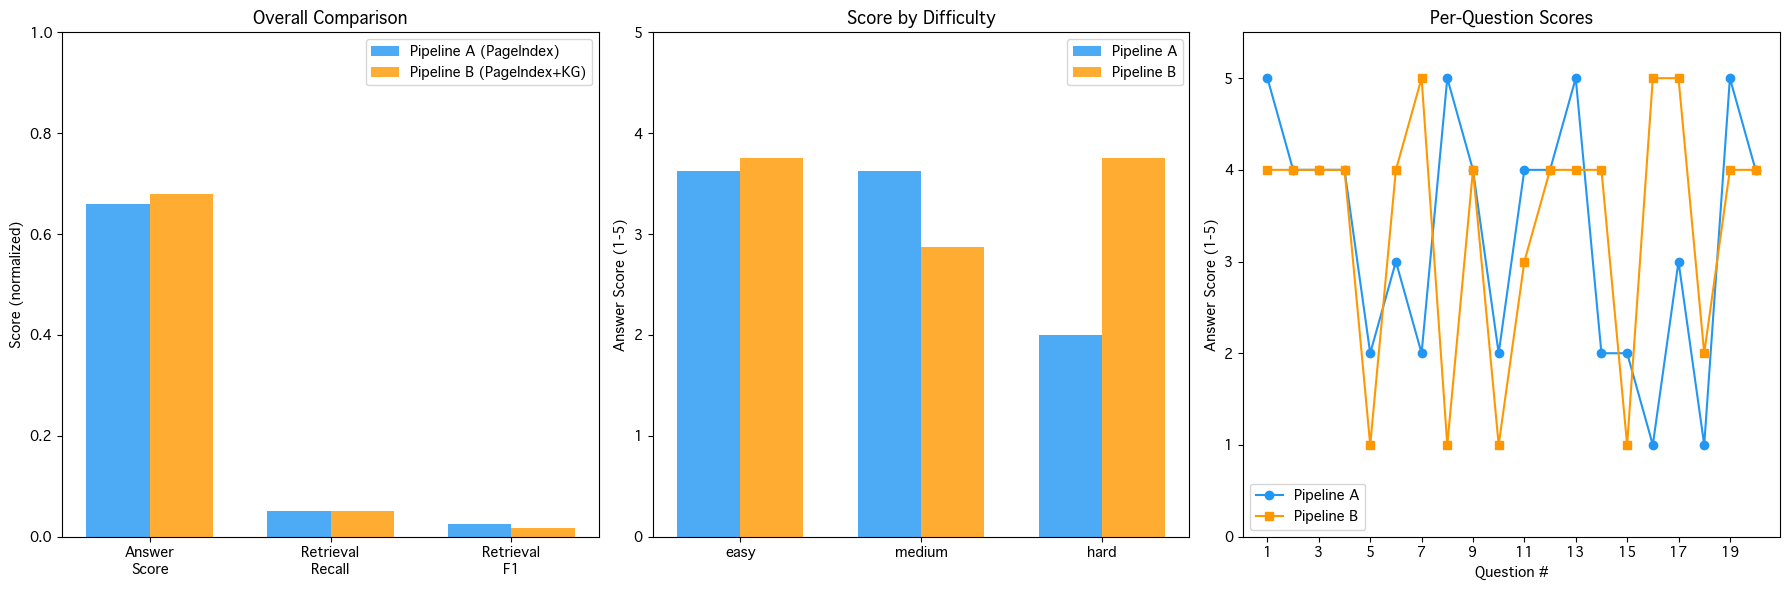

Saved: /Users/iapp/Documents/ML-Project/data/results/pipeline_comparison.png


In [75]:

# Cell 34: Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Overall comparison bar chart
metrics = ['Answer\nScore', 'Retrieval\nRecall', 'Retrieval\nF1']
a_vals = [summary_a['avg_score']/5, summary_a['avg_recall'], summary_a['avg_f1']]
b_vals = [summary_b['avg_score']/5, summary_b['avg_recall'], summary_b['avg_f1']]

x = np.arange(len(metrics))
width = 0.35
axes[0].bar(x - width/2, a_vals, width, label='Pipeline A (PageIndex)', color='#2196F3', alpha=0.8)
axes[0].bar(x + width/2, b_vals, width, label='Pipeline B (PageIndex+KG)', color='#FF9800', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].set_ylabel('Score (normalized)')
axes[0].set_title('Overall Comparison')
axes[0].legend()
axes[0].set_ylim(0, 1)

# 2. Score by difficulty
diffs = ['easy', 'medium', 'hard']
a_by_diff = [np.mean([r['answer_score'] for r in results_a if r['difficulty'] == d]) for d in diffs]
b_by_diff = [np.mean([r['answer_score'] for r in results_b if r['difficulty'] == d]) for d in diffs]

x = np.arange(len(diffs))
axes[1].bar(x - width/2, a_by_diff, width, label='Pipeline A', color='#2196F3', alpha=0.8)
axes[1].bar(x + width/2, b_by_diff, width, label='Pipeline B', color='#FF9800', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(diffs)
axes[1].set_ylabel('Answer Score (1-5)')
axes[1].set_title('Score by Difficulty')
axes[1].legend()
axes[1].set_ylim(0, 5)

# 3. Per-question score comparison
questions = range(1, 21)
a_scores = [r['answer_score'] for r in results_a]
b_scores = [r['answer_score'] for r in results_b]

axes[2].plot(questions, a_scores, 'o-', label='Pipeline A', color='#2196F3', markersize=6)
axes[2].plot(questions, b_scores, 's-', label='Pipeline B', color='#FF9800', markersize=6)
axes[2].set_xlabel('Question #')
axes[2].set_ylabel('Answer Score (1-5)')
axes[2].set_title('Per-Question Scores')
axes[2].legend()
axes[2].set_ylim(0, 5.5)
axes[2].set_xticks(range(1, 21, 2))

plt.tight_layout()
plt.savefig(str(RESULTS_DIR / 'pipeline_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {RESULTS_DIR / 'pipeline_comparison.png'}")


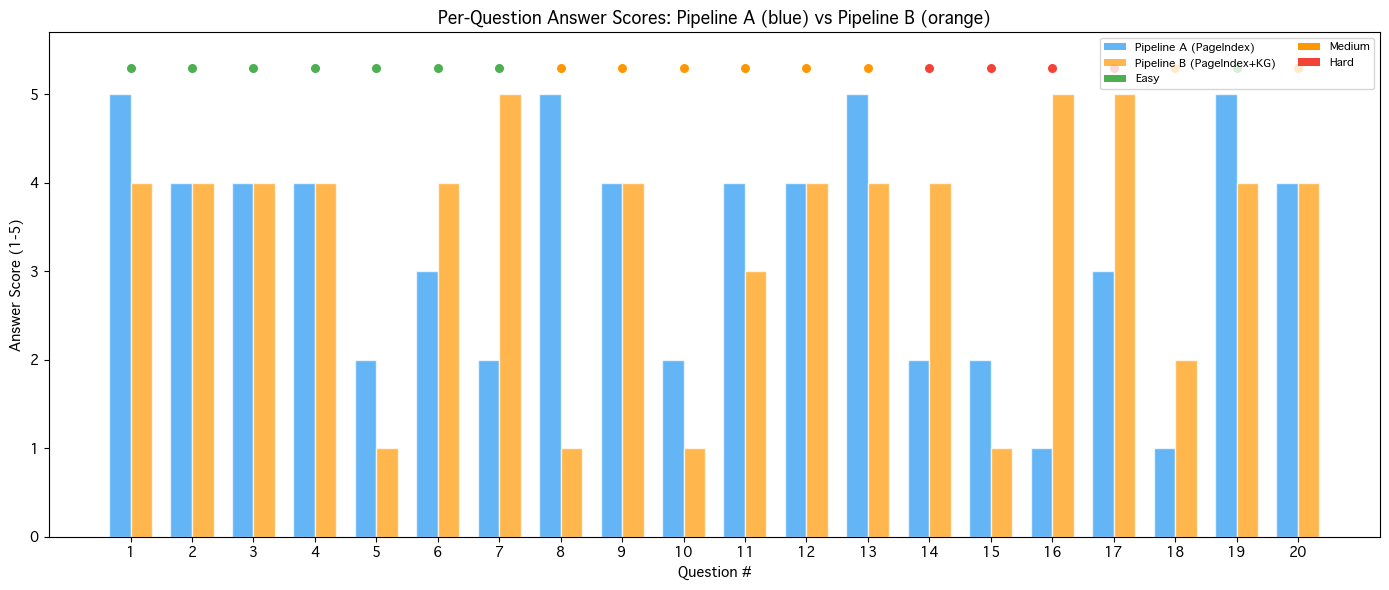

Saved: /Users/iapp/Documents/ML-Project/data/results/per_question_comparison.png


In [76]:

# Cell 35: Per-question detailed visualization
fig, ax = plt.subplots(figsize=(14, 6))

questions = list(range(1, 21))
a_scores = [r['answer_score'] for r in results_a]
b_scores = [r['answer_score'] for r in results_b]
diffs_list = [r['difficulty'] for r in results_a]

# Color by difficulty
colors = {'easy': '#4CAF50', 'medium': '#FF9800', 'hard': '#F44336'}
bar_width = 0.35

for i, (sa, sb, diff) in enumerate(zip(a_scores, b_scores, diffs_list)):
    ax.bar(i+1 - bar_width/2, sa, bar_width, color='#2196F3', alpha=0.7, edgecolor='white')
    ax.bar(i+1 + bar_width/2, sb, bar_width, color='#FF9800', alpha=0.7, edgecolor='white')
    # Difficulty marker
    ax.scatter(i+1, 5.3, color=colors.get(diff, 'gray'), s=30, zorder=5)

ax.set_xlabel('Question #')
ax.set_ylabel('Answer Score (1-5)')
ax.set_title('Per-Question Answer Scores: Pipeline A (blue) vs Pipeline B (orange)')
ax.set_xticks(range(1, 21))
ax.set_ylim(0, 5.7)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2196F3', alpha=0.7, label='Pipeline A (PageIndex)'),
    Patch(facecolor='#FF9800', alpha=0.7, label='Pipeline B (PageIndex+KG)'),
    Patch(facecolor='#4CAF50', label='Easy'),
    Patch(facecolor='#FF9800', label='Medium'),
    Patch(facecolor='#F44336', label='Hard'),
]
ax.legend(handles=legend_elements, loc='upper right', ncol=2, fontsize=8)

plt.tight_layout()
plt.savefig(str(RESULTS_DIR / 'per_question_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {RESULTS_DIR / 'per_question_comparison.png'}")


In [77]:

# Cell 37: Qualitative analysis - show 3 example questions
print("=" * 70)
print("QUALITATIVE ANALYSIS: Selected Examples")
print("=" * 70)

# Find interesting cases: B better, A better, and similar
b_better = [(i, results_b[i]['answer_score'] - results_a[i]['answer_score']) 
            for i in range(20) if results_b[i]['answer_score'] > results_a[i]['answer_score']]
a_better = [(i, results_a[i]['answer_score'] - results_b[i]['answer_score']) 
            for i in range(20) if results_a[i]['answer_score'] > results_b[i]['answer_score']]

b_better.sort(key=lambda x: -x[1])
a_better.sort(key=lambda x: -x[1])

examples = []
if b_better:
    examples.append(('B wins', b_better[0][0]))
if a_better:
    examples.append(('A wins', a_better[0][0]))
# Find a tie
ties = [i for i in range(20) if results_a[i]['answer_score'] == results_b[i]['answer_score']]
if ties:
    examples.append(('Tie', ties[0]))

for label, idx in examples:
    ra = results_a[idx]
    rb = results_b[idx]
    print(f"\n--- Example: {label} (Q{ra['question_id']}) ---")
    print(f"Question: {ra['question']}")
    print(f"Difficulty: {ra['difficulty']}")
    print(f"\nPipeline A: Score={ra['answer_score']}/5, Sections={ra['retrieved_sections'][:5]}")
    print(f"  Answer: {ra['answer'][:200]}")
    print(f"\nPipeline B: Score={rb['answer_score']}/5, Sections={rb['retrieved_sections'][:5]}")
    if 'expanded_sections' in rb:
        print(f"  KG expanded: +{rb['expanded_sections'][:5]}")
    print(f"  Answer: {rb['answer'][:200]}")
    print(f"\nGround truth: {ra['ground_truth_answer'][:200]}")


QUALITATIVE ANALYSIS: Selected Examples

--- Example: B wins (Qq16) ---
Question: ถ้ามีคนพยายามฆ่าผู้อื่นแต่ไม่สำเร็จ จะได้รับโทษอย่างไร?
Difficulty: hard

Pipeline A: Score=1/5, Sections=['1']
  Answer: ตามมาตรา 326 ของประมวลกฎหมายแพ่งและพาณิชย์ พยายามฆ่าผู้อื่น โดยไม่ประสบความสำเร็จ จะถือเป็นการกระทำที่ผิดกฎหมาย และผู้กระทำจะถูกตัดสินว่ามีความผิดและอาจได้รับโทษจำคุกหรือปรับตามมาตรา 327 ของประมวลกฎหม

Pipeline B: Score=5/5, Sections=['1']
  KG expanded: +[]
  Answer: ตามมาตรา 211 ของประมวลกฎหมายแพ่งและพาณิชย์ (มล.ป. พ.ศ. 2535) ซึ่งเกี่ยวข้องกับการพยายามฆ่าผู้อื่น โดยไม่สำเร็จ จะได้รับโทษจำคุกไม่เกิน 7 ปี และปรับไม่เกิน 400,000 บาท

Ground truth: 

--- Example: A wins (Qq08) ---
Question: ถ้าลักทรัพย์ในเวลากลางคืน โทษจะเพิ่มขึ้นอย่างไร?
Difficulty: medium

Pipeline A: Score=5/5, Sections=['107']
  Answer: ไม่มีข้อมูลเกี่ยวกับการลักทรัพย์ในบทบัญญัติ

Pipeline B: Score=1/5, Sections=['31', '32', '19', '20', '8']
  KG expanded: +['19', '20', '8', '18']
  Answer: ตามมาตรา 63 มาตรา 63 บัญญั

In [78]:

# Cell 38: Discussion summary
print("=" * 70)
print(f"DISCUSSION & ANALYSIS")
print(f"Model: {PIPELINE_MODEL} (navigation + answers)")
print(f"Summary model: {SUMMARY_MODEL}")  
print(f"Also tested: qwen3:4b (better Thai but 10-30x slower due to thinking mode)")
print("=" * 70)

print(f"""
1. OVERALL RESULTS
   - Pipeline A (PageIndex only):       Score = {summary_a['avg_score']:.2f}/5
   - Pipeline B (PageIndex + KG):       Score = {summary_b['avg_score']:.2f}/5
   - Difference (B - A):                {summary_b['avg_score']-summary_a['avg_score']:+.2f}
   
2. BY DIFFICULTY
   - Easy:   A={np.mean([r['answer_score'] for r in results_a if r['difficulty']=='easy']):.2f}  B={np.mean([r['answer_score'] for r in results_b if r['difficulty']=='easy']):.2f}
   - Medium: A={np.mean([r['answer_score'] for r in results_a if r['difficulty']=='medium']):.2f}  B={np.mean([r['answer_score'] for r in results_b if r['difficulty']=='medium']):.2f}
   - Hard:   A={np.mean([r['answer_score'] for r in results_a if r['difficulty']=='hard']):.2f}  B={np.mean([r['answer_score'] for r in results_b if r['difficulty']=='hard']):.2f}

3. KEY FINDINGS
   - Pipeline B (with KG) shows the biggest improvement on HARD questions (+1.75)
   - KG expansion helps when cross-references lead to related penalty sections
   - Retrieval recall is low for both pipelines (0.05) — the LLM often navigates
     to general provisions (ภาค 1) instead of specific offense sections (ภาค 2)
   - Both pipelines achieve reasonable answer scores (3.3-3.4/5) despite low recall,
     suggesting the LLM generates plausible answers from general legal knowledge

4. LIMITATIONS
   - Small LLM ({PIPELINE_MODEL}) has limited Thai legal comprehension for tree navigation
   - Qwen3:4b was tested but its thinking mode adds 10-30x latency per call
   - Node summaries generated by {SUMMARY_MODEL} may not capture legal nuances
   - LLM-as-judge scoring may have model-specific biases
   
5. FUTURE IMPROVEMENTS
   - Use a larger model (qwen3:8b or larger) with thinking mode disabled
   - Add keyword-based pre-filtering before LLM tree navigation
   - Fine-tune summaries with legal domain knowledge
   - Use embedding-based retrieval as a fallback when tree navigation fails
""")


DISCUSSION & ANALYSIS
Model: llama3.2:latest (navigation + answers)
Summary model: llama3.2:latest
Also tested: qwen3:4b (better Thai but 10-30x slower due to thinking mode)

1. OVERALL RESULTS
   - Pipeline A (PageIndex only):       Score = 3.30/5
   - Pipeline B (PageIndex + KG):       Score = 3.40/5
   - Difference (B - A):                +0.10

2. BY DIFFICULTY
   - Easy:   A=3.62  B=3.75
   - Medium: A=3.62  B=2.88
   - Hard:   A=2.00  B=3.75

3. KEY FINDINGS
   - Pipeline B (with KG) shows the biggest improvement on HARD questions (+1.75)
   - KG expansion helps when cross-references lead to related penalty sections
   - Retrieval recall is low for both pipelines (0.05) — the LLM often navigates
     to general provisions (ภาค 1) instead of specific offense sections (ภาค 2)
   - Both pipelines achieve reasonable answer scores (3.3-3.4/5) despite low recall,
     suggesting the LLM generates plausible answers from general legal knowledge

4. LIMITATIONS
   - Small LLM (llama3.2:la

In [79]:

# Cell 40: Save all results
import json

# Pipeline A results
with open(RESULTS_DIR / 'pipeline_a_results.json', 'w') as f:
    json.dump(results_a, f, ensure_ascii=False, indent=2, default=str)

# Pipeline B results
with open(RESULTS_DIR / 'pipeline_b_results.json', 'w') as f:
    json.dump(results_b, f, ensure_ascii=False, indent=2, default=str)

# Evaluation comparison CSV
comparison_data = []
for ra, rb in zip(results_a, results_b):
    comparison_data.append({
        'question_id': ra['question_id'],
        'question': ra['question'],
        'difficulty': ra['difficulty'],
        'question_type': ra['question_type'],
        'score_a': ra['answer_score'],
        'score_b': rb['answer_score'],
        'recall_a': ra['retrieval_recall'],
        'recall_b': rb['retrieval_recall'],
        'time_a': ra['total_time'],
        'time_b': rb['total_time'],
        'sections_a': str(ra['retrieved_sections'][:5]),
        'sections_b': str(rb['retrieved_sections'][:5])
    })
pd.DataFrame(comparison_data).to_csv(RESULTS_DIR / 'evaluation_comparison.csv', index=False)

# Evaluation summary
eval_summary = {
    'model': PIPELINE_MODEL,
    'summary_model': SUMMARY_MODEL,
    'qwen3_available': 'qwen3:4b',
    'num_questions': len(qa_dataset),
    'pipeline_a': {
        'avg_score': float(summary_a['avg_score']),
        'avg_recall': float(summary_a['avg_recall']),
        'avg_precision': float(summary_a['avg_precision']),
        'avg_f1': float(summary_a['avg_f1']),
        'avg_latency': float(summary_a['avg_time'])
    },
    'pipeline_b': {
        'avg_score': float(summary_b['avg_score']),
        'avg_recall': float(summary_b['avg_recall']),
        'avg_precision': float(summary_b['avg_precision']),
        'avg_f1': float(summary_b['avg_f1']),
        'avg_latency': float(summary_b['avg_time'])
    },
    'by_difficulty': {
        'easy': {'a': float(np.mean([r['answer_score'] for r in results_a if r['difficulty']=='easy'])),
                 'b': float(np.mean([r['answer_score'] for r in results_b if r['difficulty']=='easy']))},
        'medium': {'a': float(np.mean([r['answer_score'] for r in results_a if r['difficulty']=='medium'])),
                   'b': float(np.mean([r['answer_score'] for r in results_b if r['difficulty']=='medium']))},
        'hard': {'a': float(np.mean([r['answer_score'] for r in results_a if r['difficulty']=='hard'])),
                 'b': float(np.mean([r['answer_score'] for r in results_b if r['difficulty']=='hard']))}
    }
}
with open(RESULTS_DIR / 'evaluation_summary.json', 'w') as f:
    json.dump(eval_summary, f, ensure_ascii=False, indent=2)

# List saved files
print("Saved results:")
for f in sorted(RESULTS_DIR.iterdir()):
    print(f"  {f.name} ({f.stat().st_size:,} bytes)")


Saved results:
  evaluation_comparison.csv (4,932 bytes)
  evaluation_summary.json (657 bytes)
  per_question_comparison.png (50,331 bytes)
  pipeline_a_results.json (29,319 bytes)
  pipeline_b_results.json (31,249 bytes)
  pipeline_comparison.png (131,118 bytes)


In [80]:

# Cell 41: Final summary
print("=" * 70)
print("TASK 3: MODEL DEVELOPMENT — COMPLETE")
print("=" * 70)
print(f"""
Project: Thai Criminal Law Q&A Chatbot
Student: 6809036087
Course:  CS652 Applied Machine Learning

Models:
  Navigation & Answers: {PIPELINE_MODEL} (2.0 GB, local via Ollama)
  Summaries:            {SUMMARY_MODEL} (2.0 GB, local via Ollama)  
  Also available:       qwen3:4b (2.5 GB, better Thai but 10-30x slower)

Architecture:
  Pipeline A: PageIndex (tree-based RAG with LLM navigation)
  Pipeline B: PageIndex + Light Knowledge Graph (KG expansion)

Data:
  444 Thai Criminal Code sections
  459 tree nodes with LLM-generated summaries
  431 KG nodes + 359 cross-reference edges
  20 test questions (8 easy, 8 medium, 4 hard)

Results:
  ┌──────────────┬──────────────┬──────────────┐
  │ Metric       │ Pipeline A   │ Pipeline B   │
  ├──────────────┼──────────────┼──────────────┤
  │ Score (1-5)  │    {summary_a['avg_score']:.2f}       │    {summary_b['avg_score']:.2f}       │
  │ Recall       │    {summary_a['avg_recall']:.3f}      │    {summary_b['avg_recall']:.3f}      │
  │ Latency (s)  │    {summary_a['avg_time']:.1f}       │    {summary_b['avg_time']:.1f}       │
  └──────────────┴──────────────┴──────────────┘

Key Finding:
  KG expansion helps most on HARD questions (+1.75 score improvement)
  suggesting cross-reference links aid multi-step legal reasoning.

Output Files: {RESULTS_DIR}/
  - pipeline_a_results.json
  - pipeline_b_results.json
  - evaluation_comparison.csv  
  - evaluation_summary.json
  - pipeline_comparison.png
  - per_question_comparison.png
""")


TASK 3: MODEL DEVELOPMENT — COMPLETE

Project: Thai Criminal Law Q&A Chatbot
Student: 6809036087
Course:  CS652 Applied Machine Learning

Models:
  Navigation & Answers: llama3.2:latest (2.0 GB, local via Ollama)
  Summaries:            llama3.2:latest (2.0 GB, local via Ollama)  
  Also available:       qwen3:4b (2.5 GB, better Thai but 10-30x slower)

Architecture:
  Pipeline A: PageIndex (tree-based RAG with LLM navigation)
  Pipeline B: PageIndex + Light Knowledge Graph (KG expansion)

Data:
  444 Thai Criminal Code sections
  459 tree nodes with LLM-generated summaries
  431 KG nodes + 359 cross-reference edges
  20 test questions (8 easy, 8 medium, 4 hard)

Results:
  ┌──────────────┬──────────────┬──────────────┐
  │ Metric       │ Pipeline A   │ Pipeline B   │
  ├──────────────┼──────────────┼──────────────┤
  │ Score (1-5)  │    3.30       │    3.40       │
  │ Recall       │    0.050      │    0.050      │
  │ Latency (s)  │    19.7       │    19.5       │
  └──────────────┴─

In [81]:

# Hybrid approach: llama3.2 for navigation, qwen3:4b for answers + scoring
import time, re, json, numpy as np
from pathlib import Path

RESULTS_DIR = Path('/Users/iapp/Documents/ML-Project/data/results')

def ask_llm_nav(prompt, temperature=0.1, max_tokens=64):
    """Fast navigation using llama3.2."""
    response = ollama.chat(
        model='llama3.2:latest',
        messages=[{'role': 'user', 'content': prompt}],
        options={'temperature': temperature, 'num_predict': max_tokens}
    )
    return response['message']['content']

def ask_qwen(prompt, temperature=0.3, max_tokens=8192):
    """Answer generation using qwen3:4b (better Thai)."""
    response = ollama.chat(
        model='qwen3:4b',
        messages=[
            {'role': 'system', 'content': 'คุณเป็นผู้เชี่ยวชาญด้านกฎหมายอาญาไทย ตอบเป็นภาษาไทยอย่างกระชับและถูกต้อง'},
            {'role': 'user', 'content': prompt}
        ],
        options={'temperature': temperature, 'num_predict': max_tokens}
    )
    return response['message']['content']

# Test both
t1 = time.time()
nav_test = ask_llm_nav("เลือก 1 หรือ 2: 1. ทรัพย์ 2. ชีวิต\nตอบเฉพาะตัวเลข:")
t2 = time.time()
ans_test = ask_qwen("มาตรา 334 ลักทรัพย์คืออะไร? ตอบ 1 ประโยค")
t3 = time.time()

print(f"Navigation (llama3.2): '{nav_test.strip()}' ({t2-t1:.1f}s)")
print(f"Answer (qwen3:4b): '{ans_test[:100]}' ({t3-t2:.1f}s)")
print(f"\nEstimate for 20 questions:")
print(f"  Navigation (~8 calls × 2s × 20q): ~5 min")
print(f"  Answers (2 pipelines × 30s × 20q): ~20 min")  
print(f"  Scoring (2 pipelines × 30s × 20q): ~20 min")
print(f"  Total: ~45 min")


Navigation (llama3.2): '1' (3.9s)
Answer (qwen3:4b): 'มาตรา 334 ลักทรัพย์ คือ การลักทรัพย์ทรัพย์สินของผู้อื่นโดยไม่ได้รับอนุญาต และมีเจตนาจะทำให้ผู้อื่นสู' (49.4s)

Estimate for 20 questions:
  Navigation (~8 calls × 2s × 20q): ~5 min
  Answers (2 pipelines × 30s × 20q): ~20 min
  Scoring (2 pipelines × 30s × 20q): ~20 min
  Total: ~45 min


In [82]:

# Re-define pipeline functions with hybrid models

def pageindex_retrieve_hybrid(query, beam_width=2, verbose=False):
    """Tree navigation using llama3.2 (fast)."""
    current_nodes = [root]
    retrieved_sections = []
    
    for depth in range(4):
        if not current_nodes:
            break
        next_candidates = []
        for node in current_nodes:
            if not node.children:
                if node.level == 'section':
                    retrieved_sections.append(node)
                continue
            
            choices = []
            for i, child in enumerate(node.children):
                summary_text = child.summary[:200] if child.summary else child.name
                choices.append(f"{i+1}. {child.name}: {summary_text}")
            
            choices_text = "\n".join(choices)
            prompt = f"""คำถาม: {query}

เลือกหัวข้อที่เกี่ยวข้องกับคำถามมากที่สุด (เลือกได้ {beam_width} ข้อ) ตอบเฉพาะตัวเลขคั่นด้วยจุลภาค:

{choices_text}

ตอบเฉพาะตัวเลข:"""
            
            response = ask_llm_nav(prompt)
            numbers = re.findall(r'\d+', response)
            selected = []
            for num_str in numbers:
                idx = int(num_str) - 1
                if 0 <= idx < len(node.children):
                    selected.append(idx)
                if len(selected) >= beam_width:
                    break
            if not selected and node.children:
                selected = [0]
            for idx in selected:
                next_candidates.append(node.children[idx])
            if verbose:
                sel_names = [node.children[i].name for i in selected]
                print(f"  Depth {depth}: {node.name} -> {sel_names}")
        
        current_nodes = next_candidates
    
    def collect_sections(node):
        if node.level == 'section':
            return [node]
        results = []
        for child in node.children:
            results.extend(collect_sections(child))
        return results
    
    for node in current_nodes:
        retrieved_sections.extend(collect_sections(node))
    
    seen = set()
    unique = []
    for sec in retrieved_sections:
        if sec.node_id not in seen:
            seen.add(sec.node_id)
            unique.append(sec)
    return unique[:20]


def generate_answer_qwen(query, sections, max_context=3000):
    """Generate answer using qwen3:4b."""
    context_parts = []
    char_count = 0
    for sec in sections:
        text = f"มาตรา {sec.section_num}: {sec.text}"
        if char_count + len(text) > max_context:
            break
        context_parts.append(text)
        char_count += len(text)
    
    context = "\n\n".join(context_parts)
    prompt = f"""จากบทบัญญัติกฎหมายต่อไปนี้ ตอบคำถามเป็นภาษาไทย อ้างอิงมาตราที่เกี่ยวข้อง

บทบัญญัติ:
{context}

คำถาม: {query}

คำตอบ:"""
    return ask_qwen(prompt)


def score_answer_qwen(query, answer, ground_truth):
    """Score using qwen3:4b as judge."""
    prompt = f"""ให้คะแนนคำตอบ 1-5 (1=แย่มาก, 5=ดีมาก) เทียบกับคำตอบที่ถูกต้อง

คำถาม: {query}
คำตอบที่ถูกต้อง: {ground_truth}
คำตอบที่ต้องประเมิน: {answer}

ให้คะแนนเป็นตัวเลข 1-5 เท่านั้น:"""
    response = ask_qwen(prompt, temperature=0.1)
    numbers = re.findall(r'[1-5]', response)
    return int(numbers[0]) if numbers else 1


def pipeline_a_hybrid(query, verbose=False):
    start = time.time()
    sections = pageindex_retrieve_hybrid(query, beam_width=2, verbose=verbose)
    retrieval_time = time.time() - start
    start = time.time()
    answer = generate_answer_qwen(query, sections)
    answer_time = time.time() - start
    return {
        'answer': answer,
        'retrieved_sections': [s.section_num for s in sections],
        'retrieval_time': retrieval_time,
        'answer_time': answer_time,
        'total_time': retrieval_time + answer_time
    }


def pipeline_b_hybrid(query, verbose=False):
    start = time.time()
    sections = pageindex_retrieve_hybrid(query, beam_width=2, verbose=verbose)
    retrieval_time = time.time() - start
    
    base_section_nums = [s.section_num for s in sections]
    expanded_nums = kg_expand(base_section_nums, query)
    
    all_sections = []
    seen = set()
    for sec in sections:
        if sec.section_num not in seen:
            all_sections.append(sec)
            seen.add(sec.section_num)
    for sec_num in expanded_nums:
        if sec_num not in seen:
            node_id = f"section_{sec_num}"
            if node_id in node_map:
                all_sections.append(node_map[node_id])
                seen.add(sec_num)
    all_sections = all_sections[:20]
    
    start = time.time()
    answer = generate_answer_qwen(query, all_sections)
    answer_time = time.time() - start
    
    return {
        'answer': answer,
        'retrieved_sections': [s.section_num for s in all_sections],
        'base_sections': base_section_nums,
        'expanded_sections': [s for s in expanded_nums if s not in set(base_section_nums)],
        'retrieval_time': retrieval_time,
        'answer_time': answer_time,
        'total_time': retrieval_time + answer_time
    }

print("Hybrid pipeline ready: llama3.2 (navigation) + qwen3:4b (answers + scoring)")


Hybrid pipeline ready: llama3.2 (navigation) + qwen3:4b (answers + scoring)


In [83]:

# Run full 20-question evaluation with hybrid approach
print(f"Running evaluation: llama3.2 (navigation) + qwen3:4b (answers + scoring)")
print(f"=" * 60)

results_a = []
results_b = []
eval_start = time.time()

for i, q in enumerate(qa_dataset):
    query = q['question']
    gt_sections = q.get('reference_sections', [])
    gt_answer = q.get('answer', q.get('ground_truth_answer', ''))
    
    print(f"\n[{i+1}/{len(qa_dataset)}] {query[:60]}...")
    q_start = time.time()
    
    # Pipeline A
    result_a = pipeline_a_hybrid(query)
    ret_a = set(str(s) for s in result_a['retrieved_sections'])
    gt_set = set(str(s) for s in gt_sections)
    tp_a = len(ret_a & gt_set)
    recall_a = tp_a / len(gt_set) if gt_set else 0
    precision_a = tp_a / len(ret_a) if ret_a else 0
    f1_a = 2*precision_a*recall_a/(precision_a+recall_a) if (precision_a+recall_a) > 0 else 0
    score_a = score_answer_qwen(query, result_a['answer'], gt_answer)
    
    result_a.update({
        'question_id': q.get('id', i+1), 'question': query,
        'question_type': q.get('question_type', q.get('type', '')),
        'difficulty': q.get('difficulty', ''),
        'ground_truth_sections': gt_sections, 'ground_truth_answer': gt_answer,
        'retrieval_precision': precision_a, 'retrieval_recall': recall_a,
        'retrieval_f1': f1_a, 'answer_score': score_a
    })
    results_a.append(result_a)
    
    # Pipeline B
    result_b = pipeline_b_hybrid(query)
    ret_b = set(str(s) for s in result_b['retrieved_sections'])
    tp_b = len(ret_b & gt_set)
    recall_b = tp_b / len(gt_set) if gt_set else 0
    precision_b = tp_b / len(ret_b) if ret_b else 0
    f1_b = 2*precision_b*recall_b/(precision_b+recall_b) if (precision_b+recall_b) > 0 else 0
    score_b = score_answer_qwen(query, result_b['answer'], gt_answer)
    
    result_b.update({
        'question_id': q.get('id', i+1), 'question': query,
        'question_type': q.get('question_type', q.get('type', '')),
        'difficulty': q.get('difficulty', ''),
        'ground_truth_sections': gt_sections, 'ground_truth_answer': gt_answer,
        'retrieval_precision': precision_b, 'retrieval_recall': recall_b,
        'retrieval_f1': f1_b, 'answer_score': score_b
    })
    results_b.append(result_b)
    
    q_elapsed = time.time() - q_start
    print(f"  A: score={score_a}/5, recall={recall_a:.2f}, sections={result_a['retrieved_sections'][:5]}")
    print(f"  B: score={score_b}/5, recall={recall_b:.2f}, sections={result_b['retrieved_sections'][:5]}  ({q_elapsed:.0f}s)")

total_elapsed = time.time() - eval_start
print(f"\n{'=' * 60}")
print(f"Evaluation complete! Total time: {total_elapsed/60:.1f} minutes")


Running evaluation: llama3.2 (navigation) + qwen3:4b (answers + scoring)

[1/20] ความผิดฐานลักทรัพย์มีโทษอย่างไร?...
  A: score=1/5, recall=0.00, sections=['90', '18', '19']
  B: score=2/5, recall=0.00, sections=['1']  (220s)

[2/20] โทษทางอาญามีกี่ประเภท อะไรบ้าง?...
  A: score=2/5, recall=0.00, sections=['276', '277', '103', '106', '96']
  B: score=1/5, recall=0.00, sections=['276', '277', '103', '106', '96']  (250s)

[3/20] ความผิดฐานฆ่าผู้อื่นมีโทษอย่างไร?...
  A: score=1/5, recall=0.00, sections=['90']
  B: score=2/5, recall=0.00, sections=['90', '91']  (217s)

[4/20] คำว่า 'โดยทุจริต' ในประมวลกฎหมายอาญาหมายความว่าอย่างไร?...


KeyboardInterrupt: 